In [2]:
!pip install geopandas
!pip install earthpy
!pip install mlxtend

     |████████████████████████████████| 1.3 MB 1.1 MB/s eta 0:00:01


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize, PowerTransformer, power_transform, scale, StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import calendar
import os
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import earthpy as et
from tqdm.notebook import tqdm
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import json

%matplotlib inline

In [2]:
!wget --directory-prefix=../data/covid/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/covid/covid_month.csv
!wget --directory-prefix=../data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/social_explorer_processed_data.csv
!wget --directory-prefix=../data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/social_explorer_processed_data_only_percents.csv
!wget -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/shape/la_shape.zip
!unzip -nq la_shape -d shape

# LA County Shapefile

In [3]:
# la_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
la_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
la_filtered = la_shapes.rename(columns={'name':'region'})
la_filtered["plot_col"] = 0 # Column used to graph neighbors
la_filtered = la_filtered[['region','geometry','plot_col']]
la_filtered.head()

region                                           geometry  \
0            Acton  POLYGON ((-118.20262 34.53899, -118.18947 34.5...   
1  Adams-Normandie  POLYGON ((-118.30901 34.03741, -118.30041 34.0...   
2     Agoura Hills  POLYGON ((-118.76193 34.16820, -118.72632 34.1...   
3       Agua Dulce  POLYGON ((-118.25468 34.55830, -118.25551 34.5...   
4         Alhambra  POLYGON ((-118.12175 34.10504, -118.11687 34.1...   

   plot_col  
0         0  
1         0  
2         0  
3         0  
4         0

## Smooth/process COVID data

In [4]:
!wget --directory-prefix=../data/covid -Nq https://raw.githubusercontent.com/ANRGUSC/lacounty_covid19_data/master/data/Covid-19.csv
covid_filename = '../data/covid/Covid-19.csv'

covid_df = pd.read_csv(covid_filename)
covid_df = covid_df.rename(columns={'Region':'region', 'Number of cases':'cases'})
covid_df.head()

Time Stamp         region   Latitude   Longitude  cases
0  03-16-2020       Alhambra  34.093042 -118.127060      2
1  03-16-2020        Arcadia  34.136208 -118.040150      1
2  03-16-2020  Beverly Hills  34.069650 -118.396306      1
3  03-16-2020  Boyle Heights  34.043689 -118.209768      5
4  03-16-2020         Carson  33.832204 -118.251755      1

In [5]:
# Set COVID cases to not be less than previously recorded - it should be a non-decreasing function
for region in covid_df["region"].unique():
  df = covid_df[covid_df['region'] == region]
  prev_cases = 0
  for idx, row in df.iterrows():
    if prev_cases > row['cases']:
      covid_df.loc[idx, 'cases'] =  prev_cases
    else:
      prev_cases = row['cases']

In [6]:
for region in covid_df["region"].unique():
  df = covid_df[covid_df['region'] == region]
  prev_cases = 0
  for idx, row in df.iterrows():
    covid_df.loc[idx, 'active_cases'] =  row['cases'] - prev_cases
    prev_cases = row['cases']
covid_df[covid_df['region'] == 'Alhambra']

Time Stamp    region   Latitude  Longitude  cases  active_cases
0      03-16-2020  Alhambra  34.093042 -118.12706      2           2.0
31     03-17-2020  Alhambra  34.093042 -118.12706      2           0.0
73     03-18-2020  Alhambra  34.093042 -118.12706      2           0.0
118    03-19-2020  Alhambra  34.093042 -118.12706      2           0.0
188    03-20-2020  Alhambra  34.093042 -118.12706      3           1.0
...           ...       ...        ...        ...    ...           ...
54326   11-5-2020  Alhambra  34.093042 -118.12706   1472           5.0
54564   11-6-2020  Alhambra  34.093042 -118.12706   1480           8.0
54802   11-7-2020  Alhambra  34.093042 -118.12706   1492          12.0
55040   11-8-2020  Alhambra  34.093042 -118.12706   1501           9.0
55278   11-9-2020  Alhambra  34.093042 -118.12706   1508           7.0

[223 rows x 6 columns]

## Fix inconsistencies in region name mapping

In [7]:
la_to_covid = {
    'Downtown': ['City', 'Pico', 'Wholesale District', 'Central', 'Little Tokyo', 'Temple-Beaudry'],
    'Silver Lake': ['Silverlake'],
    'Vernon': ['West Vernon', 'Vernon Central'],
    'Baldwin Hills/Crenshaw': ['Baldwin Hills'],
    'West Hollywood': ['Park LaBrea'],
    'Mid-Wilshire': ['Park LaBrea', 'Cloverdale/Cochran'],
    'Santa Clarity': ['Canyon Country'],
    'Echo Park': ['Angelino Heights'],
    'Avocado Heights': ['Bassett'],
    'Bel-Air': ['Bel Air'],
    'Arlington Heights': ['Country Club Park'],
    'Exposition Park': ['Exposition'],
    'Chinatown': ['Figueroa Park Square'],
    'Torrance': ['Gramercy Place'],
    'Harbor City': ['Harbor Pines'],
    'Mid-City': ['Lafayette Square', 'Mid-city', 'Reynier Village', 'Victoria Park', 'Wellington Square'],
    'Azusa': ['Lakeview Terrace'],
    'East Hollywood': ['Little Armenia'],
    'Playa Vista': ['Longwood'],
    'Brentwood': ['Mandeville Canyon'],
    'Playa del Rey': ['Playa Del Rey'],
    'Porter Ranch': ['Reseda Ranch'],
    'Carthay': ['South Carthay'],
    'Los Feliz': ['Thai Town'],
    'Toluca Lake': ['Toluca Terrace'],
    'El Sereno': ['University Hills'],
    'Angeles Crest': ['Angeles National Forest'],
    'Mount Washington': ['Mt. Washington']
}

for key, value in la_to_covid.items():
    covid_df.loc[covid_df['region'].isin(value), 'region'] = key

## Month aggregate

In [8]:
covid_df_month = covid_df[['Time Stamp', 'region', 'active_cases']]
covid_df_month['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])
covid_df_month = covid_df_month.set_index('Time Stamp')
covid_df_month = covid_df_month.groupby([pd.Grouper(freq='M'), 'region']).sum()
covid_df_month = covid_df_month.reset_index(level=['Time Stamp','region']).rename(columns={'Time Stamp': 'month'})
covid_df_month.month = covid_df_month.month.dt.month
covid_df_month = covid_df_month[covid_df_month.month != 3] ## Remove march data since its not complete
covid_df_month

<ipython-input-8-787227d294ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_month['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])


month           region  active_cases
219       4            Acton          24.0
220       4  Adams-Normandie          21.0
221       4     Agoura Hills          13.0
222       4         Alhambra          31.0
223       4           Alsace          29.0
...     ...              ...           ...
1940     11      Willowbrook           0.0
1941     11       Wilmington          65.0
1942     11  Wilshire Center          70.0
1943     11         Winnetka         133.0
1944     11   Woodland Hills          96.0

[1726 rows x 3 columns]

## Census data

In [9]:
census_data = pd.read_csv('../data/social_explorer_processed_data_only_percents.csv')
census_data.shape

(261, 168)

## Migration data

In [10]:
migration_data = pd.read_csv('../data/safegraph_aggregated.csv')
migration_data = migration_data[['name','month','Number of incoming visits', 'Number of outgoing visits (no regI to regI)']]
migration_data = migration_data.rename(columns={'name':'region','Number of incoming visits':'incoming','Number of outgoing visits (no regI to regI)':'outgoing'})
migration_data.head(5)

region  month  incoming  outgoing
0            Agoura Hills      3        21         0
1                  Arleta      3       396     16377
2       Arlington Heights      3        80         0
3         Atwater Village      3     18134      1334
4  Baldwin Hills/Crenshaw      3       316         0

## Employment data

In [11]:
employment_data = pd.read_csv('../data/lodes_processed_data.csv')
employment_data = employment_data[['name', 'C000', 'CNS16', 'CNS18']].rename(columns={'name':'region','C000':'total','CNS16':'health','CNS18':'food'})
employment_data.head(5)

region  total  health  food
0            Acton   4021     479   315
1  Adams-Normandie   6100    1017   812
2     Agoura Hills   9539    1058   799
3       Agua Dulce   2158     242   144
4         Alhambra  38542    7022  4191

## Nursing Home data

In [12]:
nursing_data = pd.read_csv('../data/Nursing_Homes_Processed_Data.csv')
nursing_data = nursing_data.rename(columns={'Neighborhood':'region','% of NursingHomeBeds':'% beds'})
nursing_data.head(5)

region  NursingHomeBeds    % beds
0            Acton                0  0.000000
1  Adams-Normandie               90  0.117246
2     Agoura Hills              185  0.241005
3       Agua Dulce                0  0.000000
4         Alhambra             1105  1.439514

In [13]:
# check_df = migration_unique_regions.assign(InDf2=migration_unique_regions.region.isin(regions.region))
# miss_arr = pd.unique(check_df[check_df['InDf2']==False]['region'])
# miss_arr

In [14]:
# check_df = regions.assign(InDf2=regions.region.isin(migration_unique_regions.region))
# miss_arr = pd.unique(check_df[check_df['InDf2']==False]['region'])
# miss_arr

In [15]:
used_features = [
  'name',
  '% Area Total: Area (Land)',
  '% Area Total: Area (Water)',
  '% Total Population: Under 5 Years',
  '% Total Population: 5 to 9 Years',
  '% Total Population: 10 to 14 Years',
  '% Total Population: 15 to 17 Years',
  '% Total Population: 18 to 24 Years',
  '% Total Population: 25 to 34 Years',
  '% Total Population: 35 to 44 Years',
  '% Total Population: 45 to 54 Years',
  '% Total Population: 55 to 64 Years',
  '% Total Population: 65 to 74 Years',
  '% Total Population: 75 to 84 Years',
  '% Total Population: 85 Years and Over',
  '% Households: Family Households',
  '% Households: Family Households: Married-Couple Family',
  '% Households: Family Households: Other Family',
  '% Households: Family Households: Other Family: Male Householder, No Wife Present',
  '% Households: Family Households: Other Family: Female Householder, No Husband Present',
  '% Households: Nonfamily Households',
  '% Households: Nonfamily Households: Male Householder',
  '% Households: Nonfamily Households: Female Householder',
  '% Population 16 Years and Over: in Labor Force',
  '% Population 16 Years and Over: in Labor Force: in Armed Forces',
  '% Population 16 Years and Over: in Labor Force: Civilian',
  '% Population 16 Years and Over: in Labor Force: Civilian: Employed',
  '% Population 16 Years and Over: in Labor Force: Civilian: Unemployed',
  '% Population 16 Years and Over: Not in Labor Force',
  '% In Labor Force 16 Years and Over: in Armed Forces',
  '% In Labor Force 16 Years and Over: Civilian',
  '% Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining',
  '% Employed Civilian Population 16 Years and Over: Construction',
  '% Employed Civilian Population 16 Years and Over: Manufacturing',
  '% Employed Civilian Population 16 Years and Over: Wholesale Trade',
  '% Employed Civilian Population 16 Years and Over: Retail Trade',
  '% Employed Civilian Population 16 Years and Over: Transportation and Warehousing, and Utilities',
  '% Employed Civilian Population 16 Years and Over: Information',
  '% Employed Civilian Population 16 Years and Over: Finance and Insurance, and Real Estate and Rental  and Leasing',
  '% Employed Civilian Population 16 Years and Over: Professional, Scientific, and Management, and  Administrative and Waste Management Services',
  '% Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance',
  '% Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services',
  '% Employed Civilian Population 16 Years and Over: Other Services, Except Public Administration',
  '% Employed Civilian Population 16 Years and Over: Public Administration',
  '% Employed Civilian Population 16 Years and Over1: Private Sector',
  '% Employed Civilian Population 16 Years and Over1: Public Sector',
  '% Employed Civilian Population 16 Years and Over1: Self-Employed (Incorporated and Not Incorporated)',
  '% Employed Civilian Population 16 Years and Over1: Private Non-Profit',
  '% Employed Civilian Population 16 Years and Over1: Unpaid Family Workers',
  '% Households1: with Earnings', '% Households1: No Earnings',
  '% Households2: with Wage or Salary Income',
  '% Households2: No Wage or Salary Income',
  '% Households3: with Self-Employment Income',
  '% Households3: No Self-Employment Income',
  '% Households4: with Interest, Dividends, or Net Rental Income',
  '% Households4: No Interest, Dividends, or Net Rental Income',
  '% Households5: with Social Security Income',
  '% Households5: No Social Security Income',
  '% Households6: with Supplemental Security Income (Ssi)',
  '% Households6: No Supplemental Security Income (Ssi)',
  '% Households7: with Public Assistance Income',
  '% Households7: No Public Assistance Income',
  '% Households8: with Retirement Income',
  '% Households8: No Retirement Income',
  '% Households9: with Other Types of Income',
  '% Households9: No Other Types of Income',
  '% Families: Income Below Poverty Level',
  '% Families: Income Below Poverty Level: Married Couple Family: with Related Child Living  Bellow Poverty Level',
  '% Families: Income Below Poverty Level: Married Couple Family: No Related Children Under 18 Years',
  '% Families: Income Below Poverty Level: Male Householder, No Wife Present',
  '% Families: Income Below Poverty Level: Male Householder, No Wife Present: with Related Children Under 18 Years',
  '% Families: Income Below Poverty Level: Male Householder, No Wife Present: No Related Children Under 18 Years',
  '% Families: Income Below Poverty Level: Female Householder, No Husband Present',
  '% Families: Income Below Poverty Level: Female Householder, No Husband Present: with Related Children Under 18 Years',
  '% Families: Income Below Poverty Level: Female Householder, No Husband Present: No Related Children Under 18 Years',
  '% Families: Income At or Above Poverty Level',
  '% Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty',
  '% Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level',
  '% Population Age 18 to 64 for Whom Poverty Status  Is Determined: Living in Poverty',
  '% Population Age 18 to 64 for Whom Poverty Status  Is Determined: At or Above Poverty Level',
  '% Population Age 65 and Over for Whom Poverty  Status Is Determined: Living in Poverty',
  '% Population Age 65 and Over for Whom Poverty  Status Is Determined: At or Above Poverty Level',
  '% Population for Whom Poverty Status Is Determined: Under .50',
  '% Population for Whom Poverty Status Is Determined: .50 to .74',
  '% Population for Whom Poverty Status Is Determined: .75 to .99',
  '% Population for Whom Poverty Status Is Determined: 1.00 to 1.49',
  '% Population for Whom Poverty Status Is Determined: 1.50 to 1.99',
  '% Population for Whom Poverty Status Is Determined: 2.00 and Over',
  '% Population for Whom Poverty Status Is Determined1: Under 1.00 (Doing Poorly)',
  '% Population for Whom Poverty Status Is Determined1: 1.00 to 1.99 (Struggling)',
  '% Population for Whom Poverty Status Is Determined1: Under 2.00 (Poor or Struggling)',
  '% Population for Whom Poverty Status Is Determined1: 2.00 and Over (Doing Ok)',
  '% White Alone Population for Whom Poverty Status Is  Determined: Income Below Poverty Level',
  '% White Alone Population for Whom Poverty Status Is  Determined: Income At or Above Poverty Level',
  '% Black or African American Alone Population for  Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level',
  '% Black or African American Alone Population for  Whom&nbsp; Poverty Status Is Determined: Income At or Above Poverty Level',
  '% American Indian and Alaska Native Alone  Population For&nbsp; Whom Poverty Status Is Determined: Income Below Poverty Level',
  '% American Indian and Alaska Native Alone  Population For&nbsp; Whom Poverty Status Is Determined: Income At or Above Poverty Level',
  '% Asian Alone Population for Whom Poverty Status Is  Determined: Income Below Poverty Level',
  '% Asian Alone Population for Whom Poverty Status Is  Determined: Income At or Above Poverty Level',
  '% Native Hawaiian and Other Pacific Islander Alone &nbsp; Population for Whom Poverty Status Is Determined: Income Below Poverty Level',
  '% Native Hawaiian and Other Pacific Islander Alone &nbsp; Population for Whom Poverty Status Is Determined: Income At or Above Poverty Level',
  '% Some Other Race Alone Population for Whom Poverty  Status Is Determined: Income Below Poverty Level',
  '% Some Other Race Alone Population for Whom Poverty  Status Is Determined: Income At or Above Poverty Level',
  '% Two or More Races Population for Whom Poverty  Status Is Determined: Income Below Poverty Level',
  '% Two or More Races Population for Whom Poverty  Status Is Determined: Income At or Above Poverty Level',
  '% Hispanic or Latino Population for Whom Poverty  Status Is Determined: Income Below Poverty Level',
  '% Hispanic or Latino Population for Whom Poverty  Status Is Determined: Income At or Above Poverty Level',
  '% White Alone, Not Hispanic or Latino Population  for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level',
  '% White Alone, Not Hispanic or Latino Population  for Whom&nbsp; Poverty Status Is Determined: Income At or Above Poverty Level',
  '% Workers 16 Years and Over: Car, Truck, or Van',
  '% Workers 16 Years and Over: Drove Alone',
  '% Workers 16 Years and Over: Carpooled',
  '% Workers 16 Years and Over: Public Transportation (Includes Taxicab)',
  '% Workers 16 Years and Over: Motorcycle',
  '% Workers 16 Years and Over: Bicycle',
  '% Workers 16 Years and Over: Walked',
  '% Workers 16 Years and Over: Other Means',
  '% Workers 16 Years and Over: Worked At Home',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Car, Truck, or Van - Drove Alone',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Car, Truck, or Van - Carpooled',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Public Transportation (Excluding Taxicab)',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Walked',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Taxicab, Motorcycle, Bicycle, or Other Means',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Worked At Home',
  '% Workers 16 Years and Over2: Did Not Work At Home',
  '% Workers 16 Years and Over2: Did Not Work At Home: Less than 10 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 10 to 19 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 20 to 29 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 30 to 39 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 40 to 59 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 60 to 89 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 90 or More Minutes',
  '% Workers 16 Years and Over2: Worked At Home',
  '% Total: No Health Insurance Coverage',
  '% Total: with Health Insurance Coverage',
  '% Total: with Health Insurance Coverage: Public Health Coverage',
  '% Total: with Health Insurance Coverage: Private Health Insurance',
  '% Population Under 18: No Health Insurance Coverage',
  '% Population Under 18: with Health Insurance Coverage',
  '% Population Under 18: with Health Insurance Coverage: Public Health Coverage',
  '% Population Under 18: with Health Insurance Coverage: Private Health Insurance',
  '% Population 18 to 24: No Health Insurance Coverage',
  '% Population 18 to 24: with Health Insurance Coverage',
  '% Population 18 to 24: with Health Insurance Coverage: Public Health Coverage',
  '% Population 18 to 24: with Health Insurance Coverage: Private Health Insurance',
  '% Population 25 to 34: No Health Insurance Coverage',
  '% Population 25 to 34: with Health Insurance Coverage',
  '% Population 25 to 34: with Health Insurance Coverage: Public Health Coverage',
  '% Population 25 to 34: with Health Insurance Coverage: Private Health Insurance',
  '% Population 35 to 64: No Health Insurance Coverage',
  '% Population 35 to 64: with Health Insurance Coverage',
  '% Population 35 to 64: with Health Insurance Coverage: Public Health Coverage',
  '% Population 35 to 64: with Health Insurance Coverage: Private Health Insurance',
  '% Population 65 or Older: No Health Insurance Coverage',
  '% Population 65 or Older: with Health Insurance Coverage',
  '% Population 65 or Older: with Health Insurance Coverage: Public Health Coverage',
  '% Population 65 or Older: with Health Insurance Coverage: Private Health Insurance',
  '% Own Children under 18 Years: Children Living with Single Parents',
  '% Households10: 1-Person Household',
  '% Households10: 2-Person Household',
  '% Households10: 3-Person Household',
  '% Households10: 4-Person Household',
  '% Households10: 5-Person Household',
  '% Households10: 6-Person Household',
  '% Households10: 7-or-More Person Household'
]

for feature in census_data.columns:
    if feature not in used_features:
        del census_data[feature]
        print("Deleted ", feature)

census_data.head()
feature_names = np.concatenate((['cases', 'County total cases', 'Incoming migration','Outgoing migration','Nursing home density', 'Total jobs', 'Healthcare workers', 'Food Services workers'], census_data.columns.values[1:]))
feature_names

array(['cases', 'County total cases', 'Incoming migration',
       'Outgoing migration', 'Nursing home density', 'Total jobs',
       'Healthcare workers', 'Food Services workers',
       '% Area Total: Area (Land)', '% Area Total: Area (Water)',
       '% Total Population: Under 5 Years',
       '% Total Population: 5 to 9 Years',
       '% Total Population: 10 to 14 Years',
       '% Total Population: 15 to 17 Years',
       '% Total Population: 18 to 24 Years',
       '% Total Population: 25 to 34 Years',
       '% Total Population: 35 to 44 Years',
       '% Total Population: 45 to 54 Years',
       '% Total Population: 55 to 64 Years',
       '% Total Population: 65 to 74 Years',
       '% Total Population: 75 to 84 Years',
       '% Total Population: 85 Years and Over',
       '% Households: Family Households',
       '% Households: Family Households: Married-Couple Family',
       '% Households: Family Households: Other Family',
       '% Households: Family Households: Other Fam

In [16]:
# Graph neighbors of a region
def graph_neighbors(df, region):
    df['plot_col'] = 0
    df.plot_col = df.plot_col.mask(df['region'] == region, 1)
    temp_n = df[df.region == region].neighbors.values[0].split(',')
    temp_n = [n.strip() for n in temp_n]
    for n in temp_n:
        df.plot_col = df.plot_col.mask(df['region'] == n, 2)
    ax = df.plot(column='plot_col', figsize=(10,10))
    green_patch = mpatches.Patch(color='green', label='Covering Polygon')
    yellow_patch = mpatches.Patch(color='yellow', label='Bordering Regions')
    purple_patch = mpatches.Patch(color='purple', label='Inner LA County')
    plt.legend(handles=[green_patch, yellow_patch, purple_patch])
#     ax.annotate()
#     df2.apply(lambda x: ax.annotate(s=x.region, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
    
# Graph region
def graph_region(df, region):
    df['plot_col'] = 0
    df.plot_col = df.plot_col.mask(df['region'] == region, 1)

    df.plot(column='plot_col', figsize=(10,10), alpha=0.5)
    
def get_neighbors(df, graph=False):
    df2 = df.copy(deep=True)
    df2["neighbors"] = None  # add NEIGHBORS column
    df2["plot_col"] = 0 # Column used to graph neighbors
    # Create a polygon that covers the entire la county region
    cover = gpd.GeoSeries(Polygon([(-119.4,35), (-119.4,33.2), (-117,33.2), (-117,35)])).set_crs(epsg=4269)
    # Remove Catalina Island since it is an island which has no neighbors
    la_noisland = df2[df2['region']!='Unincorporated Catalina Island']
    # Remove small holes within the la county unary union polygon
    no_holes = MultiPolygon(Polygon(p.exterior) for p in la_noisland.geometry.unary_union)
    no_holes_series = gpd.GeoSeries(no_holes).set_crs(epsg=4269)
    # Subtract la county from the covering polygon
    diff = gpd.GeoSeries.difference(cover, no_holes_series)
    # We can find the cities that are touching 'diff' to locate border cities
    # diff.plot(figsize=(5,5))
    # Get neighbors of diff to obtain bordered regions
    border_regions = df2[~df2.geometry.disjoint(diff[0])].region.tolist()
    ## Graph border regions
    if graph:
        df2.loc[len(df2)] = ["COVER", diff[0], 0, ", ".join(border_regions)]
        graph_neighbors(df2, 'COVER')
        df2 = df2[:-1]
    ## Find neighbors of each region
    for index, row in df2.iterrows():   
        # Get neighboring cities
        neighbors = df2[~df2.geometry.disjoint(row.geometry)].region.tolist()
        # Remove own name from list
        if row['region'] in neighbors:
            neighbors.remove(row['region'])
        df2.at[index, "neighbors"] = ", ".join(neighbors)
        
    if graph:
        graph_neighbors(df2, 'Winnetka')
    df2 = df2[['region','neighbors','geometry']]
    
    ## Remove Borders
    df_inner = df2[~df2['region'].isin(border_regions)]
    
    covid_unique_regions = pd.DataFrame(data=pd.unique(covid_df.region), columns=['region'])
    check_df = df_inner.assign(InDf2=df_inner.region.isin(covid_unique_regions.region))
    miss_arr = pd.unique(check_df[check_df['InDf2']==False]['region'])
    miss_set = set(miss_arr)
    for region in miss_arr:
        temp_n = df_inner[df_inner.region == region].neighbors.values[0].split(',')
        temp_n = set([n.strip() for n in temp_n])
        miss_set = miss_set | temp_n
    miss_arr = list(miss_set)
    df_inner = df_inner[~df_inner['region'].isin(miss_arr)]
    return df_inner

In [17]:
def build_month_data(neighbors=False, migration=False, static=False):
    # Get all regions that have data
    covid_unique_regions = pd.DataFrame(data=pd.unique(covid_df.region), columns=['region'])
    nursing_unique_regions = pd.DataFrame(data=pd.unique(nursing_data.region),columns=['region']) if static else None
    employment_unique_regions = pd.DataFrame(data=pd.unique(employment_data.region),columns=['region']) if static else None
    migration_unique_regions = pd.DataFrame(data=pd.unique(migration_data.region),columns=['region']) if migration else None
    census_unique_regions = pd.DataFrame(data=pd.unique(census_data.name),columns=['region']) if static else None
    la_neighbors = get_neighbors(la_filtered) if neighbors else None
    regions = pd.merge(covid_unique_regions, la_filtered, on='region', how='inner')
    if neighbors:
        regions = pd.merge(regions, la_neighbors, on='region', how='inner')
    if migration:
        regions = pd.merge(regions, migration_unique_regions, on='region', how='inner')
    if static:
        regions = pd.merge(regions, census_unique_regions, on='region', how='inner')
        regions = pd.merge(regions, nursing_unique_regions, on='region', how='inner')
        regions = pd.merge(regions, employment_unique_regions, on='region', how='inner')
    regions = regions['region'].values
    print(len(regions))
    
    month_data = np.array([])
    # List of months
    time_frames = pd.unique(covid_df_month.month)
    # List of month case sums
    covid_month_gp = covid_df_month.groupby('month').sum().reset_index()

    for i in range(len(time_frames)-2): ## Need to ignore last month since data for last month is not complete
        time_frame = time_frames[i]
        for region in regions:
            # Build current row of data
            row_data = np.array([time_frame])
            # Get cases for current region
            region_cases = covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == region)]['active_cases'].values
            if len(region_cases) == 0:
                region_cases = 0
            else:
                region_cases = region_cases[0]
            row_data = np.append(row_data, [region_cases])

            # Get cases of the entire LA region
            total_cases = covid_month_gp[covid_month_gp['month'] == time_frame]['active_cases'].values[0]
            row_data = np.append(row_data, [total_cases])
            
            # Get neighbors cases
            if neighbors:
                neighbors = (la_neighbors[la_neighbors['region']==region]['neighbors']).values[0]
                neighbors = neighbors.split(',')
                neighbors = [neighbor.strip() for neighbor in neighbors]
                total_neighbors_cases = 0
                for neighbor in neighbors:
                    neighbor_cases = covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == neighbor)]['active_cases'].values
                    if len(neighbor_cases) != 0:
                        total_neighbors_cases += neighbor_cases[0]
                row_data = np.append(row_data, [total_neighbors_cases])
            
            # migration
            if migration:
                # Incoming
                in_mig = migration_data[(migration_data['month'] == time_frame) & (migration_data['region'] == region)]['incoming'].values
                if len(in_mig) == 0:
                    in_mig = 0
                else:
                    in_mig = in_mig[0]
                row_data = np.append(row_data, [in_mig])

                # Outgoing
                out_mig = migration_data[(migration_data['month'] == time_frame) & (migration_data['region'] == region)]['outgoing'].values
                if len(out_mig) == 0:
                    out_mig = 0
                else:
                    out_mig = out_mig[0]
                row_data = np.append(row_data, [out_mig])
            
            # Static data
            if static:
                nurse_den = nursing_data[nursing_data['region'] == region]['% beds'].values
                if len(nurse_den) == 0:
                    nurse_den = 0
                else:
                    nurse_den = nurse_den[0]
                row_data = np.append(row_data, [nurse_den])

                # Total jobs
                emp_data = employment_data[employment_data['region'] == region].values[0]
                row_data = np.append(row_data, [emp_data[1], emp_data[2], emp_data[3]])

                # Get census data
                census_row = census_data[census_data['name']==region].values[0][1:]/100
                row_data = np.append(row_data, census_row)

            # Get cases for next time_frame
            next_cases = covid_df_month.loc[(covid_df_month.month == time_frames[i+1]) & (covid_df_month.region == region)]['active_cases'].values
            # This data is not available yet
            if len(next_cases) == 0:
                next_cases = 0
            else:
                next_cases = next_cases[0]
            row_data = np.append(row_data, [next_cases])

            # Add data to numpy arr
            if len(month_data.shape) == 1:
                month_data = np.array([row_data])
            else:
                month_data = np.append(month_data, [row_data], axis=0)
                month_data = month_data.astype(float)
                month_data[:,~np.isnan(month_data).any(axis=0)].shape
    return month_data

# Model Training

### Data Transformation

In [22]:
def transform_data(data):
    pipe = make_pipeline(StandardScaler(with_std=False), PowerTransformer(standardize=True))
    if len(data.shape) == 1:
        transformed_data = pipe.fit_transform(data.reshape(-1,1))
        return (transformed_data.reshape(-1,), pipe)
    transformed_data = pipe.fit_transform(data)
    return (transformed_data, pipe)
def apply_transform(pipe, data):
    if len(data.shape) == 1:
        return pipe.transform(data.reshape(-1,1)).reshape(-1,)
    return pipe.transform(data)
def inverse_transform(pipe, data):
    if len(data.shape) == 1:
        return pipe.inverse_transform(data.reshape(-1,1)).reshape(-1,)
    return pipe.inverse_transform(data)

### Time validation

In [23]:
def n_month_window_split(data, n, transform = True):
    X_train_arr = []
    X_test_arr = []
    y_train_arr = []
    y_test_arr = []
    ptX_arr = []
    pty_arr = []
    for i in range(int(data[0,0]), int(data[-1,0]-n+1)):
        train_start_index = np.where(data[:,0]==i)[0][0]
        train_end_index = np.where(data[:,0]==i+n)[0][0]
        test_start_index = train_end_index
        test_end_index = np.where(data[:,0]==i+n)[0][-1]+1
        X_train = data[train_start_index:train_end_index, 1:-1]
        X_test = data[test_start_index:test_end_index, 1:-1]
        y_train = data[train_start_index:train_end_index, -1]
        y_test = data[test_start_index:test_end_index, -1]
        
#         print('============')
#         print(train_start_index, test_start_index, test_end_index)
#         print('============')
        
        # Feature transformation
        ## Transformation should be done on the training set and applied on testing set
        if transform:
            X_train, pt_X = transform_data(X_train)
            X_test = apply_transform(pt_X, X_test)
            y_train, pt_y = transform_data(y_train)
            y_test = apply_transform(pt_y, y_test)
            ptX_arr.append(pt_X)
            pty_arr.append(pt_y)
        
        X_train_arr.append(X_train)
        X_test_arr.append(X_test)
        y_train_arr.append(y_train)
        y_test_arr.append(y_test)
        
    return (X_train_arr, X_test_arr, y_train_arr, y_test_arr, ptX_arr, pty_arr)

### Feature selection

In [24]:
def f_selection(model, kfeatures, X_train, y_train):
    sfs1 = sfs(model,
            k_features=kfeatures,
            forward=True,
            floating=False,
            verbose=0,
            scoring='r2',
            cv=3)

    # Perform SFFS
    sfs1 = sfs1.fit(X_train, y_train)
    return sfs1.subsets_

In [25]:
def get_fs_data(data, feat_subsets):
    feature_counts = []
    r2s = []
    optimal_feat = None
    optimal_r2 = None
    for key, value in feat_subsets.items():
        if key == 1:
            optimal_r2 = value['avg_score']
            optimal_feat = value
        elif (value['avg_score'] > optimal_r2):
            optimal_feat = value
            optimal_r2 = value['avg_score']
        feature_counts.append(key)
        r2s.append(value['avg_score'])
    optimal_index = np.array(list(set(optimal_feat['feature_idx']) | {0, 1, 2, 3, 4})) ## Add dynamic features to the list of optimal features
#     optimal_index = np.array(list(optimal_feat['feature_idx']))
    names = np.array(feature_names)[optimal_index]
    print(names)
    
    plt.plot(feature_counts, r2s)
    plt.xlabel('Number of features')
    plt.ylabel('r2')
    plt.title('Change in r2 with additional census features')
    plt.show()
    
    temp = np.append(optimal_index+1, data.shape[1]-1)
    data = data[:, np.insert(temp, 0, 0, axis=0)] # Insert month and target columns
    return (data, names)

### Train model

In [26]:
def train_model(X_train_arr, X_test_arr, y_train_arr, y_test_arr, model, graph_title, pty_arr, n):
    inverse_y_test_arr = []
    y_pred_arr = []
    mse_arr = []
    r2_arr = []
    mae_arr = []
    avg_arr = []

    for i in range(len(X_train_arr)):
        inverse_y_test_arr.append(inverse_transform(pty_arr[i], y_test_arr[i]))
        model.fit(X_train_arr[i], y_train_arr[i])
        y_pred_arr.append(inverse_transform(pty_arr[i], model.predict(X_test_arr[i])))
        mse_arr.append(mean_squared_error(y_pred_arr[i], inverse_y_test_arr[i]))
        r2_arr.append(r2_score(y_pred_arr[i], inverse_y_test_arr[i]))
        mae_arr.append(mean_absolute_error(y_pred_arr[i], inverse_y_test_arr[i]))
        avg_arr.append(np.average(inverse_y_test_arr[i]))
    print('MSE: {a}; avg = {mseA} \nr2: {b}; avg = {r2A}\nMAE: {c}; avg = {maeA}\navg: {d}; avg = {avgA}'.format(
        a=mse_arr, b=r2_arr, c=mae_arr, d=avg_arr, 
        mseA=np.array(mse_arr).mean(),
        r2A=np.array(r2_arr).mean(),
        maeA=np.array(mae_arr).mean(),
        avgA=np.array(avg_arr).mean()
    ))

    if len(avg_arr)==1:
        # Graph
        fig, ax = plt.subplots(figsize=[8,6])
        ax.scatter(inverse_y_test_arr[0], y_pred_arr[0])
        ax.plot([inverse_y_test_arr[0].min(), inverse_y_test_arr[0].max()], [inverse_y_test_arr[0].min(), inverse_y_test_arr[0].max()], 'k--', lw=4)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        ax.set_title('{graph_title}\nPrediction for month {m}'.format(graph_title=graph_title, m=calendar.month_name[i+5+n]))
        plt.show()
        return
    fig, axs = plt.subplots(len(avg_arr), figsize=[8,12], constrained_layout=True)
    for i in range(len(avg_arr)):
        axs[i].scatter(inverse_y_test_arr[i], y_pred_arr[i])
        axs[i].plot([inverse_y_test_arr[i].min(), inverse_y_test_arr[i].max()], [inverse_y_test_arr[i].min(), inverse_y_test_arr[i].max()], 'k--', lw=4)
        axs[i].set_xlabel('Measured')
        axs[i].set_ylabel('Predicted')
        axs[i].set_title('Prediction for {m}'.format(m=calendar.month_name[i+5+n]))
    fig.suptitle(graph_title, fontsize=16)
    plt.show()


In [27]:
def train_model_no_transform(X_train_arr, X_test_arr, y_train_arr, y_test_arr, model, graph_title, n):
    y_pred_arr = []
    mse_arr = []
    r2_arr = []
    mae_arr = []
    avg_arr = []

    for i in range(len(X_train_arr)):
        model.fit(X_train_arr[i], y_train_arr[i])
        y_pred_arr.append(model.predict(X_test_arr[i]))
        mse_arr.append(mean_squared_error(y_pred_arr[i], y_test_arr[i]))
        r2_arr.append(r2_score(y_pred_arr[i], y_test_arr[i]))
        mae_arr.append(mean_absolute_error(y_pred_arr[i], y_test_arr[i]))
        avg_arr.append(np.average(y_test_arr[i]))
    print('MSE: {a}; avg = {mseA} \nr2: {b}; avg = {r2A}\nMAE: {c}; avg = {maeA}\navg: {d}; avg = {avgA}'.format(
        a=mse_arr, b=r2_arr, c=mae_arr, d=avg_arr, 
        mseA=np.array(mse_arr).mean(),
        r2A=np.array(r2_arr).mean(),
        maeA=np.array(mae_arr).mean(),
        avgA=np.array(avg_arr).mean()
    ))

    if len(avg_arr)==1:
        # Graph
        fig, ax = plt.subplots(figsize=[8,6])
        ax.scatter(y_test_arr[0], y_pred_arr[0])
        ax.plot([y_test_arr[0].min(), y_test_arr[0].max()], [y_test_arr[0].min(), y_test_arr[0].max()], 'k--', lw=4)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        ax.set_title('{graph_title}\nPrediction for month {m}'.format(graph_title=graph_title, m=calendar.month_name[i+5+n]))
        plt.show()
        return
    fig, axs = plt.subplots(len(avg_arr), figsize=[8,12], constrained_layout=True)
    for i in range(len(avg_arr)):
        axs[i].scatter(y_test_arr[i], y_pred_arr[i])
        axs[i].plot([y_test_arr[i].min(), y_test_arr[i].max()], [y_test_arr[i].min(), y_test_arr[i].max()], 'k--', lw=4)
        axs[i].set_xlabel('Measured')
        axs[i].set_ylabel('Predicted')
        axs[i].set_title('Prediction for {m}'.format(m=calendar.month_name[i+5+n]))
    fig.suptitle(graph_title, fontsize=16)
    plt.show()

### Local search


In [28]:
def search_model(X_train, X_test, y_train, y_test, model, graph_title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    r2 = r2_score(y_pred, y_test)
    mae = mean_absolute_error(y_pred, y_test)
    error = {
        'mse': mse,
        'r2': r2,
        'mae': mae
    }
    print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=mse, b=r2, c=mae, d=np.average(y_test)))
    
    # Graph
    fig, ax = plt.subplots(figsize=[8,6])
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_title(graph_title)
    plt.show()
    print(model.best_estimator_)

### Feature Importance

In [29]:
# Feature importance graphs for SVR
def f_importances(model, names, model_name):
    if model_name == 'linear':
        ## Graph absolute value of feature importance
        w = pd.Series(abs(model.coef_))
        w,n = zip(*sorted(zip(w,names), reverse=True))
        plt.barh(n[:10][::-1], w[:10][::-1])
        # plt.barh(range(len(names)), pd.Series(abs(imp[0])).nlargest(10), align='center')
        # plt.yticks(range(len(names)), names)
        plt.show()
        
        w = pd.Series(model.coef_)
        df = pd.DataFrame(sorted(zip(w,names), reverse=True), columns=['Weight','Feature Name'])
        return df[['Feature Name','Weight']]
    if model_name == 'SVR':
        ## Graph absolute value of feature importance
        w = pd.Series(abs(model.coef_[0]))
        w,n = zip(*sorted(zip(w,names), reverse=True))
        plt.barh(n[:10][::-1], w[:10][::-1])
        # plt.barh(range(len(names)), pd.Series(abs(imp[0])).nlargest(10), align='center')
        # plt.yticks(range(len(names)), names)
        plt.show()
        
        w = pd.Series(model.coef_[0])
        df = pd.DataFrame(sorted(zip(w,names), reverse=True), columns=['Weight','Feature Name'])
        return df[['Feature Name','Weight']]
    
    ## Graph absolute value of feature importance
    w = pd.Series(abs(model.feature_importances_))
    w,n = zip(*sorted(zip(w,names), reverse=True))
    plt.barh(n[:10][::-1], w[:10][::-1])
    # plt.barh(range(len(names)), pd.Series(abs(imp[0])).nlargest(10), align='center')
    # plt.yticks(range(len(names)), names)
    plt.show()

    w = pd.Series(abs(model.feature_importances_))
    df = pd.DataFrame(sorted(zip(w,names), reverse=True), columns=['Weight','Feature Name'])
    return df[['Feature Name','Weight']]

# Linear Regression

### Cases Only

In [ ]:
lin_model = LinearRegression()

195
MSE: [14253.918825482064]; avg = 14253.918825482064 
r2: [-0.002994134698253381]; avg = -0.002994134698253381
MAE: [93.53014802395829]; avg = 93.53014802395829
avg: [160.03589743589743]; avg = 160.03589743589743


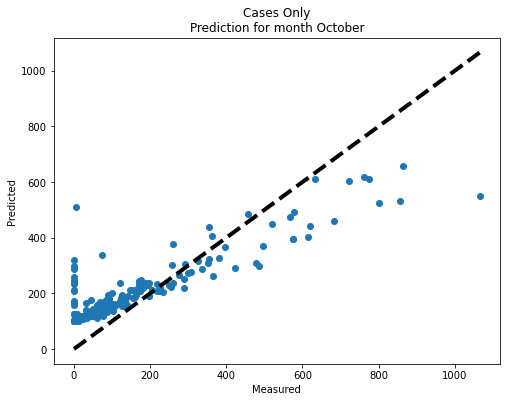

In [1073]:
month_data = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5, False)
train_model_no_transform(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "Cases Only", 5)

### Add Normalization

195
MSE: [9110.348274318347]; avg = 9110.348274318347 
r2: [0.6939661638243627]; avg = 0.6939661638243627
MAE: [53.67019228808267]; avg = 53.67019228808267
avg: [160.03589743589743]; avg = 160.03589743589743


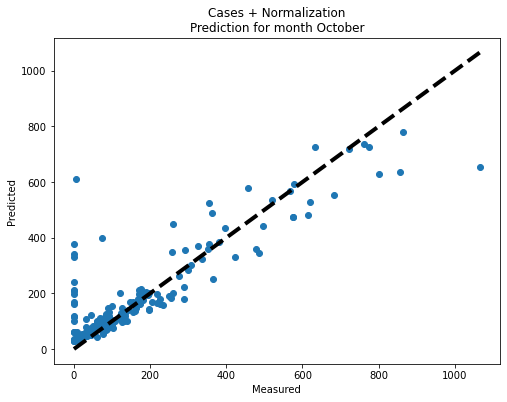

In [846]:
month_data = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "Cases + Normalization", nc5m_pty_arr, 5)

### Add Migration

91
MSE: [5517.830160658644]; avg = 5517.830160658644 
r2: [0.791618471617204]; avg = 0.791618471617204
MAE: [45.04391046366498]; avg = 45.04391046366498
avg: [191.46153846153845]; avg = 191.46153846153845


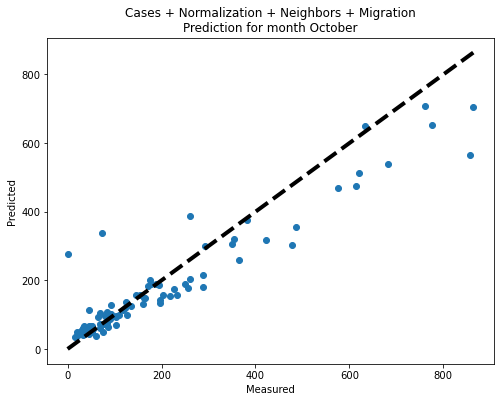

In [847]:
month_data = build_month_data(False, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "Cases + Normalization + Neighbors + Migration", nc5m_pty_arr, 5)

### Add Census

91
MSE: [10387.115575810745]; avg = 10387.115575810745 
r2: [0.777591153947901]; avg = 0.777591153947901
MAE: [60.47288797442872]; avg = 60.47288797442872
avg: [191.46153846153845]; avg = 191.46153846153845


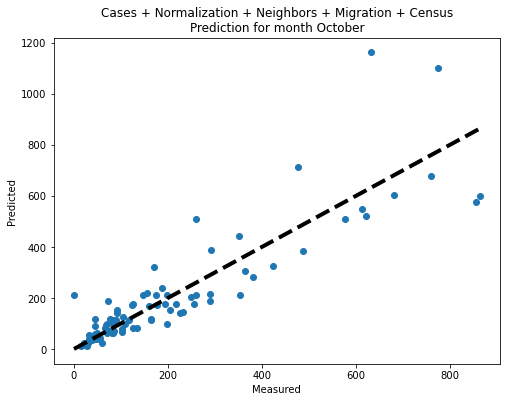

In [848]:
month_data = build_month_data(False, True, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "Cases + Normalization + Neighbors + Migration + Census", nc5m_pty_arr, 5)

### Feature Selection

In [1075]:
month_data = build_month_data(False, True, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
lin_feat_subsets = f_selection(lin_model,nc5m_X_train_arr[0].shape[1],nc5m_X_train_arr[0],nc5m_y_train_arr[0])

91


91
['cases' 'County total cases' 'Incoming migration' 'Outgoing migration'
 'Nursing home density' 'Total jobs' 'Healthcare workers'
 'Food Services workers' '% Area Total: Area (Land)'
 '% Area Total: Area (Water)' '% Total Population: 10 to 14 Years'
 '% Total Population: 18 to 24 Years' '% Total Population: 25 to 34 Years'
 '% Households: Family Households'
 '% Households: Family Households: Married-Couple Family'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present'
 '% Households: Nonfamily Households: Male Householder'
 '% Households: Nonfamily Households: Female Householder'
 '% Population 16 Years and Over: in Labor Force: in Armed Forces'
 '% Population 16 Years and Over: in Labor Force: Civilian'
 '% Population 16 Years and Over: in Labor Force: Civilian: Employed'
 '% In Labor Force 16 Years and Over: in Armed Forces'
 '% In Labor Force 16 Years and Over: Civilian'
 '% Employed Civilian Population 16 Years and Over: Agriculture, Forestry, F

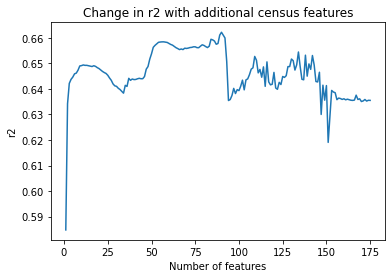

MSE: [10278.978180714785]; avg = 10278.978180714785 
r2: [0.7842868713748505]; avg = 0.7842868713748505
MAE: [59.23689320577352]; avg = 59.23689320577352
avg: [191.46153846153845]; avg = 191.46153846153845


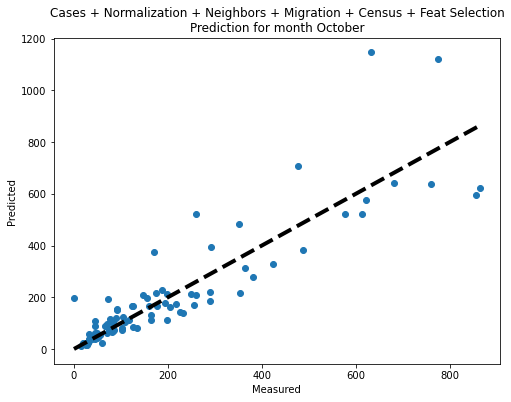

In [1078]:
month_data = build_month_data(False, True, True)
month_data_ws, lin_feat_names = get_fs_data(month_data, lin_feat_subsets)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_ws, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "Cases + Normalization + Neighbors + Migration + Census + Feat Selection", nc5m_pty_arr, 5)

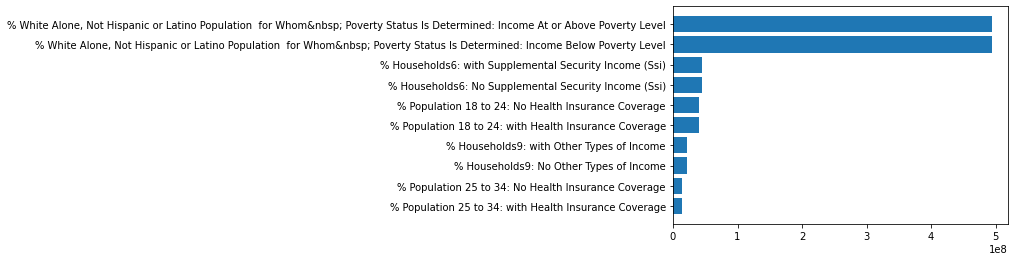

In [1080]:
feat_im_df = f_importances(lin_model, lin_feat_names, 'linear')

In [1081]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [1082]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [1083]:
month_data_ns = build_month_data(False, True)

91


In [1084]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_ns, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_ws, 5)

In [1085]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_ns, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_ws, 4)

In [1086]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

In [1087]:
nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, nc2m_ptX_arr, nc2m_pty_arr = n_month_window_split(month_data_ns, 2)
wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, wc2m_ptX_arr, wc2m_pty_arr = n_month_window_split(month_data_ws, 2)

In [1088]:
nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, nc1m_ptX_arr, nc1m_pty_arr = n_month_window_split(month_data_ns, 1)
wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, wc1m_ptX_arr, wc1m_pty_arr = n_month_window_split(month_data_ws, 1)

/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountere

## 5 month window

MSE: [5517.830160658644]; avg = 5517.830160658644 
r2: [0.791618471617204]; avg = 0.791618471617204
MAE: [45.04391046366498]; avg = 45.04391046366498
avg: [191.46153846153845]; avg = 191.46153846153845


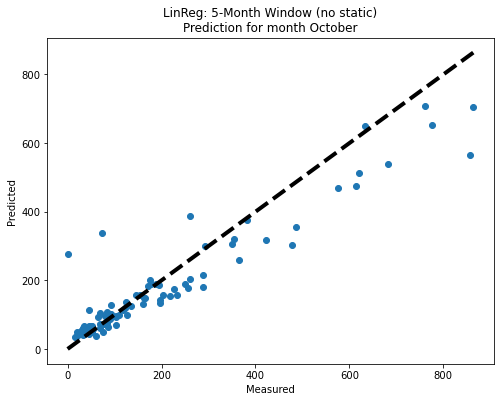

In [1089]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "LinReg: 5-Month Window (no static)", nc5m_pty_arr, 5)

MSE: [10278.978180714785]; avg = 10278.978180714785 
r2: [0.7842868713748505]; avg = 0.7842868713748505
MAE: [59.23689320577352]; avg = 59.23689320577352
avg: [191.46153846153845]; avg = 191.46153846153845


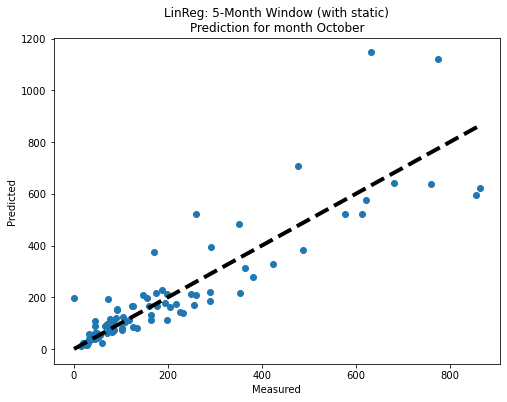

In [1090]:
train_model(wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, lin_model, "LinReg: 5-Month Window (with static)", wc5m_pty_arr, 5)

## 4 month window

MSE: [21832.504863229067, 5130.539028562693]; avg = 13481.52194589588 
r2: [0.6140526018230819, 0.855676800745508]; avg = 0.7348647012842949
MAE: [103.29416521497332, 46.11416177952145]; avg = 74.70416349724738
avg: [142.13186813186815, 191.46153846153845]; avg = 166.7967032967033


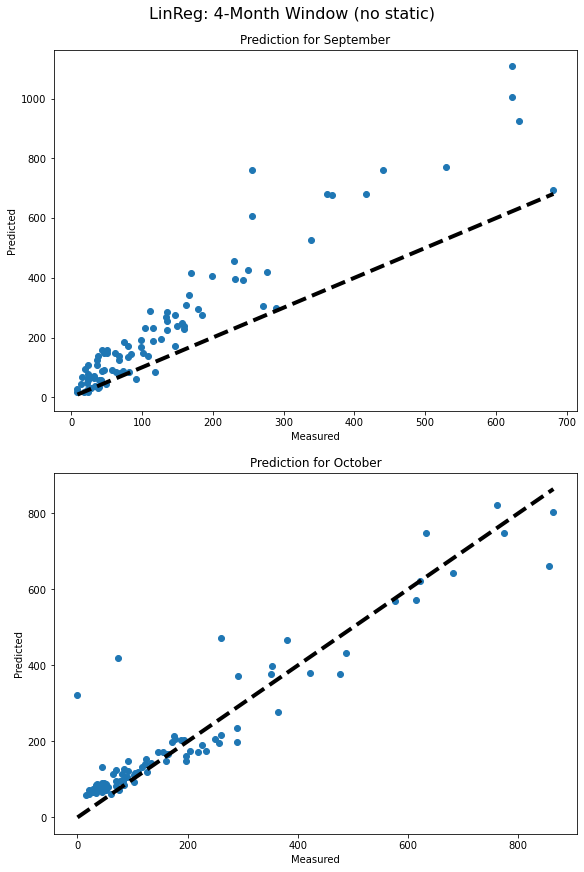

In [1091]:
train_model(nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, lin_model, "LinReg: 4-Month Window (no static)", nc4m_pty_arr, 4)

MSE: [40129.774629784326, 14011.082555523659]; avg = 27070.428592653992 
r2: [0.5029423522189485, 0.7577419653787779]; avg = 0.6303421587988631
MAE: [119.56850433905807, 65.36368105007202]; avg = 92.46609269456505
avg: [142.13186813186815, 191.46153846153845]; avg = 166.7967032967033


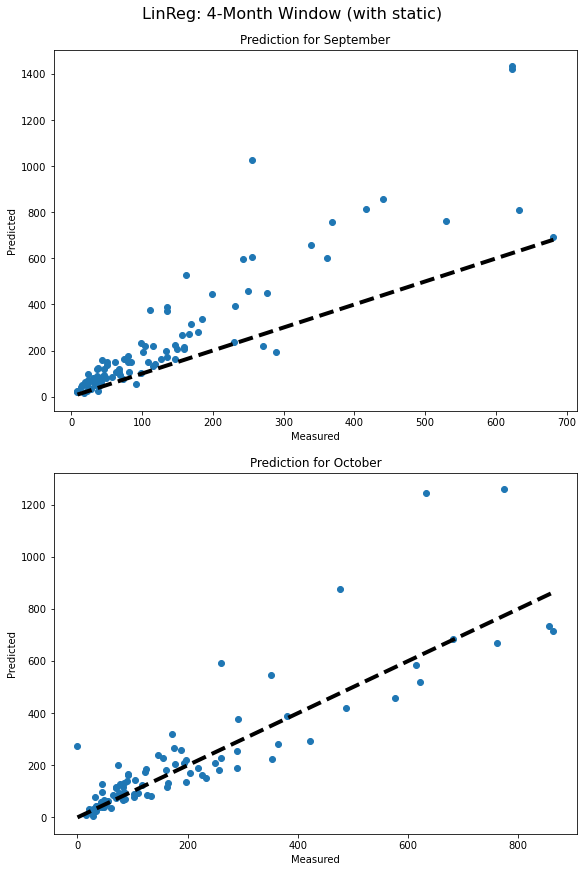

In [1092]:
train_model(wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, lin_model, "LinReg: 4-Month Window (with static)", wc4m_pty_arr, 4)

## 3 month window

MSE: [375693.5305638913, 19705.476325841028, 48884.248167663376]; avg = 148094.41835246523 
r2: [0.1263908851335892, 0.6239469820283818, 0.5083746819156049]; avg = 0.4195708496925253
MAE: [435.0775660447534, 100.37311135880307, 164.01307702028038]; avg = 233.15458480794564
avg: [244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 192.58608058608058


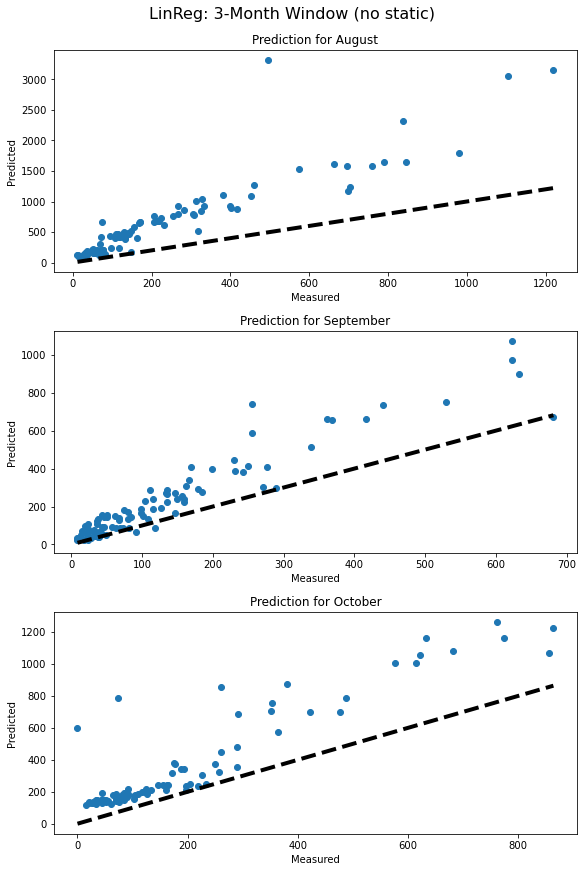

In [1093]:
train_model(nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, lin_model, "LinReg: 3-Month Window (no static)", nc3m_pty_arr, 3)

MSE: [196886.59460350045, 54059.17985777396, 30707.12426767789]; avg = 93884.29957631743 
r2: [0.3329994320957187, 0.44181567411667566, 0.6509161903170839]; avg = 0.47524376550982605
MAE: [324.99120835680867, 134.7631671386262, 88.50495618459402]; avg = 182.75311056000962
avg: [244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 192.58608058608058


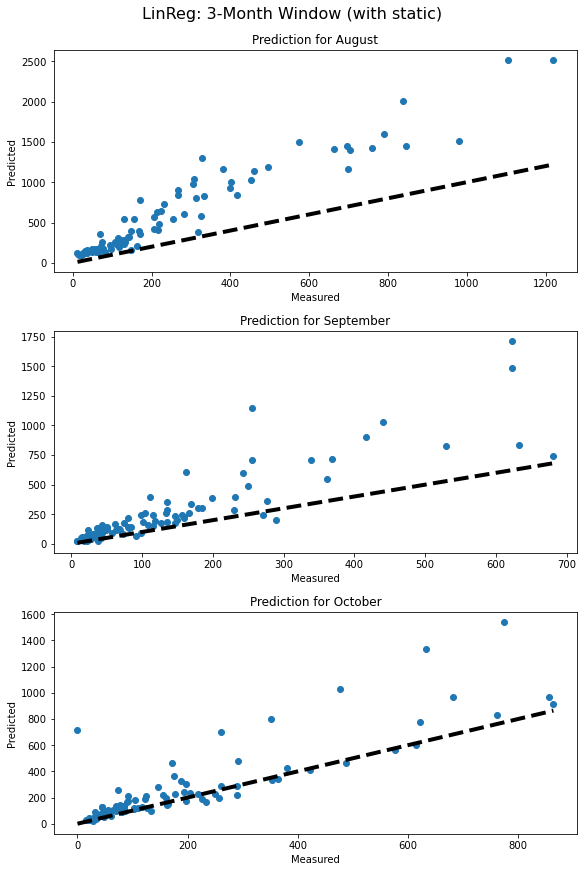

In [1094]:
train_model(wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, lin_model, "LinReg: 3-Month Window (with static)", wc3m_pty_arr, 3)

## 2 month window

MSE: [64038.834853894376, 745477.0874891983, 83441.34096232193, 32979.75474689474]; avg = 231484.25451307735 
r2: [0.35955435076978937, -0.3095225339986165, 0.20201287461598316, -5.194005064498069]; avg = -1.2354900932777282
MAE: [109.40124236579675, 682.798641443936, 216.72189065704052, 121.32644919696459]; avg = 282.5620559159345
avg: [362.83516483516485, 244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 235.14835164835165


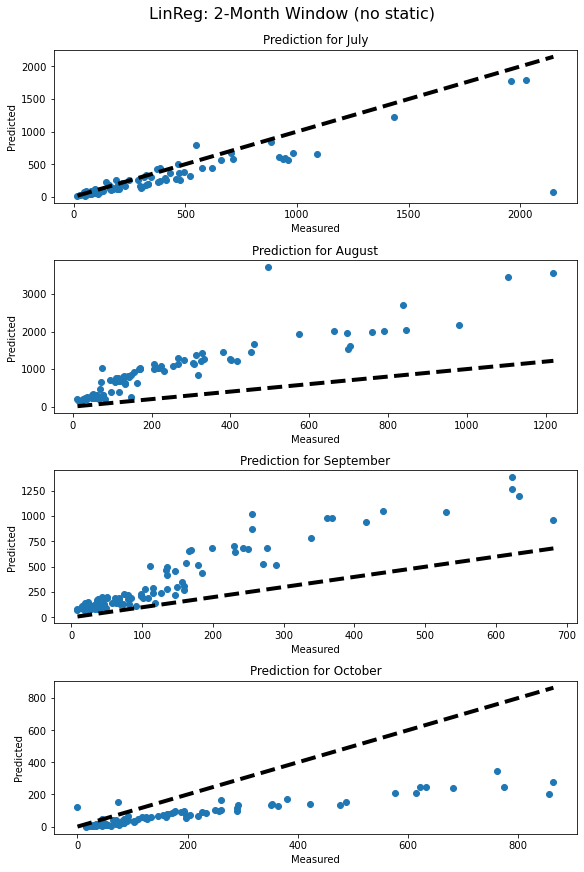

In [1095]:
train_model(nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, lin_model, "LinReg: 2-Month Window (no static)", nc2m_pty_arr, 2)

MSE: [64006.30369755727, 502304.8838180152, 88330.13462604526, 23038.303594898196]; avg = 169419.906434129 
r2: [0.32523087467505885, -0.09239363368003972, 0.2942546757336184, -0.9479243885540396]; avg = -0.10520811795635052
MAE: [112.34044870066768, 556.6733344030574, 188.9224051244475, 107.48589396281362]; avg = 241.35552054774655
avg: [362.83516483516485, 244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 235.14835164835165


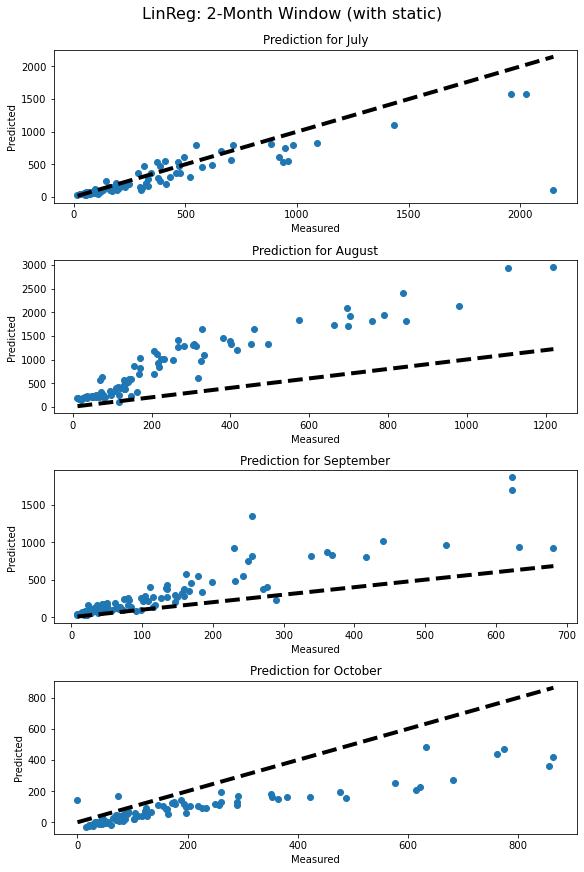

In [1096]:
train_model(wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, lin_model, "LinReg: 2-Month Window (with static)", wc2m_pty_arr, 2)

## 1 month window

MSE: [4.952254322051067e+48, 4.0135879797857417e+52, 6.316857838217442e+42, 3325.0473286318856, 28152.438599943474]; avg = 8.028166411699266e+51 
r2: [-7.636259405750749e+30, -3.39964125558235e+31, -5.745148735711557e+30, 0.8755980644045191, -3.417531100058305]; avg = -9.475564139457161e+30
MAE: [2.2253661096662422e+24, 2.003394114942375e+26, 2.51333599787562e+21, 38.00356451843536, 109.44304030644713]; avg = 4.051345818798033e+25
avg: [205.01098901098902, 362.8351648351649, 244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 229.12087912087912


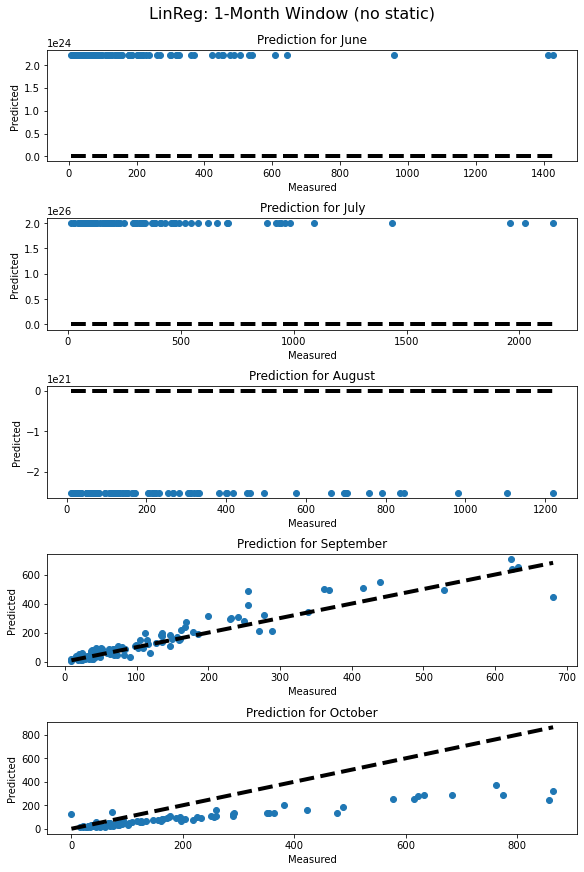

In [1097]:
train_model(nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, lin_model, "LinReg: 1-Month Window (no static)", nc1m_pty_arr, 1)

MSE: [5.697451881618101e+93, 5.20111012764841e+98, 3.626030429980969e+92, 3274268103763.2534, 2462892726.136291]; avg = 1.0402341456395313e+98 
r2: [-1.3849738321948497e+31, -1.9291989675876123e+31, -1.410302672735061e+31, -673700.8379424363, -4030.9982240266454]; avg = -9.448950945035046e+30
MAE: [7.548146714007417e+46, 2.2805942487975394e+49, 1.9042138614086838e+46, 1809492.6886446446, 49623.642349301386]; avg = 4.5800932187459105e+48
avg: [205.01098901098902, 362.8351648351649, 244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 229.12087912087912


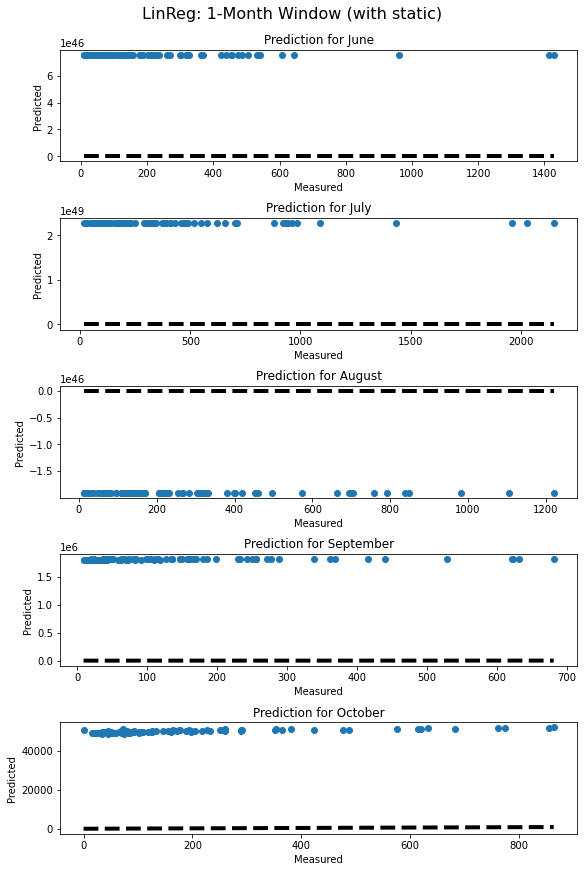

In [1098]:
train_model(wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, lin_model, "LinReg: 1-Month Window (with static)", wc1m_pty_arr, 1)

# SVR

In [71]:
svr_params = {
    'C': 1,
    'gamma': 0.0001,
    'kernel': 'linear',
}

# svr_params = {
#     'C': 1,
#     'gamma': 0.5,
#     'kernel': 'linear',
# }
svr_model = SVR(**svr_params)

### Cases Only

195
MSE: [70270.66061198719]; avg = 70270.66061198719 
r2: [-11.39244707990822]; avg = -11.39244707990822
MAE: [248.04136522674474]; avg = 248.04136522674474
avg: [160.03589743589743]; avg = 160.03589743589743


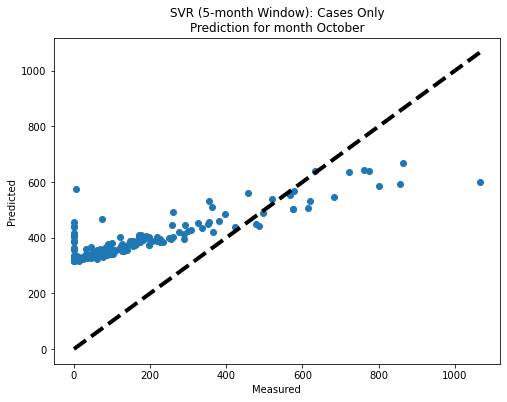

In [72]:
month_data = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5, False)
train_model_no_transform(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR (5-month Window): Cases Only", 5)

### Add Normalization

195
MSE: [8853.113618216521]; avg = 8853.113618216521 
r2: [0.701583172374949]; avg = 0.701583172374949
MAE: [51.908716460740706]; avg = 51.908716460740706
avg: [160.03589743589743]; avg = 160.03589743589743


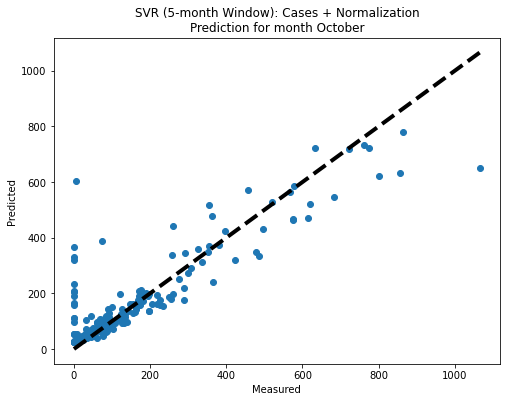

In [73]:
month_data = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR (5-month Window): Cases + Normalization", nc5m_pty_arr, 5)

### Add Migration

91
MSE: [5572.850365295737]; avg = 5572.850365295737 
r2: [0.7943556625127766]; avg = 0.7943556625127766
MAE: [45.34599369349803]; avg = 45.34599369349803
avg: [191.46153846153845]; avg = 191.46153846153845


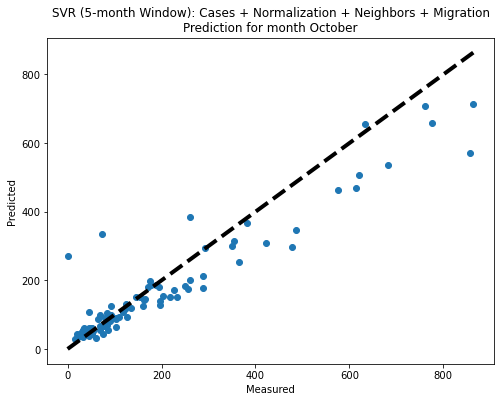

In [74]:
month_data = build_month_data(False, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR (5-month Window): Cases + Normalization + Neighbors + Migration", nc5m_pty_arr, 5)

### Add Census

91
MSE: [10939.090762475487]; avg = 10939.090762475487 
r2: [0.7284134873782852]; avg = 0.7284134873782852
MAE: [62.99251977809557]; avg = 62.99251977809557
avg: [191.46153846153845]; avg = 191.46153846153845


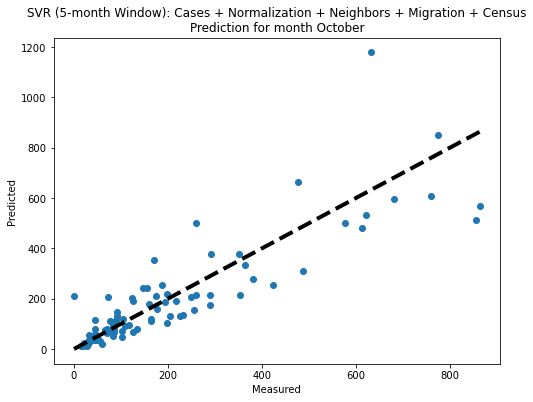

In [75]:
month_data = build_month_data(False, True, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR (5-month Window): Cases + Normalization + Neighbors + Migration + Census", nc5m_pty_arr, 5)

### Feature Selection

In [1123]:
# month_data = build_month_data(False, True, True)
# nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
# svr_feat_subsets = f_selection(svr_model,nc5m_X_train_arr[0].shape[1],nc5m_X_train_arr[0],nc5m_y_train_arr[0])

In [1124]:
# np.save('../data/svr_feat_subsets.npy',svr_feat_subsets, allow_pickle=True)

In [33]:
svr_feat_subsets = np.load('../data/svr_feat_subsets.npy', allow_pickle=True)[()]

91
['cases' 'County total cases' 'Incoming migration' 'Outgoing migration'
 'Nursing home density' 'Total jobs'
 '% Workers 16 Years and Over2: Did Not Work At Home: Less than 10 Minutes'
 '% Total Population: 35 to 44 Years'
 '% Population 25 to 34: with Health Insurance Coverage: Public Health Coverage'
 '% Population 16 Years and Over: in Labor Force: Civilian: Unemployed'
 '% Households2: with Wage or Salary Income'
 '% Households10: 1-Person Household'
 '% American Indian and Alaska Native Alone  Population For&nbsp; Whom Poverty Status Is Determined: Income At or Above Poverty Level'
 '% Native Hawaiian and Other Pacific Islander Alone &nbsp; Population for Whom Poverty Status Is Determined: Income At or Above Poverty Level'
 '% Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance'
 '% Employed Civilian Population 16 Years and Over1: Private Non-Profit'
 '% Workers 16 Years and Over: Motorcycle']


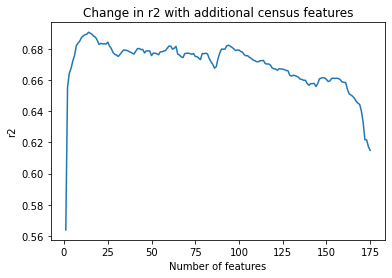

MSE: [9752.20240765371]; avg = 9752.20240765371 
r2: [0.7015956598932814]; avg = 0.7015956598932814
MAE: [61.69966364890514]; avg = 61.69966364890514
avg: [191.46153846153845]; avg = 191.46153846153845


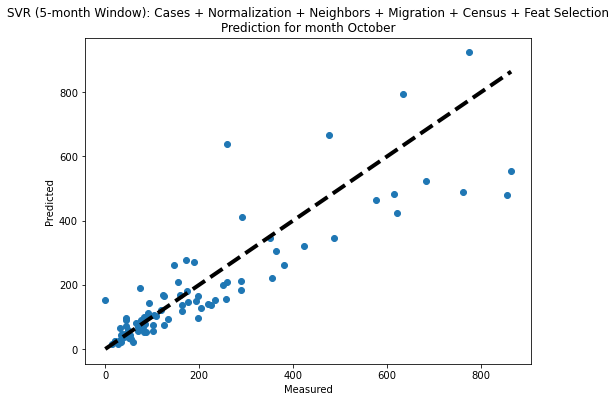

In [65]:
month_data = build_month_data(False, True, True)
month_data_ws, svr_feat_names = get_fs_data(month_data, svr_feat_subsets)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_ws, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR (5-month Window): Cases + Normalization + Neighbors + Migration + Census + Feat Selection", nc5m_pty_arr, 5)

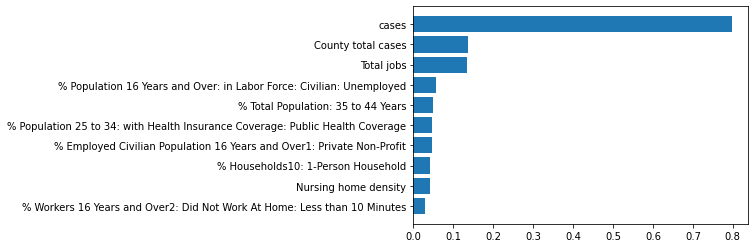

In [35]:
feat_im_df = f_importances(svr_model, svr_feat_names, 'SVR')

In [36]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [37]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [58]:
svr_param_grid = {
    'C':[1,5,10,20,30,50],
    'gamma': [10,5, 1, 0.01, 0.0001],
    'kernel': ['linear']
}

svr_model = SVR()
svr_search = GridSearchCV(svr_model, svr_param_grid)

MSE: 0.14884485262746078 
r2: 0.7906291759995967 
MAE: 0.257474924689534 
avg: -0.08040828841961946


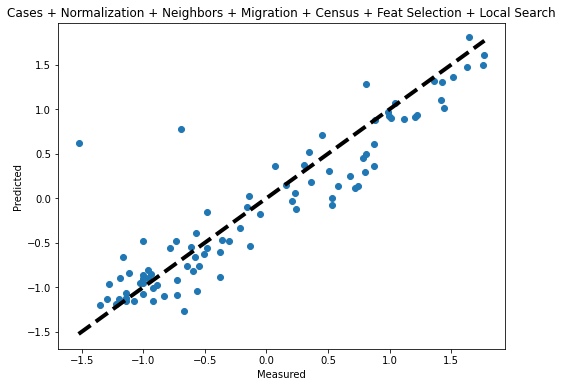

SVR(C=5, gamma=10, kernel='linear')


In [61]:
search_model(nc5m_X_train_arr[0], nc5m_X_test_arr[0], nc5m_y_train_arr[0], nc5m_y_test_arr[0], svr_search, "Cases + Normalization + Neighbors + Migration + Census + Feat Selection + Local Search")

In [57]:
gb_search.best_estimator_

SVR(C=50, gamma=0.0001)

In [1056]:
month_data_ns = build_month_data(False, True)

91


In [1057]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_ns, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_ws, 5)

In [1058]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_ns, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_ws, 4)

In [1059]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

In [1060]:
nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, nc2m_ptX_arr, nc2m_pty_arr = n_month_window_split(month_data_ns, 2)
wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, wc2m_ptX_arr, wc2m_pty_arr = n_month_window_split(month_data_ws, 2)

In [1061]:
nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, nc1m_ptX_arr, nc1m_pty_arr = n_month_window_split(month_data_ns, 1)
wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, wc1m_ptX_arr, wc1m_pty_arr = n_month_window_split(month_data_ws, 1)

/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountere

## 5 month window

MSE: [5572.850365295737]; avg = 5572.850365295737 
r2: [0.7943556625127766]; avg = 0.7943556625127766
MAE: [45.34599369349803]; avg = 45.34599369349803
avg: [191.46153846153845]; avg = 191.46153846153845


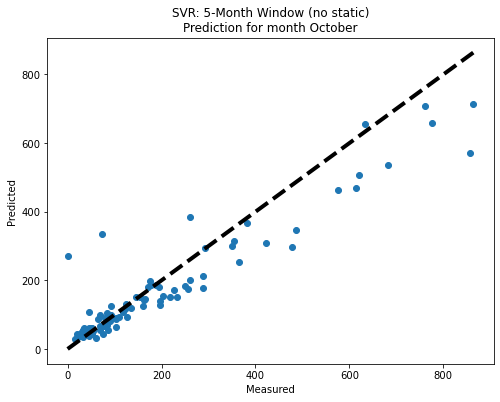

In [1062]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR: 5-Month Window (no static)", nc5m_pty_arr, 5)

MSE: [5672.647340684524]; avg = 5672.647340684524 
r2: [0.8169107508750693]; avg = 0.8169107508750693
MAE: [47.38315166671842]; avg = 47.38315166671842
avg: [191.46153846153845]; avg = 191.46153846153845


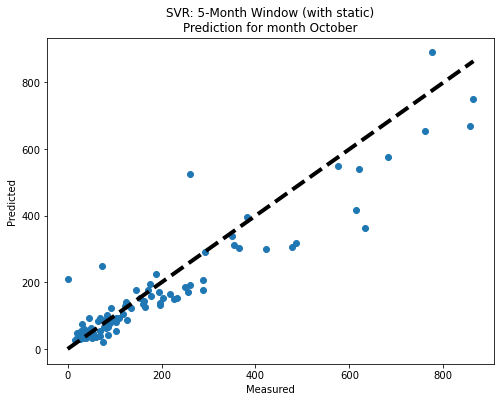

In [1063]:
train_model(wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, svr_model, "SVR: 5-Month Window (with static)", wc5m_pty_arr, 5)

## 4 month window

MSE: [23040.661730326796, 5222.455068447241]; avg = 14131.558399387019 
r2: [0.6175204891100375, 0.8305160366677737]; avg = 0.7240182628889056
MAE: [103.11713823216432, 45.50464077051327]; avg = 74.31088950133879
avg: [142.13186813186815, 191.46153846153845]; avg = 166.7967032967033


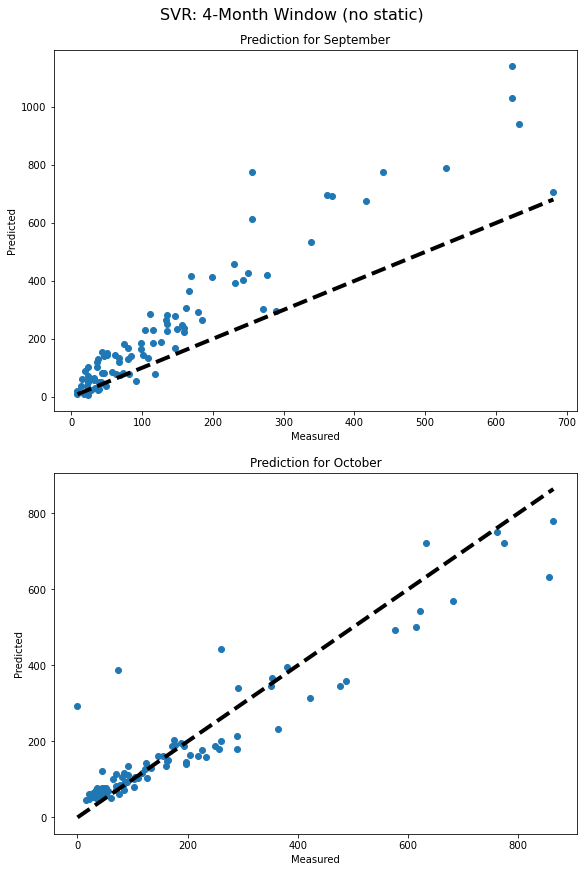

In [1064]:
train_model(nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, svr_model, "SVR: 4-Month Window (no static)", nc4m_pty_arr, 4)

MSE: [26744.21695049821, 5007.486056720888]; avg = 15875.851503609549 
r2: [0.5818218072163883, 0.860134570162294]; avg = 0.7209781886893412
MAE: [103.46551346815461, 44.86419866556917]; avg = 74.16485606686189
avg: [142.13186813186815, 191.46153846153845]; avg = 166.7967032967033


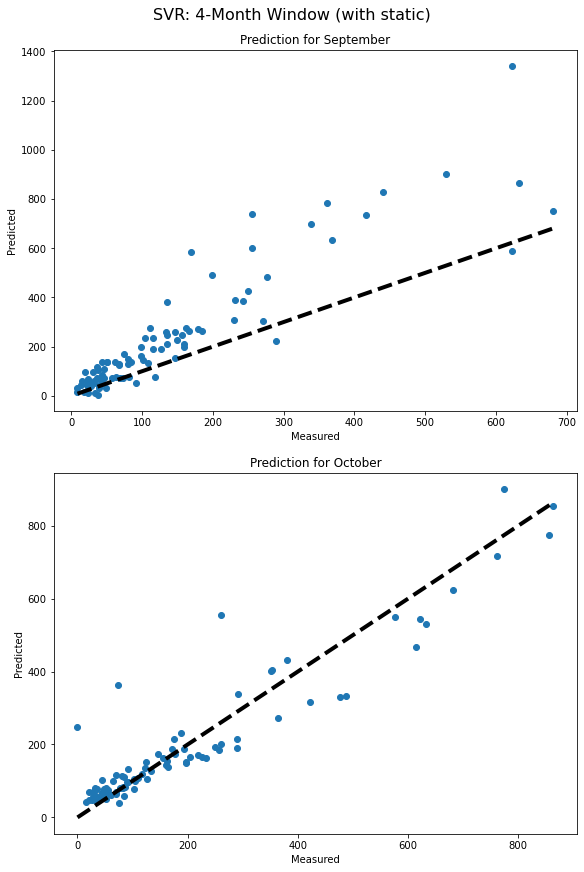

In [1065]:
train_model(wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, svr_model, "SVR: 4-Month Window (with static)", wc4m_pty_arr, 4)

## 3 month window

MSE: [380620.17674174637, 20899.987462813984, 43887.98328687147]; avg = 148469.38249714393 
r2: [0.10868759324395116, 0.6339261662365292, 0.5591078350594947]; avg = 0.43390719817999174
MAE: [444.6905023071209, 98.73454200537944, 148.1495477536304]; avg = 230.52486402204354
avg: [244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 192.58608058608058


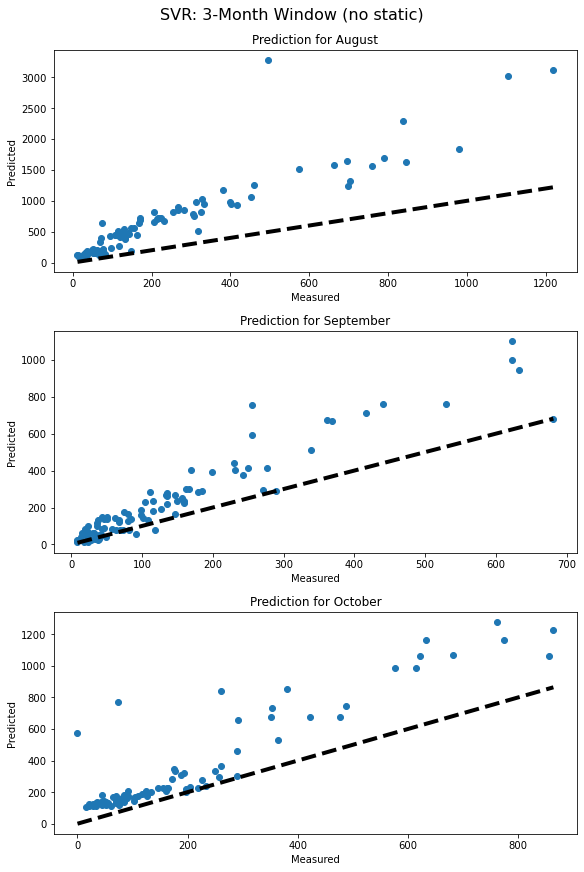

In [1066]:
train_model(nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, svr_model, "SVR: 3-Month Window (no static)", nc3m_pty_arr, 3)

MSE: [324523.5940328285, 26405.949967266497, 50139.89585184956]; avg = 133689.81328398152 
r2: [0.19489453585619843, 0.5858540813937435, 0.5475275400254537]; avg = 0.44275871909179854
MAE: [404.1083261664275, 105.7741738150888, 155.62816689201284]; avg = 221.83688895784303
avg: [244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 192.58608058608058


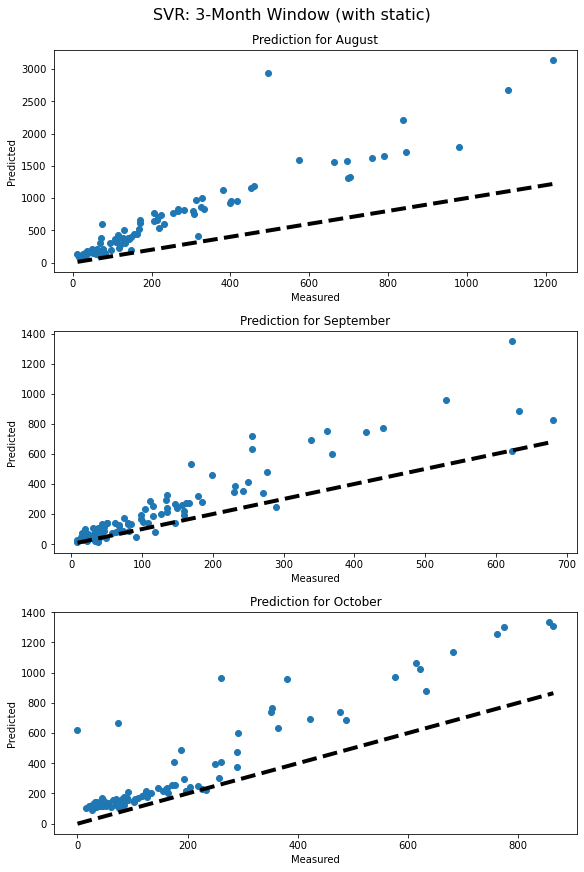

In [1067]:
train_model(wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, svr_model, "SVR: 3-Month Window (with static)", wc3m_pty_arr, 3)

## 2 month window

MSE: [67082.18634789884, 672175.7845441425, 85520.36249534457, 32697.825502118045]; avg = 214369.039722376 
r2: [0.2578042718311626, -0.2287726258198619, 0.2307953118716971, -4.8930717988546]; avg = -1.1583112102429005
MAE: [115.33276773607429, 640.330596473859, 213.23434749324383, 122.15864141979743]; avg = 272.76408828074364
avg: [362.83516483516485, 244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 235.14835164835165


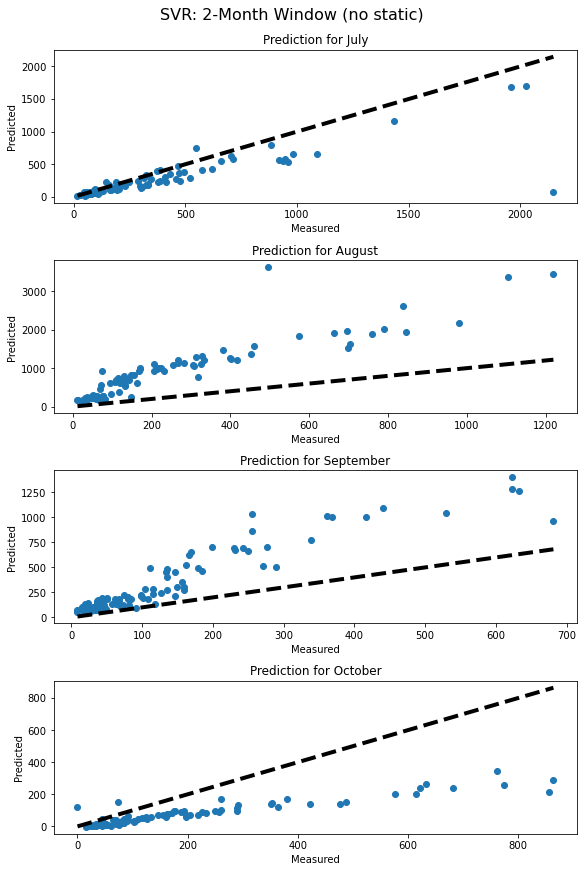

In [1068]:
train_model(nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, svr_model, "SVR: 2-Month Window (no static)", nc2m_pty_arr, 2)

MSE: [70324.00751373201, 646680.8846042481, 82115.35993264726, 32563.727102797948]; avg = 207920.99478835636 
r2: [0.22761323790874655, -0.17030513916960244, 0.26160493056304746, -4.318049814426482]; avg = -0.9997841962810726
MAE: [118.94695203279137, 620.9714853840346, 203.74285710100386, 125.35009422621714]; avg = 267.25284718601176
avg: [362.83516483516485, 244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 235.14835164835165


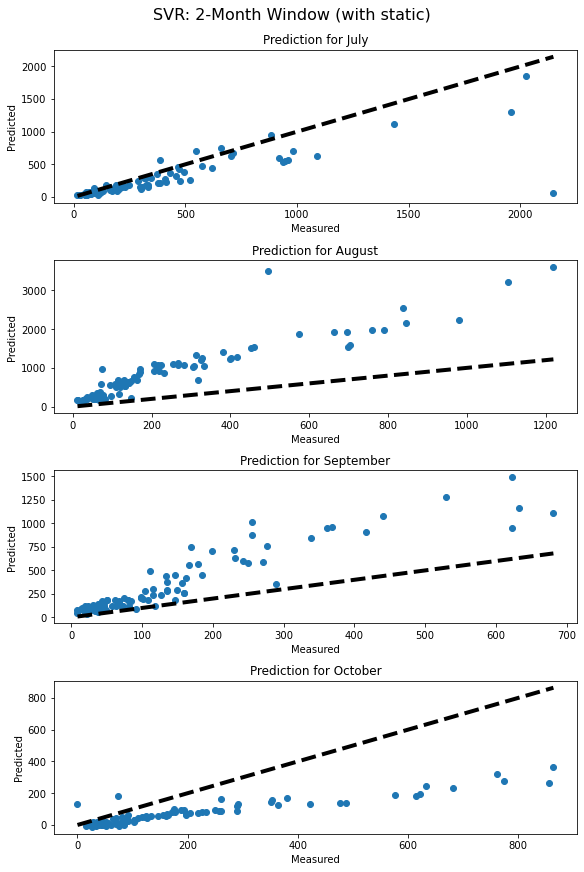

In [1069]:
train_model(wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, svr_model, "SVR: 2-Month Window (with static)", wc2m_pty_arr, 2)

## 1 month window

MSE: [12211.459244859085, 69856.93731615703, 230269.75574570996, 4094.1566370381197, 29129.65743002625]; avg = 69112.3932747581 
r2: [0.8340827026104971, 0.24799197969514886, 0.3199089649256247, 0.8692680226907785, -3.827999324748392]; avg = -0.3113495309652685
MAE: [65.5104675229663, 123.51078118867892, 316.5146619271738, 41.77959124891346, 111.6474711403567]; avg = 131.79259460561784
avg: [205.01098901098902, 362.8351648351649, 244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 229.12087912087912


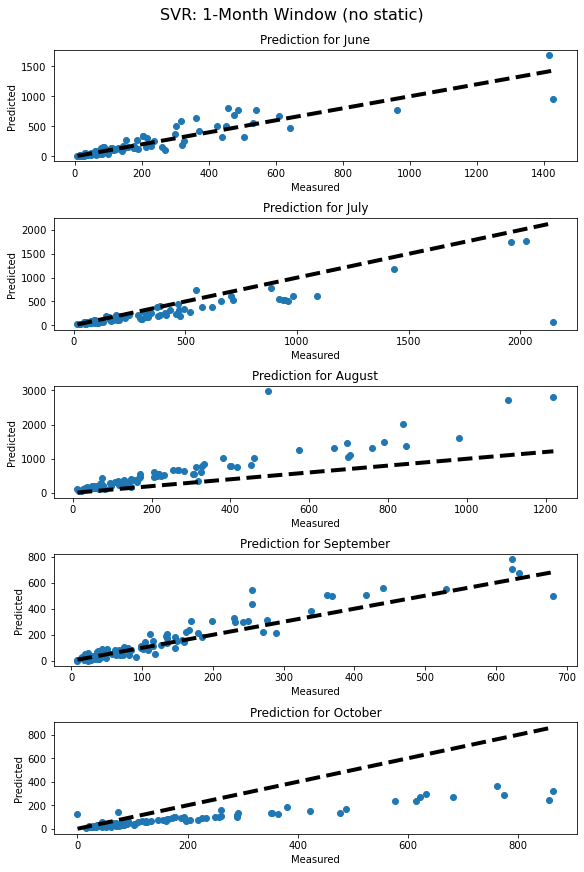

In [1070]:
train_model(nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, svr_model, "SVR: 1-Month Window (no static)", nc1m_pty_arr, 1)

MSE: [12164.23472391411, 69261.38526733808, 212022.91620337588, 6081.380988837018, 26105.099643704558]; avg = 65127.00336543393 
r2: [0.7886385293867517, 0.28984224909644973, 0.36286763171366865, 0.8201143195346097, -2.1539712411007885]; avg = 0.021498297726138205
MAE: [65.01764652822135, 118.46459200852927, 294.9048407016556, 50.5667296135816, 108.34291548370025]; avg = 127.45934486713762
avg: [205.01098901098902, 362.8351648351649, 244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 229.12087912087912


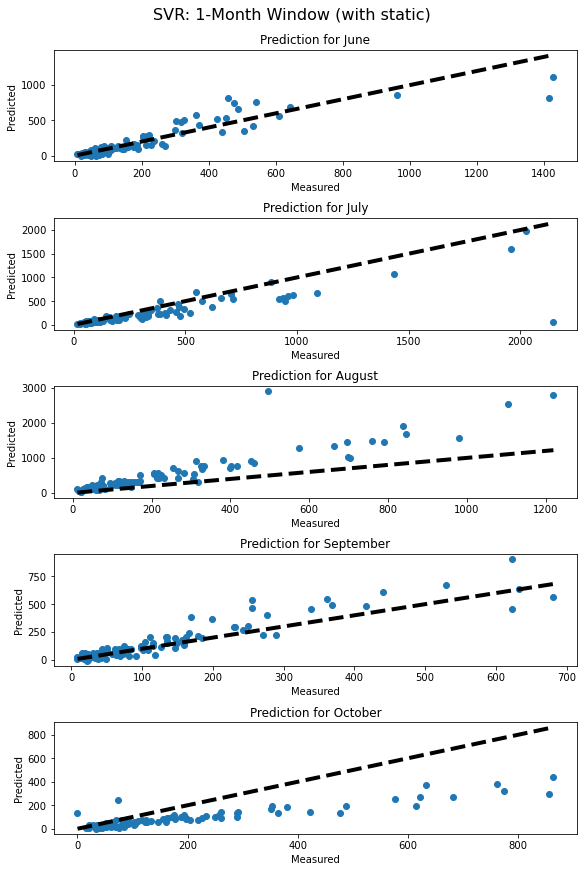

In [1071]:
train_model(wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, svr_model, "SVR: 1-Month Window (with static)", wc1m_pty_arr, 1)

# GBR

In [978]:
gb_param = {
#     'n_estimators': 700,
#     'max_depth': 16,
#     'min_samples_split': 100,
#     'learning_rate': 0.01,
#     'loss': 'ls'
}
gb_model = GradientBoostingRegressor(**gb_param)

### Cases Only

195
MSE: [12544.071372543156]; avg = 12544.071372543156 
r2: [0.749915309582881]; avg = 0.749915309582881
MAE: [62.94000478474418]; avg = 62.94000478474418
avg: [160.03589743589743]; avg = 160.03589743589743


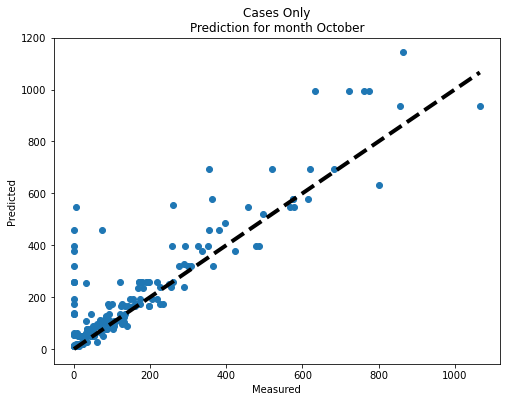

In [952]:
month_data = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5, False)
train_model_no_transform(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "Cases Only", 5)

### Add Normalization

195
MSE: [10958.868301862525]; avg = 10958.868301862525 
r2: [0.7681583353273306]; avg = 0.7681583353273306
MAE: [58.31613825557543]; avg = 58.31613825557543
avg: [160.03589743589743]; avg = 160.03589743589743


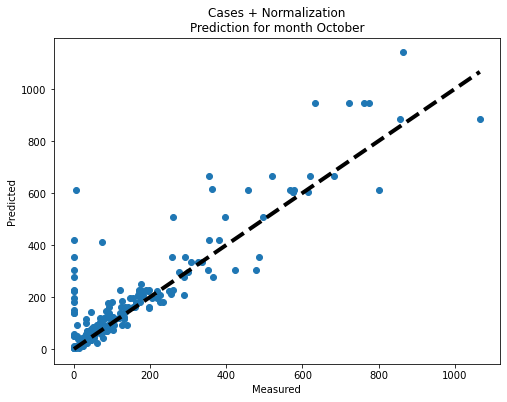

In [953]:
month_data = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "Cases + Normalization", nc5m_pty_arr, 5)

### Add Migration

91
MSE: [6557.578536310201]; avg = 6557.578536310201 
r2: [0.8077758350464095]; avg = 0.8077758350464095
MAE: [49.1262961663066]; avg = 49.1262961663066
avg: [191.46153846153845]; avg = 191.46153846153845


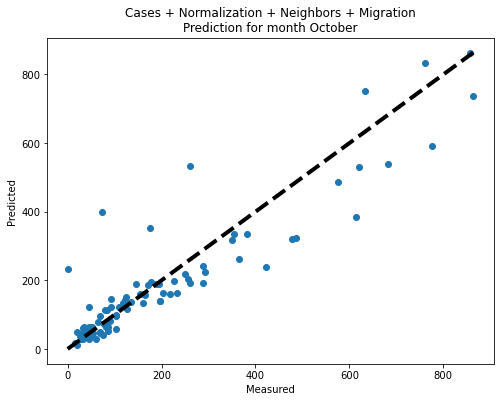

In [954]:
month_data = build_month_data(False, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "Cases + Normalization + Neighbors + Migration", nc5m_pty_arr, 5)

### Add Census

91
MSE: [9270.02567079764]; avg = 9270.02567079764 
r2: [0.782520167325838]; avg = 0.782520167325838
MAE: [51.34839059960357]; avg = 51.34839059960357
avg: [191.46153846153845]; avg = 191.46153846153845


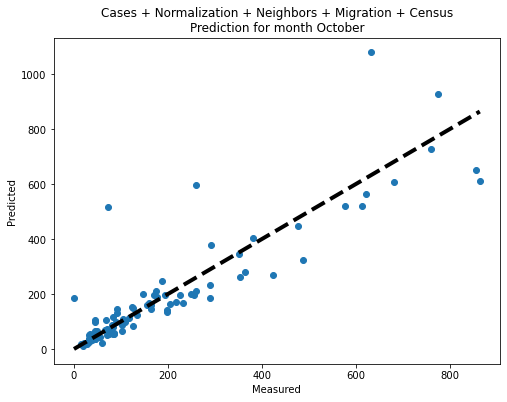

In [955]:
month_data = build_month_data(False, True, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "Cases + Normalization + Neighbors + Migration + Census", nc5m_pty_arr, 5)

### Feature Selection

In [865]:
# month_data = build_month_data(False, True, True)
# nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
# lin_feat_subsets = f_selection(lin_model,nc5m_X_train_arr[0].shape[1],nc5m_X_train_arr[0],nc5m_y_train_arr[0])

91


91
['cases' 'County total cases' 'Incoming migration' 'Outgoing migration'
 'Nursing home density' 'Healthcare workers' 'Food Services workers'
 '% Area Total: Area (Land)' '% Area Total: Area (Water)'
 '% Total Population: 10 to 14 Years' '% Total Population: 15 to 17 Years'
 '% Total Population: 55 to 64 Years' '% Households: Family Households'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present'
 '% Households: Nonfamily Households'
 '% Households: Nonfamily Households: Male Householder'
 '% Households: Nonfamily Households: Female Householder'
 '% Population 16 Years and Over: in Labor Force'
 '% Population 16 Years and Over: in Labor Force: Civilian'
 '% Population 16 Years and Over: in Labor Force: Civilian: Employed'
 '% Population 16 Years and Over: in Labor Force: Civilian: Unemployed'
 '% Population 16 Years and Over: Not in Labor Force'
 '% Employed Civilian Population 16 Years and Over: Construction'
 '% Employed Civilian Population 16 Ye

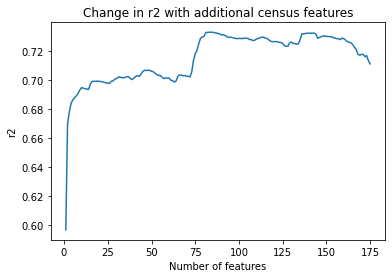

MSE: [7574.536332556279]; avg = 7574.536332556279 
r2: [0.8250425200835456]; avg = 0.8250425200835456
MAE: [48.161800493392306]; avg = 48.161800493392306
avg: [191.46153846153845]; avg = 191.46153846153845


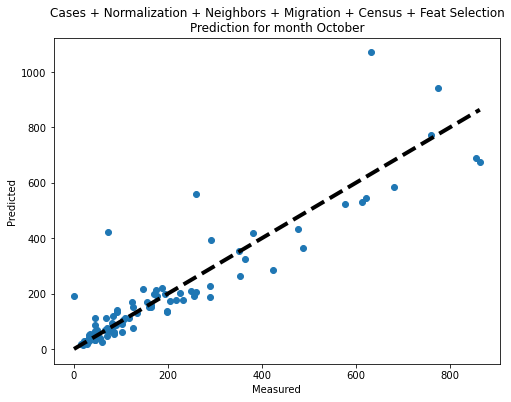

In [996]:
month_data = build_month_data(False, True, True)
month_data_ws, svr_feat_names = get_fs_data(month_data, svr_feat_subsets)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_ws, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "Cases + Normalization + Neighbors + Migration + Census + Feat Selection", nc5m_pty_arr, 5)

In [995]:
gb_param_grid = {
   'n_estimators': [100, 500, 1000],
    'max_depth': [2, 6, 10, 16],
    'min_samples_split': [2, 10, 50],
}

gb_model = GradientBoostingRegressor()
gb_search = GridSearchCV(gb_model, gb_param_grid)

MSE: [6703.1757411351045]; avg = 6703.1757411351045 
r2: [0.8341364674421621]; avg = 0.8341364674421621
MAE: [46.59881386384879]; avg = 46.59881386384879
avg: [191.46153846153845]; avg = 191.46153846153845


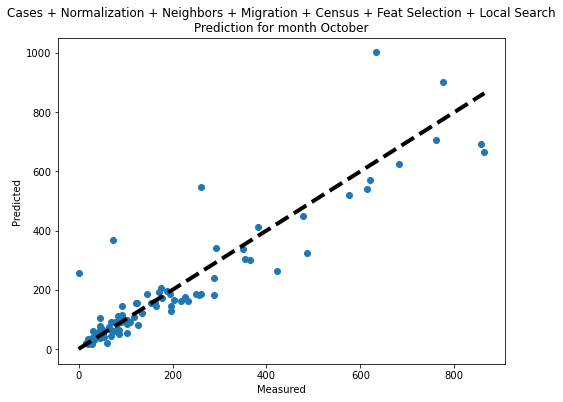

In [997]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_search, "Cases + Normalization + Neighbors + Migration + Census + Feat Selection + Local Search", nc5m_pty_arr, 5)

In [998]:
gb_search.best_estimator_

GradientBoostingRegressor(max_depth=2, min_samples_split=50)

### Feature Importance

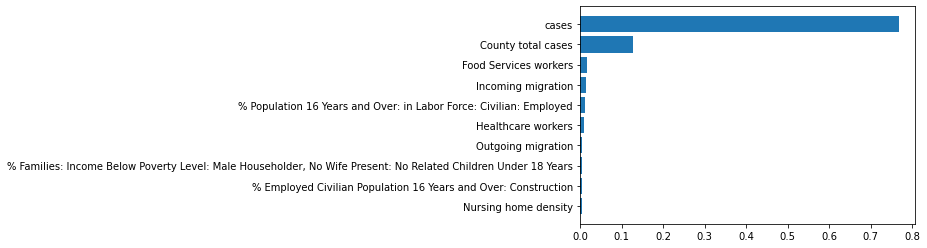

In [992]:
feat_im_df = f_importances(gb_model, svr_feat_names, 'GBR')

In [993]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [994]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [965]:
month_data_ns = build_month_data(False, True)

91


In [966]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_ns, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_ws, 5)

In [967]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_ns, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_ws, 4)

In [968]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

In [969]:
nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, nc2m_ptX_arr, nc2m_pty_arr = n_month_window_split(month_data_ns, 2)
wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, wc2m_ptX_arr, wc2m_pty_arr = n_month_window_split(month_data_ws, 2)

In [970]:
nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, nc1m_ptX_arr, nc1m_pty_arr = n_month_window_split(month_data_ns, 1)
wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, wc1m_ptX_arr, wc1m_pty_arr = n_month_window_split(month_data_ws, 1)

/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountere

In [1034]:
gb_param = {
    'max_depth': 2,
    'min_samples_split': 50,
}
gb_model = GradientBoostingRegressor(**gb_param)

## 5 month window

MSE: [6703.1757411351045]; avg = 6703.1757411351045 
r2: [0.8341364674421621]; avg = 0.8341364674421621
MAE: [46.59881386384879]; avg = 46.59881386384879
avg: [191.46153846153845]; avg = 191.46153846153845


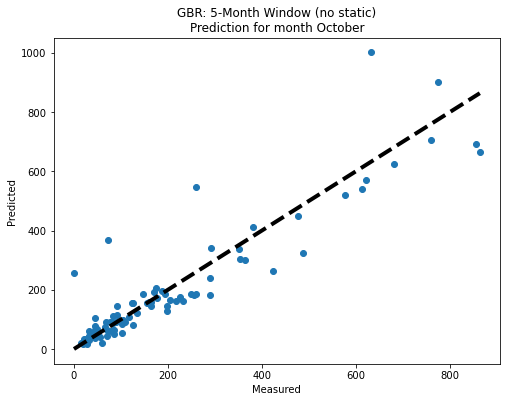

In [1035]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "GBR: 5-Month Window (no static)", nc5m_pty_arr, 5)

MSE: [6703.1757411351045]; avg = 6703.1757411351045 
r2: [0.8341364674421621]; avg = 0.8341364674421621
MAE: [46.59881386384879]; avg = 46.59881386384879
avg: [191.46153846153845]; avg = 191.46153846153845


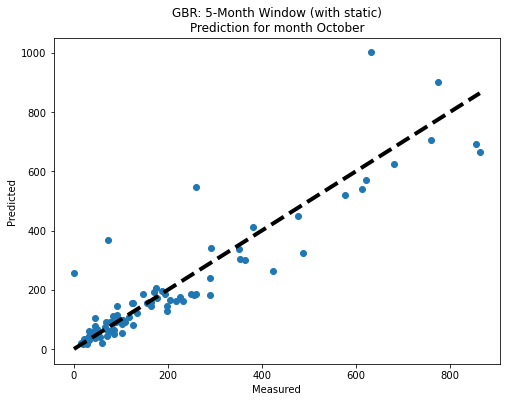

In [1036]:
train_model(wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, gb_model, "GBR: 5-Month Window (with static)", wc5m_pty_arr, 5)

## 4 month window

MSE: [100800.59953601744, 6981.758862995109]; avg = 53891.179199506274 
r2: [0.21596898606350245, 0.8230402421146166]; avg = 0.5195046140890596
MAE: [226.89005496853412, 49.94894355570946]; avg = 138.4194992621218
avg: [142.13186813186815, 191.46153846153845]; avg = 166.7967032967033


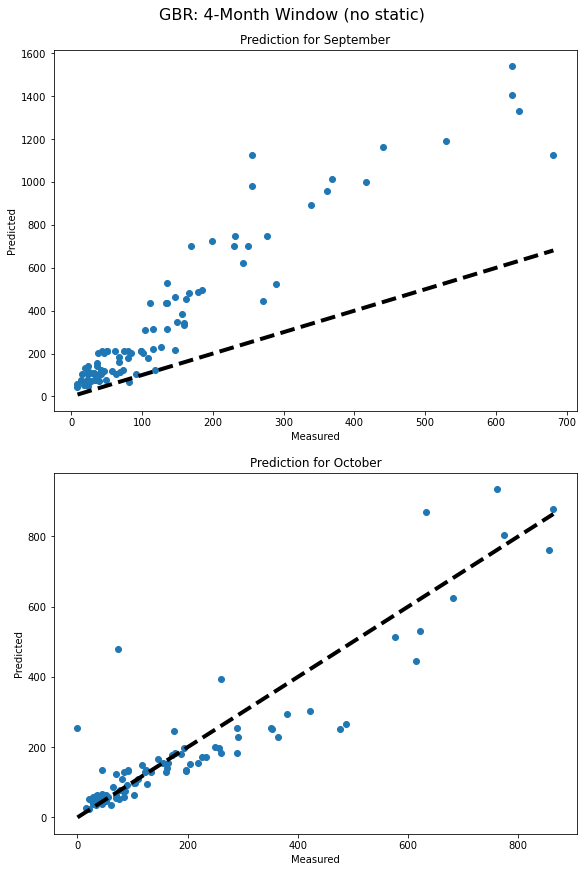

In [1020]:
train_model(nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, gb_model, "GBR: 4-Month Window (no static)", nc4m_pty_arr, 4)

MSE: [111878.56067910905, 5349.283425046406]; avg = 58613.92205207773 
r2: [0.19062335202409153, 0.8562443491101728]; avg = 0.5234338505671321
MAE: [229.81930526508597, 46.010397484690166]; avg = 137.91485137488806
avg: [142.13186813186815, 191.46153846153845]; avg = 166.7967032967033


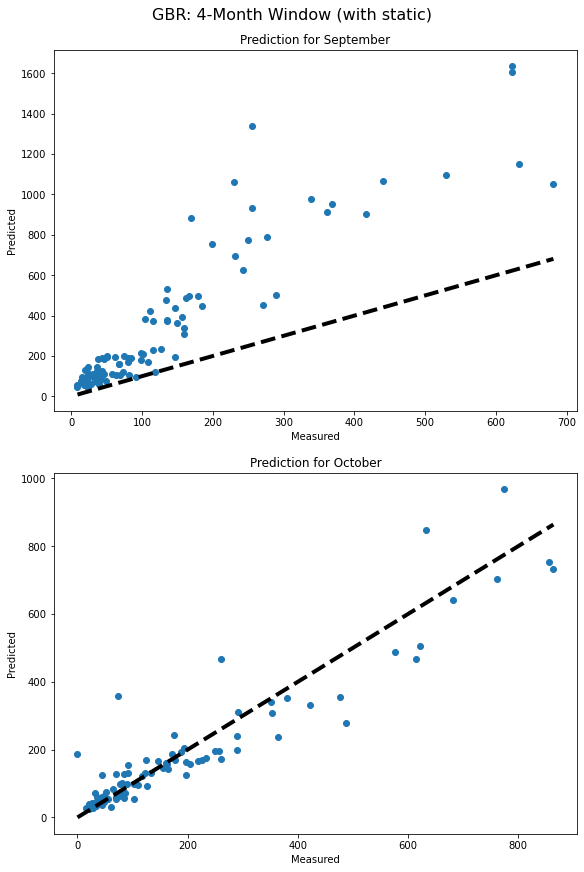

In [1021]:
train_model(wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, gb_model, "GBR: 4-Month Window (with static)", wc4m_pty_arr, 4)

## 3 month window

MSE: [154043.02891194602, 98832.9076491258, 7988.694417252135]; avg = 86954.87699277466 
r2: [0.34819020727257166, 0.22550484245520497, 0.8194166991094544]; avg = 0.4643705829457437
MAE: [288.89157415569025, 224.29348675759027, 54.49685031964469]; avg = 189.2273037443084
avg: [244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 192.58608058608058


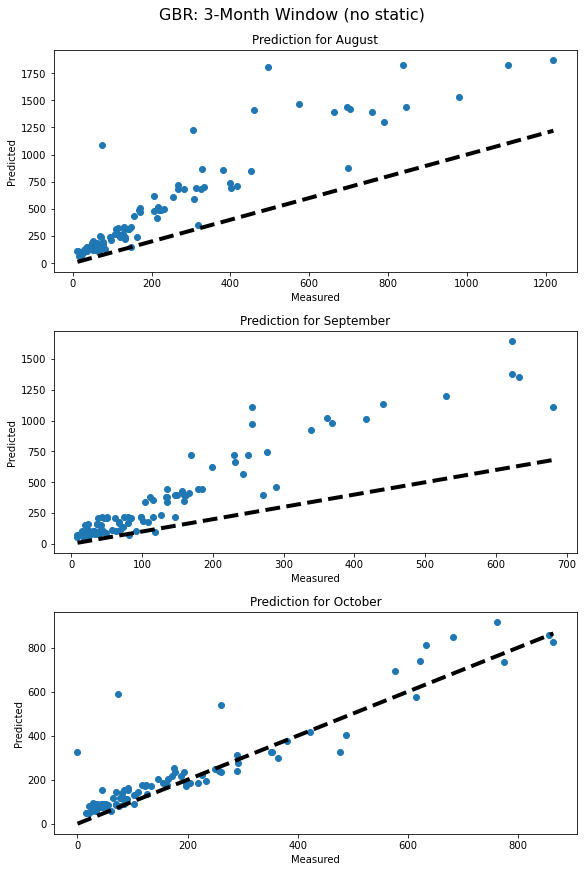

In [1022]:
train_model(nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, gb_model, "GBR: 3-Month Window (no static)", nc3m_pty_arr, 3)

MSE: [153638.69775190664, 112208.27364241156, 11288.377453295589]; avg = 92378.44961587126 
r2: [0.3753462999503757, 0.19979718849797512, 0.802667896500061]; avg = 0.45927046164947055
MAE: [245.944989689608, 225.0156271947475, 64.52499039360139]; avg = 178.49520242598564
avg: [244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 192.58608058608058


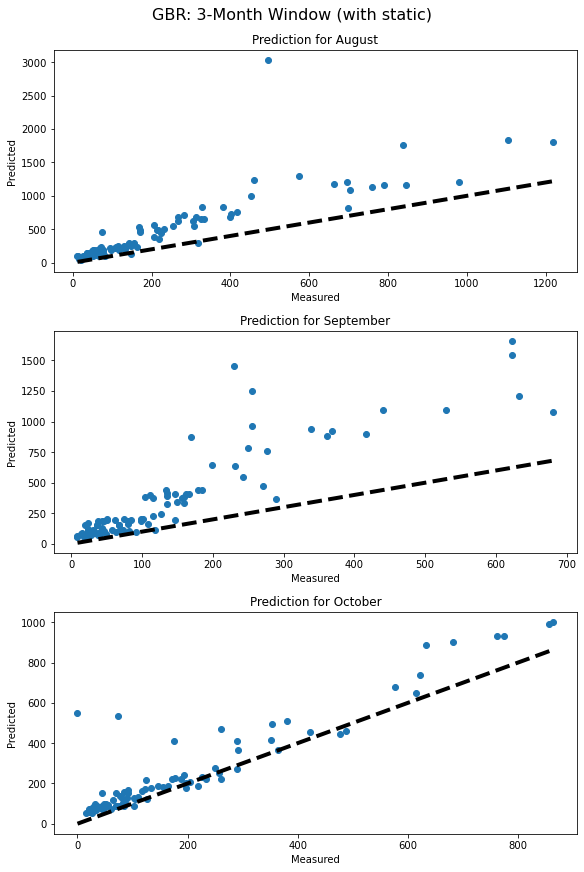

In [1023]:
train_model(wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, gb_model, "GBR: 3-Month Window (with static)", wc3m_pty_arr, 3)

## 2 month window

MSE: [82118.97434914374, 179397.0821874689, 103522.40875594369, 27805.345645716818]; avg = 98210.95273456829 
r2: [-0.07094893590464624, 0.3123749552757382, 0.1891292789384723, -3.207112860916431]; avg = -0.6941393906517167
MAE: [138.3567947367092, 300.7067633738139, 231.18789570448888, 107.67397974299078]; avg = 194.48135838950068
avg: [362.83516483516485, 244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 235.14835164835165


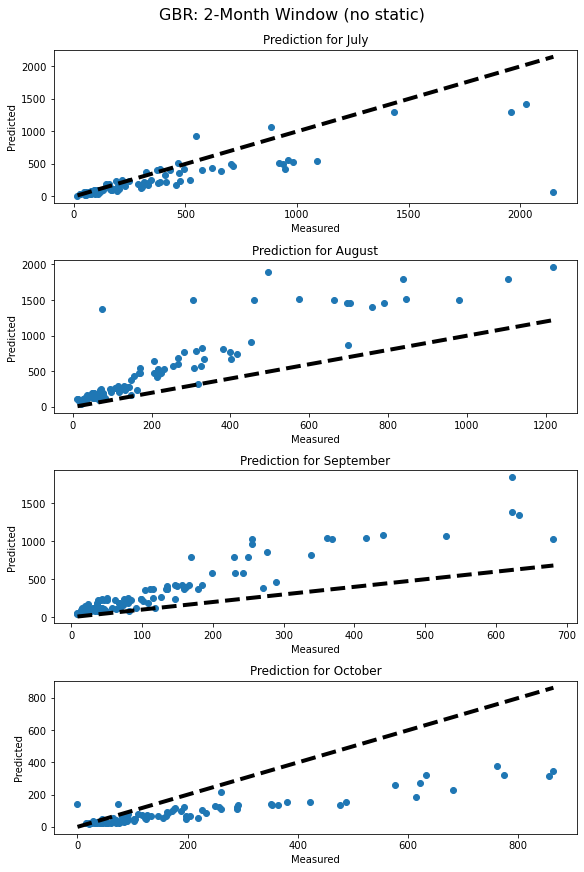

In [1024]:
train_model(nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, gb_model, "GBR: 2-Month Window (no static)", nc2m_pty_arr, 2)

MSE: [85405.88731495317, 177591.1219451549, 120056.40517694312, 25232.14085245083]; avg = 102071.3888223755 
r2: [-0.23105802595424696, 0.3502801193277384, 0.18163726752010267, -2.1377699306913778]; avg = -0.4592276424494459
MAE: [144.67499379436302, 271.39751442777407, 233.14805416923627, 103.10758346426422]; avg = 188.0820364639094
avg: [362.83516483516485, 244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 235.14835164835165


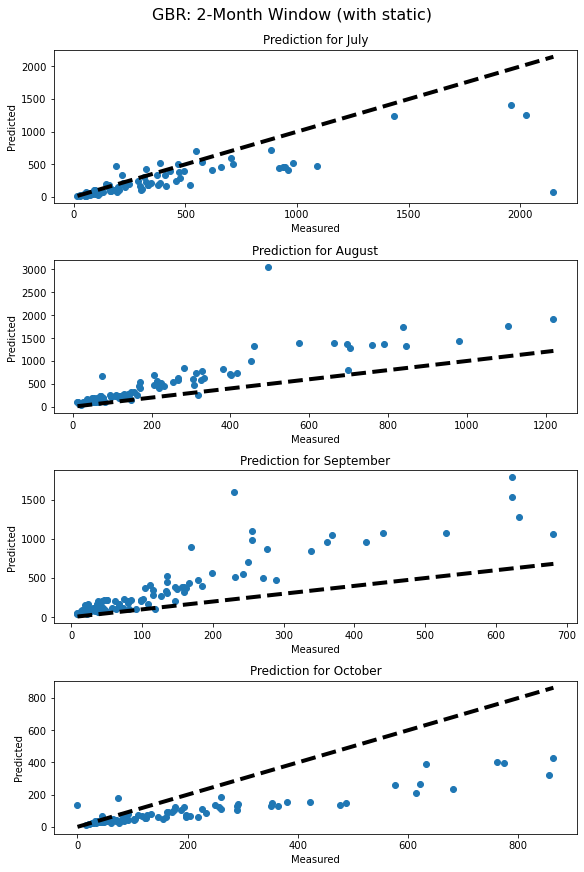

In [1025]:
train_model(wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, gb_model, "GBR: 2-Month Window (with static)", wc2m_pty_arr, 2)

## 1 month window

MSE: [30937.847819150877, 81459.73845055158, 158742.76871391214, 7724.6143096836595, 29898.77337208719]; avg = 61752.748533077094 
r2: [0.4391910221326393, -0.07062538065443547, 0.3191821450938557, 0.8145351914103193, -4.195583120299884]; avg = -0.538660028463501
MAE: [88.06701689919156, 132.04409465237623, 295.727898408675, 53.70131492444587, 110.79714987399181]; avg = 136.06749495173608
avg: [205.01098901098902, 362.8351648351649, 244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 229.12087912087912


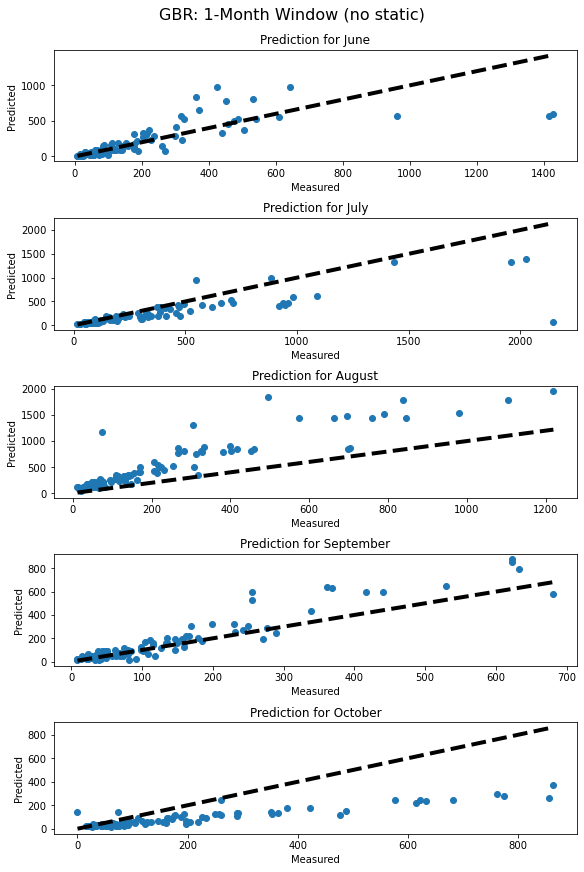

In [1026]:
train_model(nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, gb_model, "GBR: 1-Month Window (no static)", nc1m_pty_arr, 1)

MSE: [17695.02808283777, 71173.71505803155, 237621.94023084763, 8616.044242528886, 23131.386862687064]; avg = 71647.62289538658 
r2: [0.8250288337817919, 0.37795039777675543, 0.3192864089266755, 0.7963361891583328, -1.1154822920453453]; avg = 0.24062390751964208
MAE: [78.94813934497336, 130.03742828145346, 312.113597145592, 59.205097165471614, 102.48899917695277]; avg = 136.55865222288867
avg: [205.01098901098902, 362.8351648351649, 244.16483516483515, 142.13186813186815, 191.46153846153845]; avg = 229.12087912087912


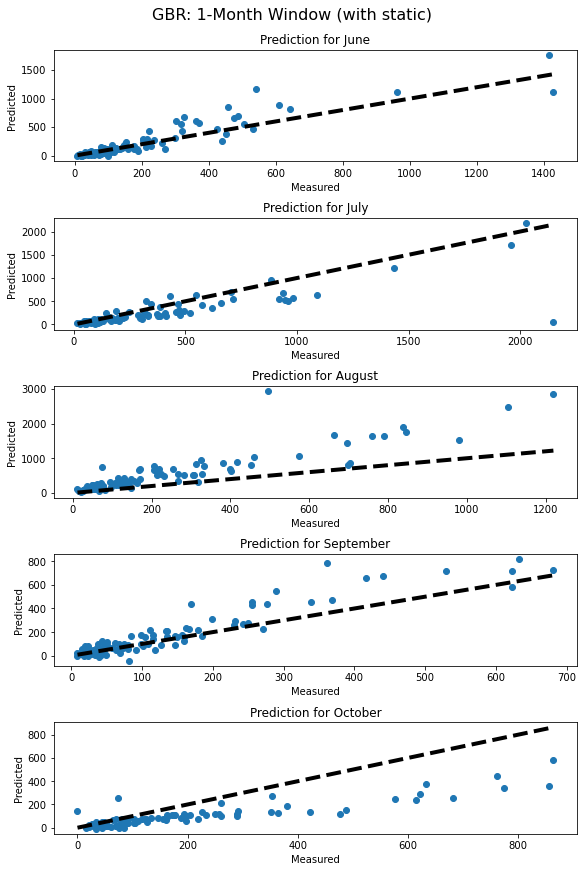

In [1027]:
train_model(wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, svr_model, "GBR: 1-Month Window (with static)", wc1m_pty_arr, 1)

# Graph change in r^2

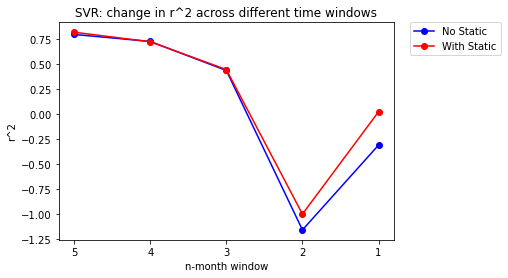

<Figure size 504x504 with 0 Axes>

In [89]:
y1=[0.794, 0.724, 0.434, -1.158, -0.311]
y2=[0.816, 0.721, 0.443, -1, 0.022]
# plt.plot(x, y1, 'ro-', x, y2, 'bo-')
plt.plot(y1, 'bo-', label="No Static", )
plt.plot(y2, 'ro-', label="With Static")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks([0,1,2,3,4],[5,4,3,2,1])
plt.ylabel('r^2')
plt.xlabel('n-month window')
plt.title('SVR: change in r^2 across different time windows')
plt.figure(figsize=(7,7))
plt.show()

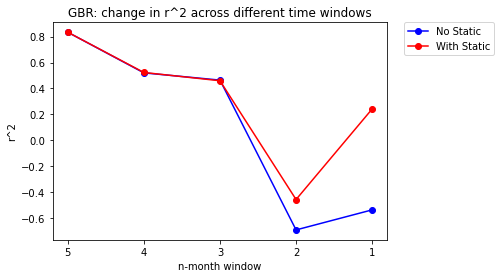

<Figure size 504x504 with 0 Axes>

In [88]:
y1=[0.834, 0.520, 0.464, -0.694, -0.539]
y2=[0.834, 0.523, 0.459, -0.459, 0.241]
# plt.plot(x, y1, 'ro-', x, y2, 'bo-')
plt.plot(y1, 'bo-', label="No Static", )
plt.plot(y2, 'ro-', label="With Static")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks([0,1,2,3,4],[5,4,3,2,1])
plt.ylabel('r^2')
plt.xlabel('n-month window')
plt.title('GBR: change in r^2 across different time windows')
plt.figure(figsize=(7,7))
plt.show()

# XGBoost

In [ ]:
!pip install xgboost

In [398]:
from xgboost import XGBRegressor

# Feature Selection

## The following takes a long time to run!!! Just use the cell below this section

In [443]:
month_data_with_census = build_month_data_with_census(census_data)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_no_census, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_with_census, 5)

KeyboardInterrupt: 

In [ ]:
gb_param = {
    'n_estimators': 900,
    'max_depth': 2,
    'min_samples_split': 100,
    'learning_rate': 0.01,
    'loss': 'ls'
}
xg_model = XGBRegressor(**gb_param)
xg_feat_subsets = f_selection(xg_model,wc5m_X_train_arr[0].shape[1],wc5m_X_train_arr[0],wc5m_y_train_arr[0])

In [ ]:
print(xg_feat_subsets)
np.save('../data/xg_feat_subsets.npy',xg_feat_subsets, allow_pickle=True)

## Run this section instead!!

In [418]:
month_data_with_census = build_month_data_with_census(census_data)
svr_feat_subsets = np.load('../data/svr_feat_subsets.npy', allow_pickle=True)[()]
svr_feat_subsets

{1: {'feature_idx': (0,),
  'cv_scores': array([0.73347998, 0.8161115 , 0.34517045, 0.61968864, 0.46885929]),
  'avg_score': 0.5966619720458215,
  'feature_names': ('0',)},
 2: {'feature_idx': (0, 1),
  'cv_scores': array([0.76492683, 0.89453549, 0.35222746, 0.8125219 , 0.52418433]),
  'avg_score': 0.6696792015185971,
  'feature_names': ('0', '1')},
 3: {'feature_idx': (0, 1, 172),
  'cv_scores': array([0.78089029, 0.88822498, 0.35164029, 0.84783849, 0.52083289]),
  'avg_score': 0.6778853874877052,
  'feature_names': ('0', '1', '172')},
 4: {'feature_idx': (0, 1, 129, 172),
  'cv_scores': array([0.79210343, 0.89201727, 0.35353407, 0.86131451, 0.51980067]),
  'avg_score': 0.6837539885960784,
  'feature_names': ('0', '1', '129', '172')},
 5: {'feature_idx': (0, 1, 129, 136, 172),
  'cv_scores': array([0.79385839, 0.88837114, 0.36482614, 0.85014582, 0.53451148]),
  'avg_score': 0.6863425929305487,
  'feature_names': ('0', '1', '129', '136', '172')},
 6: {'feature_idx': (0, 1, 105, 129, 13

In [419]:
def get_optimal_index(feat_subsets):
    feature_counts = []
    r2s = []
    optimal_feat = None
    optimal_r2 = None
    for key, value in feat_subsets.items():
        if key == 1:
            optimal_r2 = value['avg_score']
            optimal_feat = value
        elif (value['avg_score'] > optimal_r2):
            optimal_feat = value
            optimal_r2 = value['avg_score']
        feature_counts.append(key)
        r2s.append(value['avg_score'])
    optimal_index = np.array(list(set(optimal_feat['feature_idx']) | {0, 1, 2, 3, 4})) ## Add dynamic features to the list of optimal features
    print(np.array(feature_names)[optimal_feat_index])
    
    plt.plot(feature_counts, r2s)
    plt.xlabel('Number of features')
    plt.ylabel('r2')
    plt.title('Change in r2 with additional census features')
    plt.show()
    return optimal_index

['cases' 'County total cases' 'Incoming migration' 'Outgoing migration'
 'Nursing home density' 'Healthcare workers' 'Food Services workers'
 '% Area Total: Area (Water)' '% Total Population: 10 to 14 Years'
 '% Total Population: 15 to 17 Years' '% Total Population: 25 to 34 Years'
 '% Total Population: 35 to 44 Years' '% Total Population: 55 to 64 Years'
 '% Total Population: 85 Years and Over' '% Households: Family Households'
 '% Households: Family Households: Married-Couple Family'
 '% Households: Family Households: Other Family'
 '% Households: Family Households: Other Family: Male Householder, No Wife Present'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present'
 '% Households: Nonfamily Households'
 '% Households: Nonfamily Households: Male Householder'
 '% Population 16 Years and Over: in Labor Force'
 '% Population 16 Years and Over: in Labor Force: Civilian'
 '% In Labor Force 16 Years and Over: in Armed Forces'
 '% Employed Civilian Popula

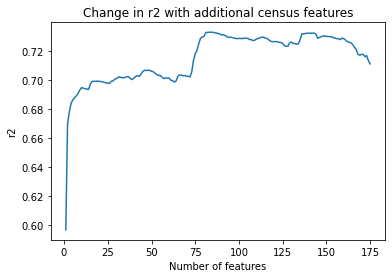

array([  0,   1,   2,   3,   4,   6,   7,   8,   9,  12,  13,  18,  22,
        26,  27,  28,  29,  30,  32,  33,  34,  35,  39,  41,  42,  46,
        48,  49,  50,  52,  54,  68,  69,  74,  75,  76,  78,  79,  80,
        81,  82,  83,  86,  87,  88,  89,  90,  92,  93,  98, 102, 103,
       104, 105, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 124,
       128, 129, 130, 135, 136, 137, 138, 139, 140, 141, 143, 144, 149,
       150, 157, 158, 159, 160, 167, 168, 170, 172, 173])

In [420]:
svr_optimal_index = get_optimal_index(svr_feat_subsets)
svr_optimal_index

## Generate train-test set

In [421]:
# Select only the top features
temp = np.append(svr_optimal_index+1, month_data_with_census.shape[1]-1)
month_data_with_census = month_data_with_census[:, np.insert(temp, 0, 0, axis=0)] # Insert month and target columns
month_data_with_census.shape

(546, 90)

In [422]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_no_census, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_with_census, 5)

In [423]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_no_census, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_with_census, 4)

In [424]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_no_census, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_with_census, 3)

In [425]:
nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, nc2m_ptX_arr, nc2m_pty_arr = n_month_window_split(month_data_no_census, 2)
wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, wc2m_ptX_arr, wc2m_pty_arr = n_month_window_split(month_data_with_census, 2)

In [426]:
nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, nc1m_ptX_arr, nc1m_pty_arr = n_month_window_split(month_data_no_census, 1)
wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, wc1m_ptX_arr, wc1m_pty_arr = n_month_window_split(month_data_with_census, 1)

/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountere

In [437]:
gb_param = {
    'n_estimators': 900,
    'max_depth': 2,
    'min_samples_split': 100,
    'learning_rate': 0.01,
    'loss': 'ls'
}
xg_model = XGBRegressor(**gb_param)

[00:35:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { loss, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE: [0.1495041226296426] 
r2: [0.802294469997854] 
MAE: [0.23176203761861325] 
avg: [-0.08040828841961946]


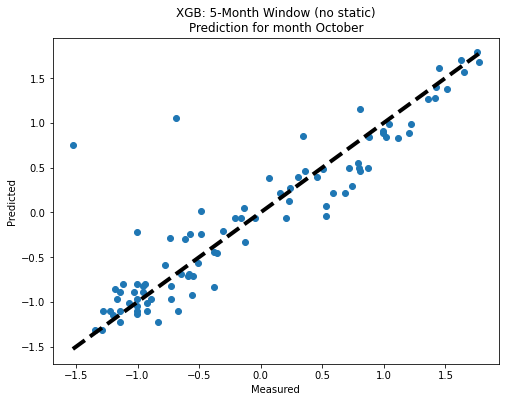

In [438]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, xg_model, "XGB: 5-Month Window (no static)", 5)

[00:35:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { loss, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE: [0.1614497400172439] 
r2: [0.7910883535596398] 
MAE: [0.24655981282501718] 
avg: [-0.08040828841961946]


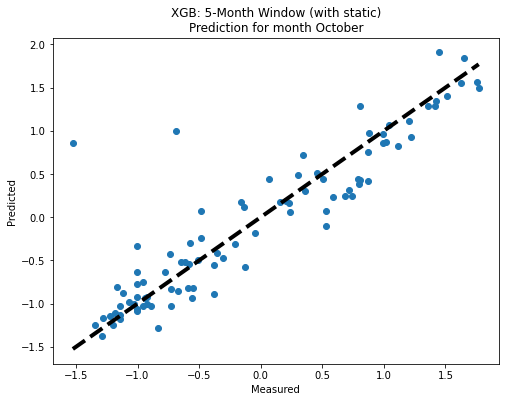

In [439]:
train_model(wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, xg_model, "XGB: 5-Month Window (with static)", 5)

# Scratch Work

In [ ]:
for i in range(1, month_data_with_census.shape[1]-1):
    s = skew(month_data_with_census[:,i])
    if abs(s) > 1:
        print("skewness: " + str(s))
        plt.hist(month_data_with_census[:,i])
        plt.title(feature_names[i-1])
        plt.show()
        print('###### Transform')
#         feat = (month_data_with_census[:,i].max()+1)-month_data_with_census[:,i]
        feat = (1+month_data_with_census[:,i])
        t1 = scale(power_transform(feat.reshape(-1,1)))
        print('yeo-johnson: ' + str(skew(t1)[0]))
        t2 = scale(np.log(feat))
        print('log: ' + str(skew(t2)))
        plt.hist(t2, alpha=0.5)
        plt.hist(t1, color='green')
        plt.title(feature_names[i-1])
        green_patch = mpatches.Patch(color='green', label='Yeo-Johnson')
        purple_patch = mpatches.Patch(color='blue', label='Log')
        plt.legend(handles=[green_patch, purple_patch])
        plt.show()
        


skewness: 3.3105429103244397


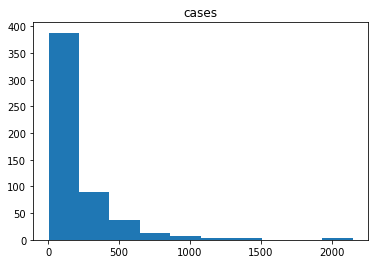

###### Transform
yeo-johnson: 0.49256413014519174
log: -0.050905546751608265


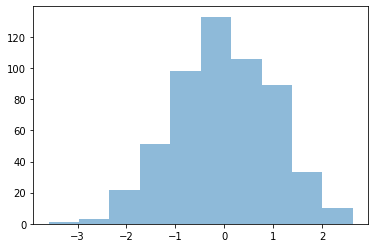

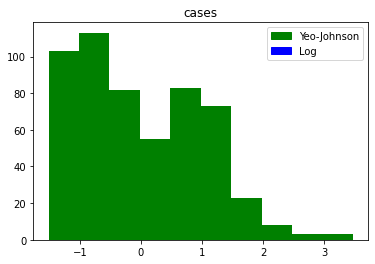

skewness: 1.938179689513794


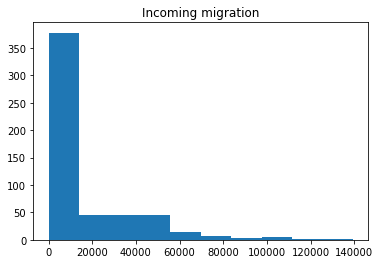

###### Transform
yeo-johnson: 0.7227525724489394
log: -0.2916929159228729


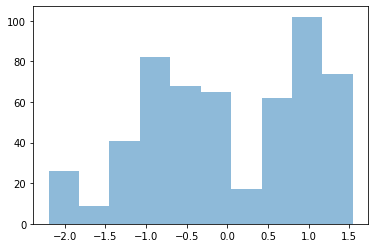

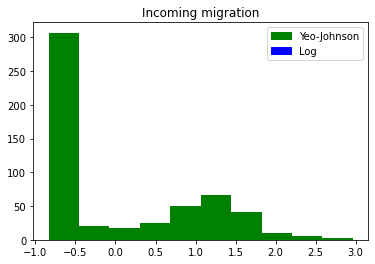

skewness: 1.434435606349379


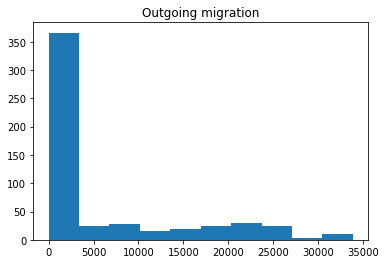

###### Transform
yeo-johnson: 0.7423647554281653
log: 0.08817683415069817


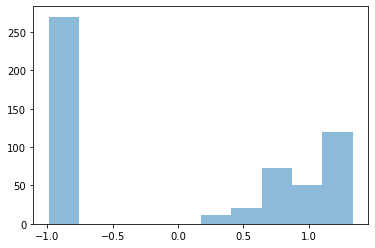

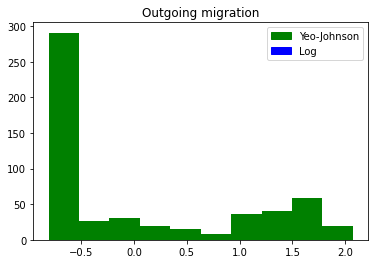

skewness: 3.2102037034675943


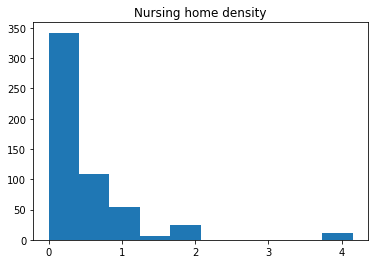

###### Transform
yeo-johnson: 0.23436999530405359
log: 1.5682641169405418


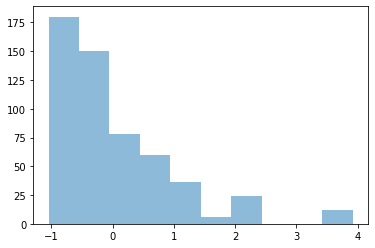

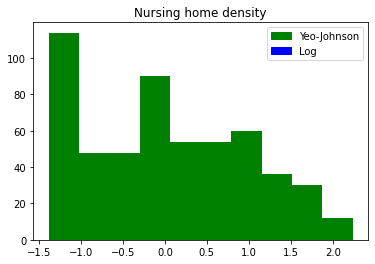

skewness: 3.1458788575529564


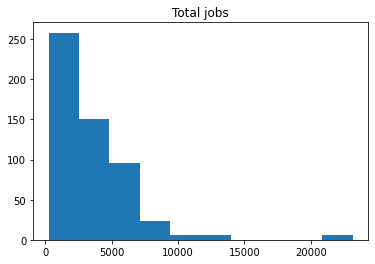

###### Transform
yeo-johnson: 0.5353540064587243
log: -0.2063956779382542


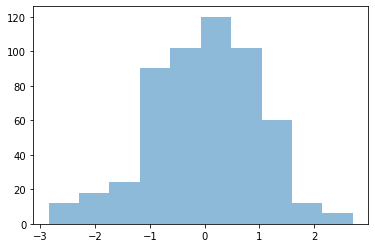

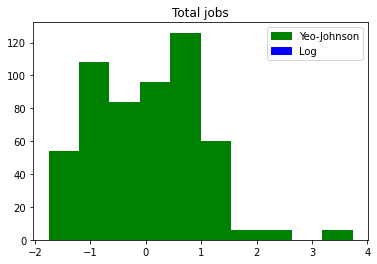

skewness: 1.4350042704288521


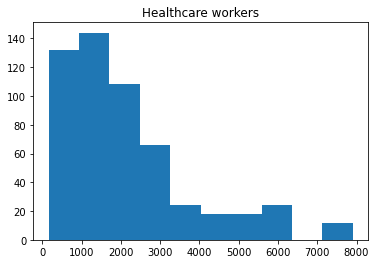

###### Transform
yeo-johnson: 0.28341976643203537
log: -0.288850079780734


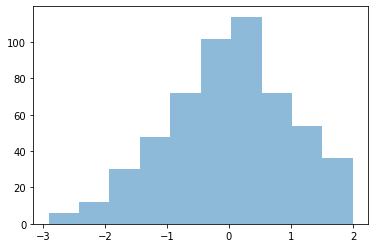

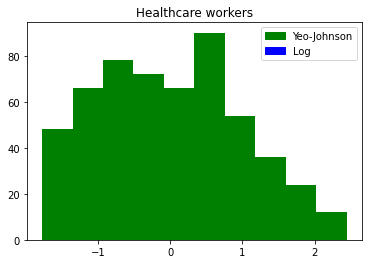

skewness: 5.8432539480607355


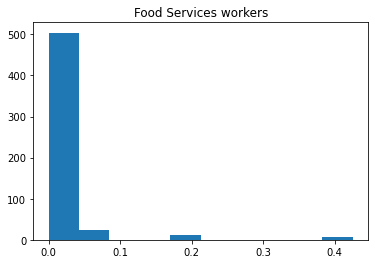

###### Transform
yeo-johnson: 1.2754875133393495
log: 5.482427463507743


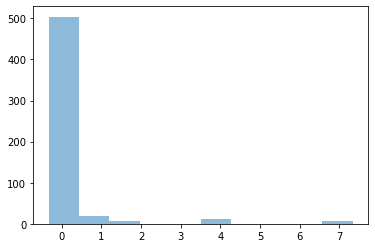

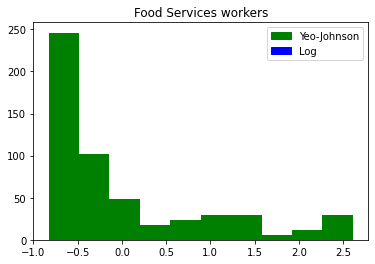

skewness: 1.0199123385649589


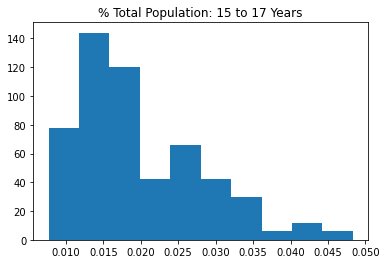

###### Transform
yeo-johnson: 0.13195767523723406
log: 0.9989850210673606


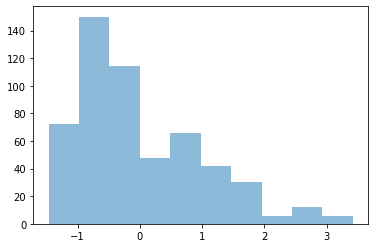

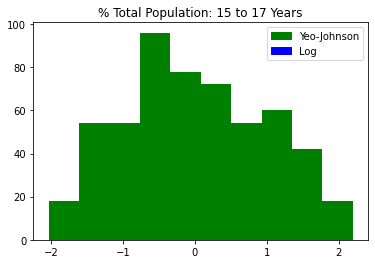

skewness: 1.33596130870334


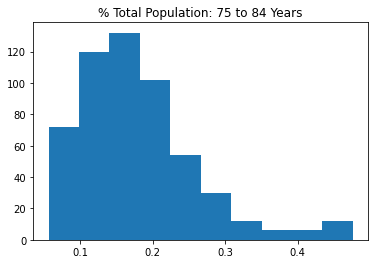

###### Transform
yeo-johnson: 0.08381992270757926
log: 1.0995394909409273


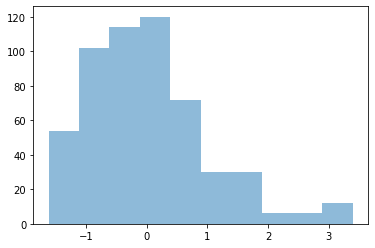

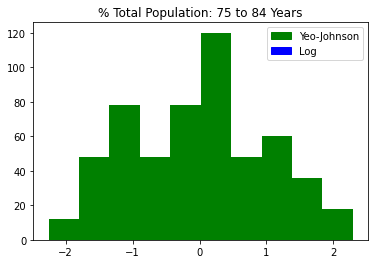

skewness: -1.298251783868499


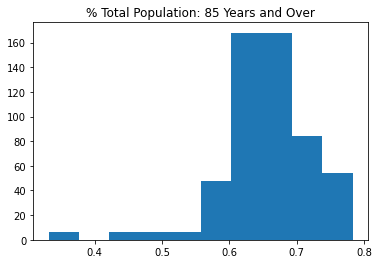

###### Transform
yeo-johnson: 0.078884511141868
log: -1.673214093323714


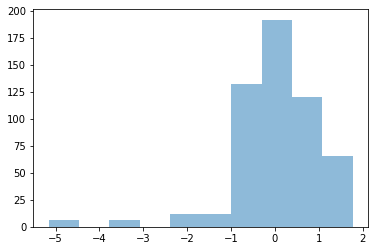

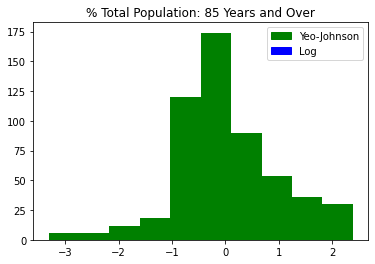

skewness: -1.2951880703892913


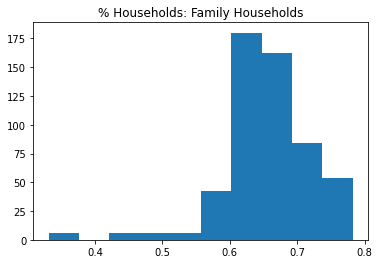

###### Transform
yeo-johnson: 0.07834604296356618
log: -1.669239373284323


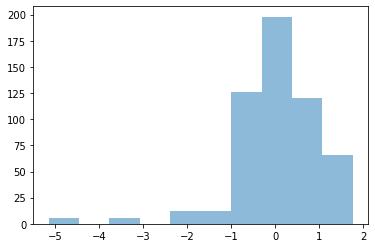

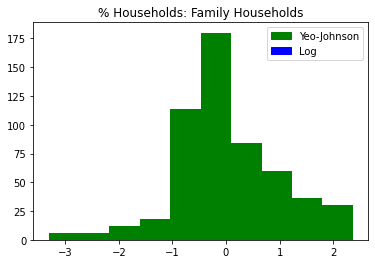

skewness: 3.8445977368024655


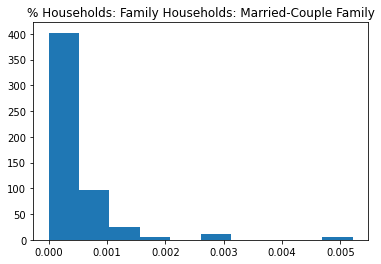

###### Transform
yeo-johnson: 0.7596665646522559
log: 3.8378354400979284


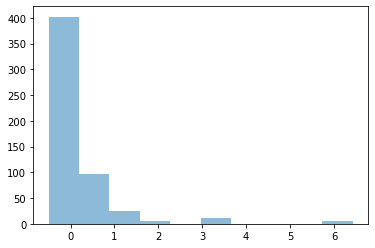

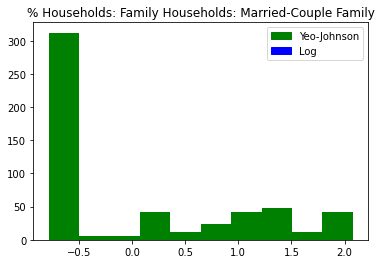

skewness: 1.9570993695272312


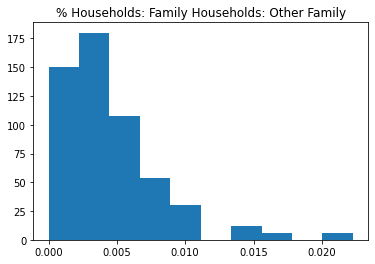

###### Transform
yeo-johnson: 0.1300703010560765
log: 1.9367748820764745


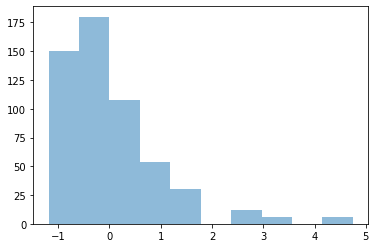

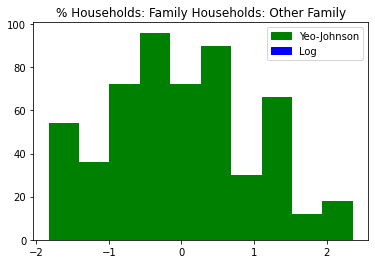

skewness: 1.6704524082571452


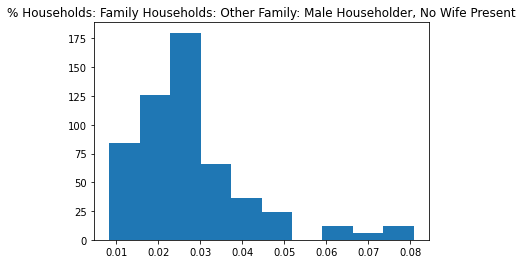

###### Transform
yeo-johnson: 0.05643092525927028
log: 1.6188375528489751


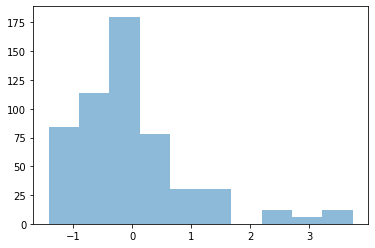

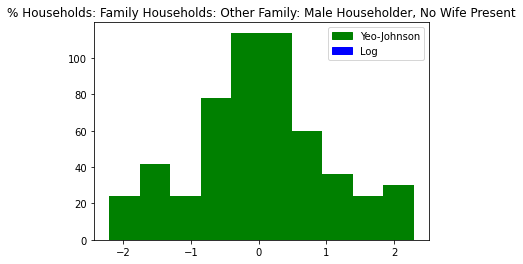

skewness: 1.0778297591867905


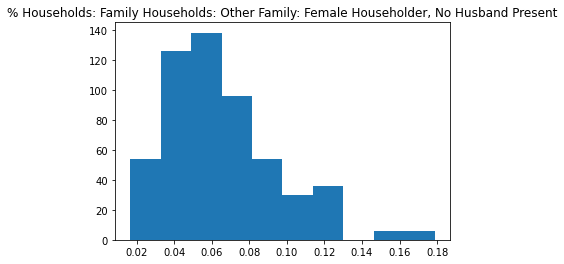

###### Transform
yeo-johnson: 0.09100216526715185
log: 0.9911362611550198


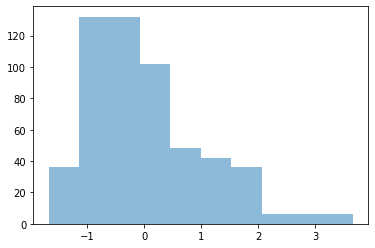

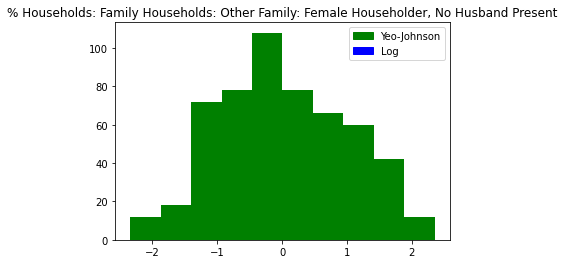

skewness: 1.1727187353271615


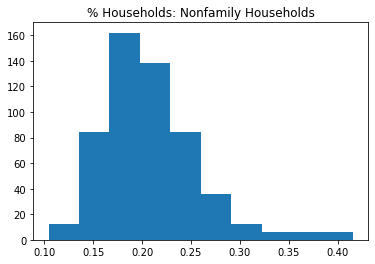

###### Transform
yeo-johnson: -0.020768247056198792
log: 0.9801481034886178


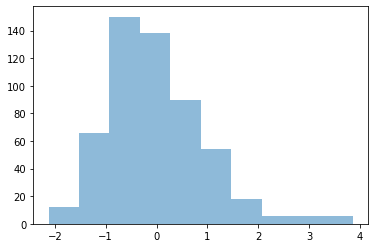

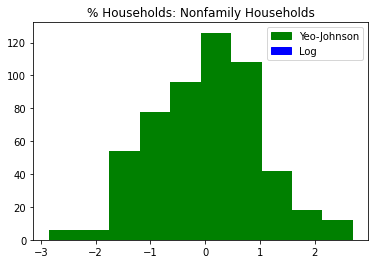

skewness: 2.7604954471401424


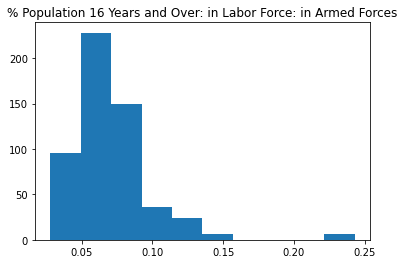

###### Transform
yeo-johnson: -0.01969308739114089
log: 2.477488650707838


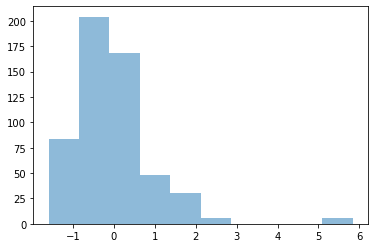

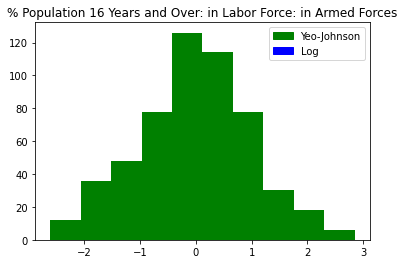

skewness: -1.229748065815309


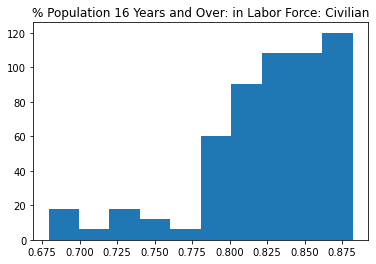

###### Transform
yeo-johnson: -0.12819193125145295
log: -1.3024727034051586


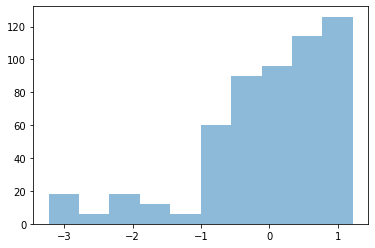

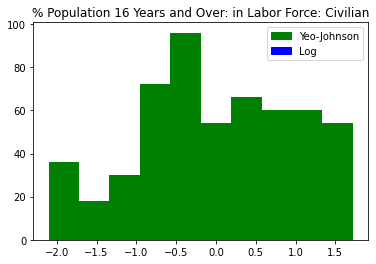

skewness: 1.0480775092297494


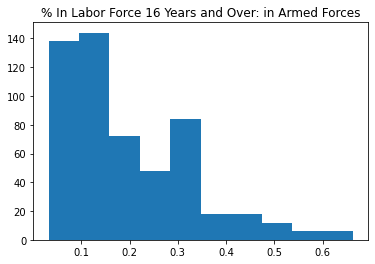

###### Transform
yeo-johnson: 0.18192277276980975
log: 0.8099012451325898


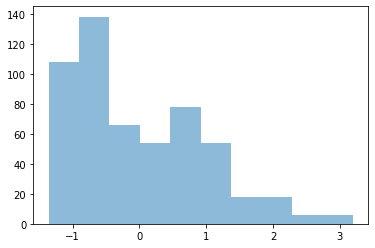

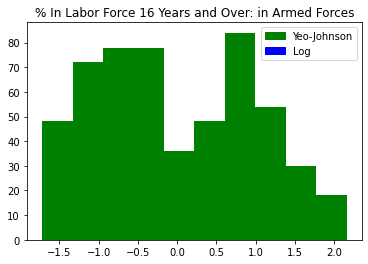

skewness: 1.0219315896471455


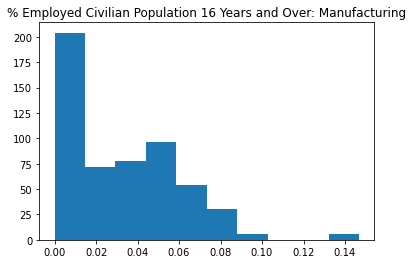

###### Transform
yeo-johnson: 0.15397570115623638
log: 0.9325272234536462


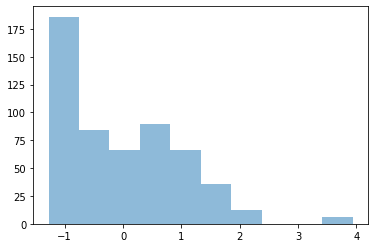

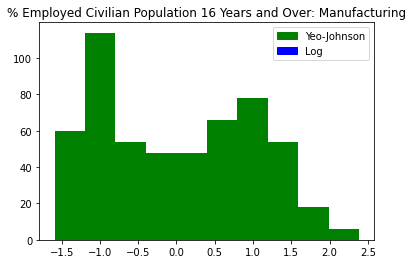

skewness: 1.0419676971114613


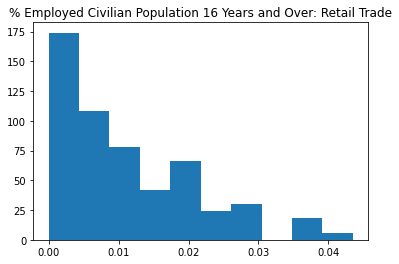

###### Transform
yeo-johnson: 0.1944826549283637
log: 1.0189710024389462


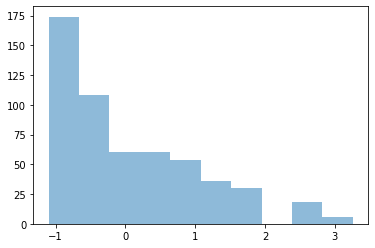

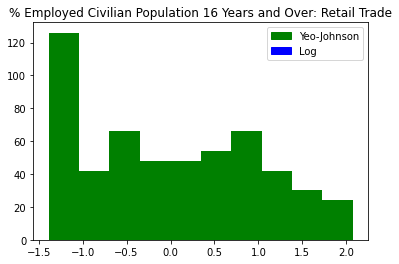

skewness: 1.3355759927109272


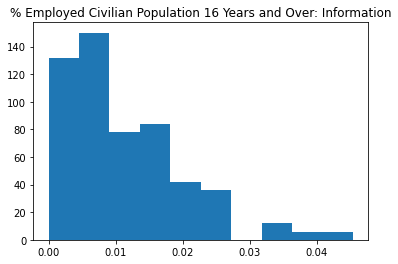

###### Transform
yeo-johnson: 0.14035268321597208
log: 1.3059459411391894


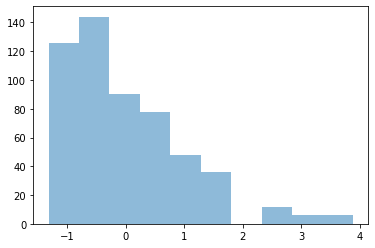

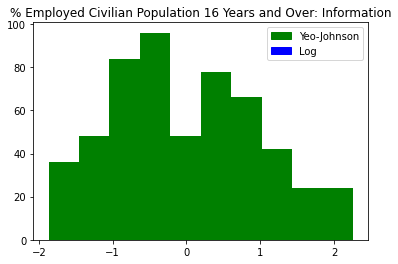

skewness: 2.950700155750129


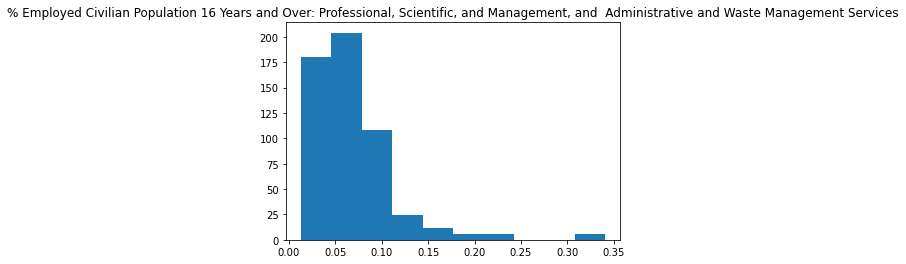

###### Transform
yeo-johnson: 0.08411773674116332
log: 2.600133684205734


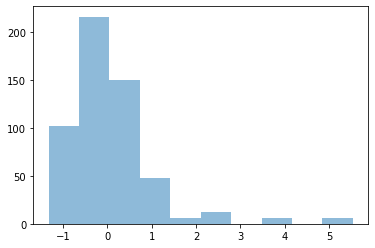

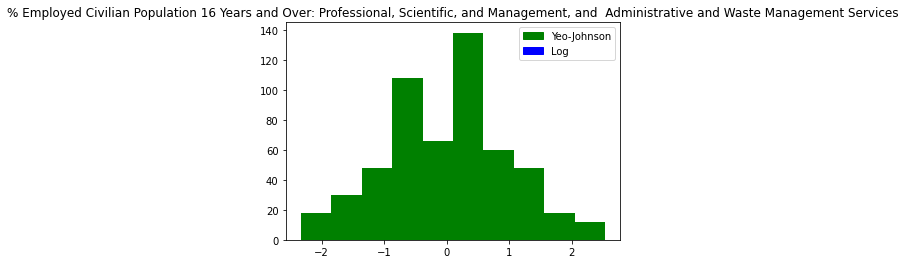

skewness: 1.5204738610481952


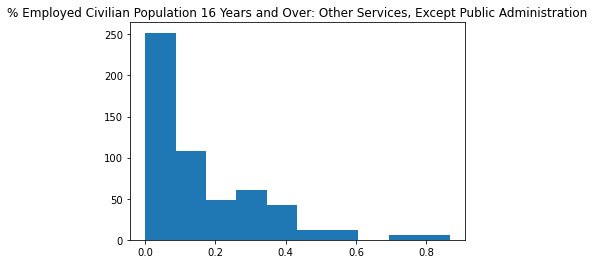

###### Transform
yeo-johnson: 0.2684761206169122
log: 1.106669708371343


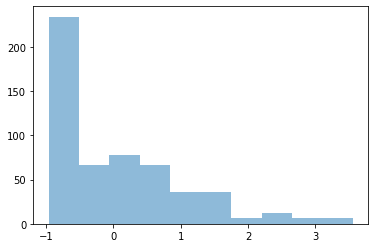

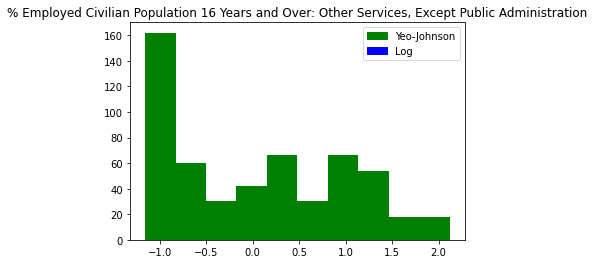

skewness: -1.947204525117069


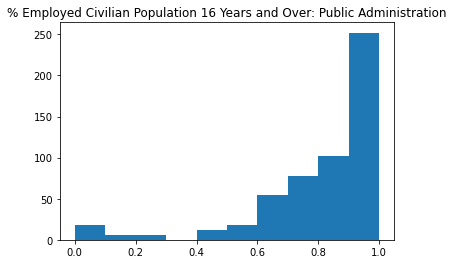

###### Transform
yeo-johnson: -0.2924183647876515
log: -2.4715709544712396


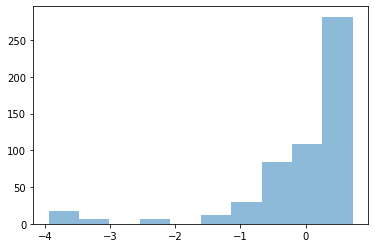

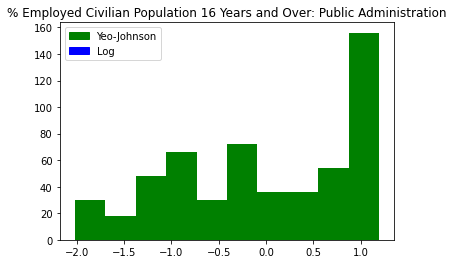

skewness: -2.3639464769902347


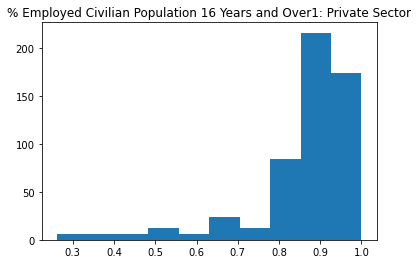

###### Transform
yeo-johnson: -0.17787849336476433
log: -2.687083521386401


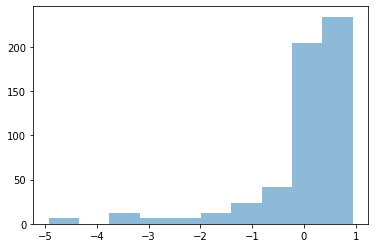

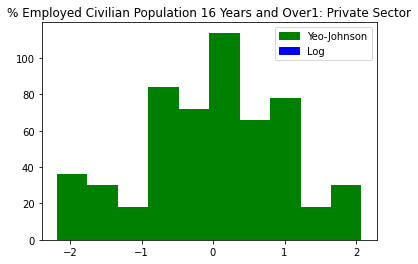

skewness: -2.6131532042869647


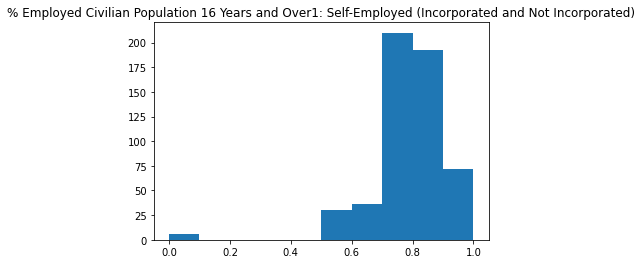

###### Transform
yeo-johnson: 0.07773194207799333
log: -3.864911648565206


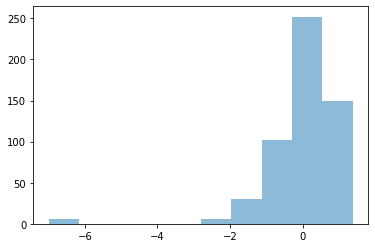

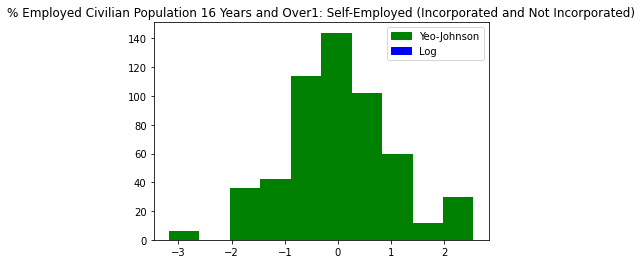

skewness: 1.694295290841906


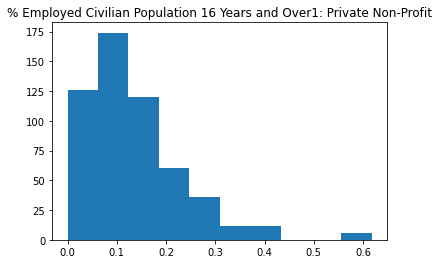

###### Transform
yeo-johnson: 0.10156626738638655
log: 1.2957176576698795


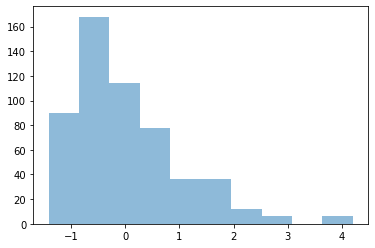

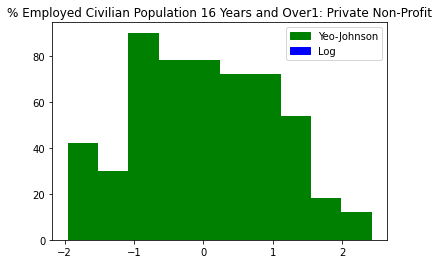

skewness: -2.8467419065797275


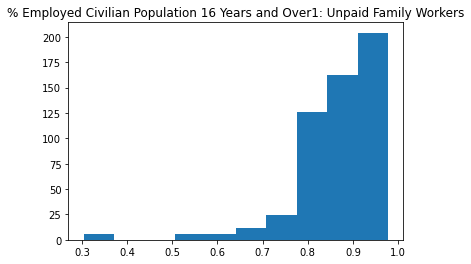

###### Transform
yeo-johnson: -0.1728889315507822
log: -3.391984970877013


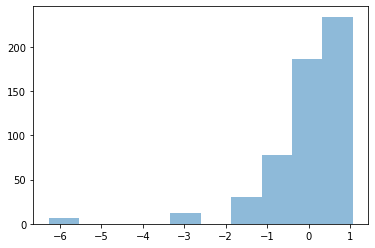

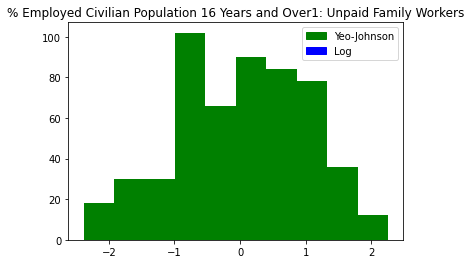

skewness: 4.859376937301092


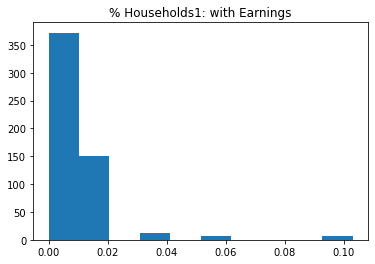

###### Transform
yeo-johnson: 0.30119129713437376
log: 4.707675723611231


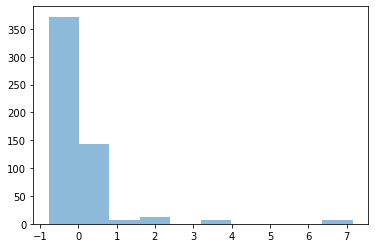

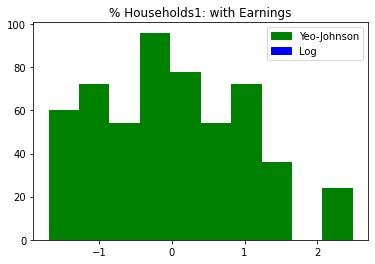

skewness: 2.1555171530532644


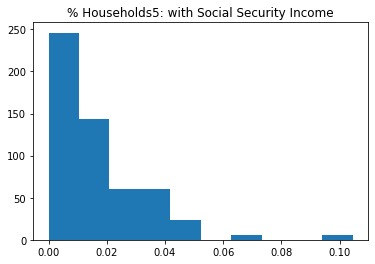

###### Transform
yeo-johnson: 0.2153913035848854
log: 2.040237030149384


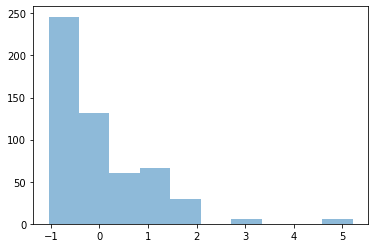

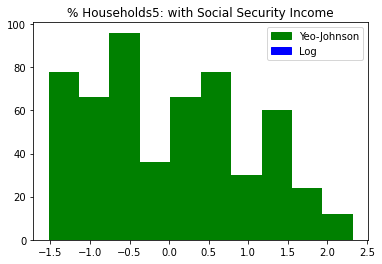

skewness: -1.4267654595646089


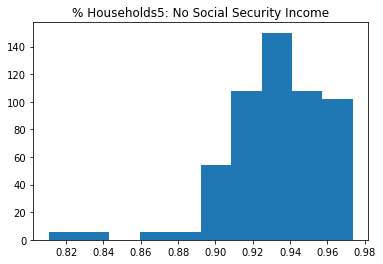

###### Transform
yeo-johnson: 0.006156464766001219
log: -1.5196591395014183


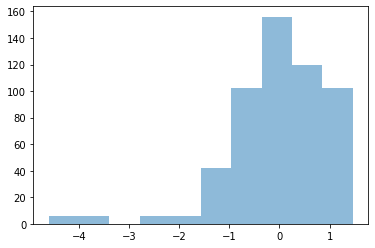

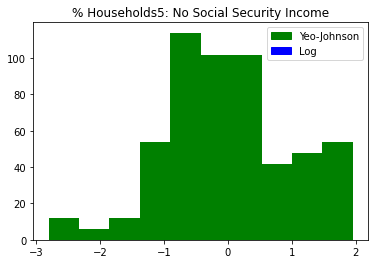

skewness: 1.0094703920815697


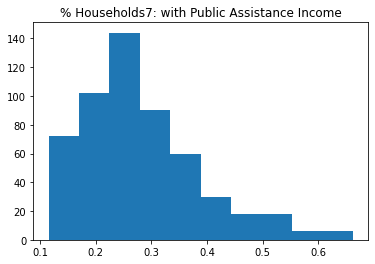

###### Transform
yeo-johnson: 0.051070832870874584
log: 0.7593417091246141


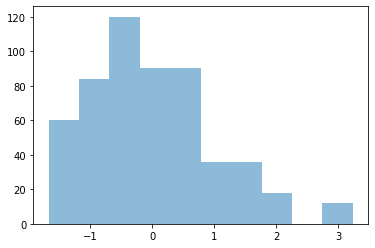

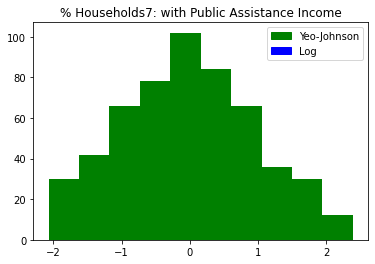

skewness: 1.1927621333230083


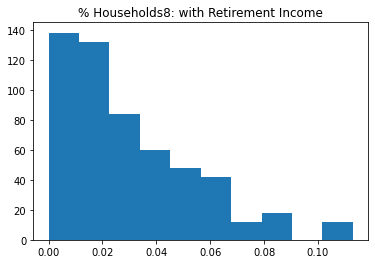

###### Transform
yeo-johnson: 0.21663534434137616
log: 1.136476587316464


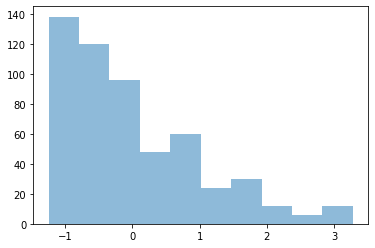

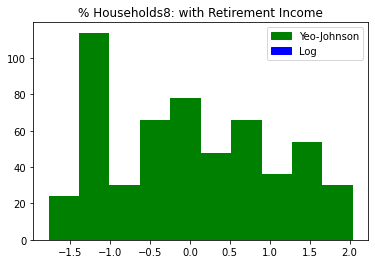

In [1039]:
pipe = make_pipeline(StandardScaler(with_std=False), PowerTransformer(standardize=True))
for i in range(1, month_data_with_census.shape[1]-1):
    s = skew(month_data_with_census[:,i])
    if abs(s) > 1:
        print("skewness: " + str(s))
        plt.hist(month_data_with_census[:,i])
        plt.title(feature_names[i-1])
        plt.show()
        print('###### Transform')
#         feat = (month_data_with_census[:,i].max()+1)-month_data_with_census[:,i]
        feat = (1+month_data_with_census[:,i])
#         t1 = scale(power_transform(feat.reshape(-1,1)))
        t1 = pipe.fit_transform(feat.reshape(-1,1))
        print('yeo-johnson: ' + str(skew(t1)[0]))
        t2 = scale(np.log(feat))
        print('log: ' + str(skew(t2)))
        plt.hist(t2, alpha=0.5)
        plt.show()
        plt.hist(t1, color='green')
        plt.title(feature_names[i-1])
        green_patch = mpatches.Patch(color='green', label='Yeo-Johnson')
        purple_patch = mpatches.Patch(color='blue', label='Log')
        plt.legend(handles=[green_patch, purple_patch])
        plt.show()
        


skewness: 0.5064490673919555


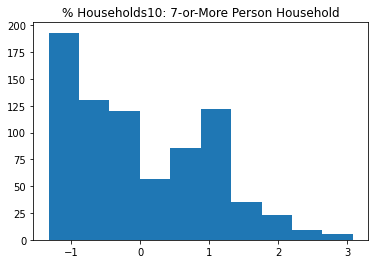

skewness: 0.3090412098025316


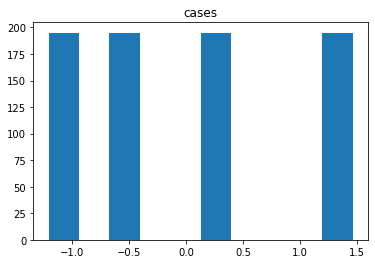

skewness: -1.308095142270768


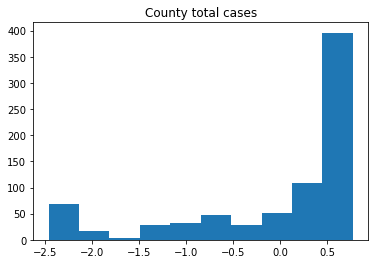

skewness: 1.3080955900658437


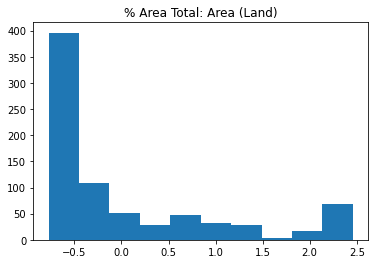

skewness: 0.011813500741797496


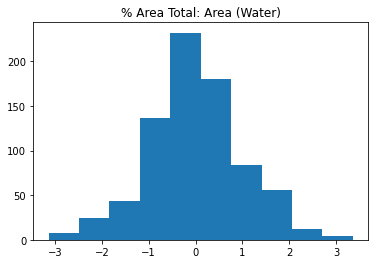

skewness: 0.004767130686792724


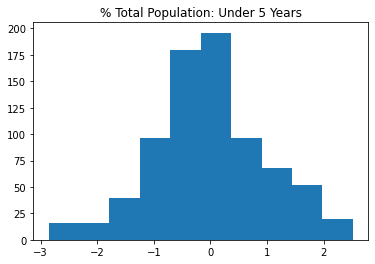

skewness: -0.007984318250033946


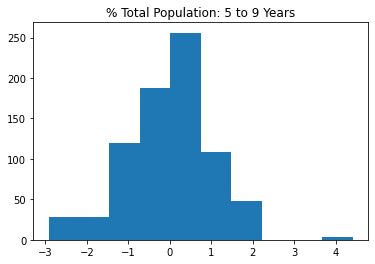

skewness: 0.005552599188141118


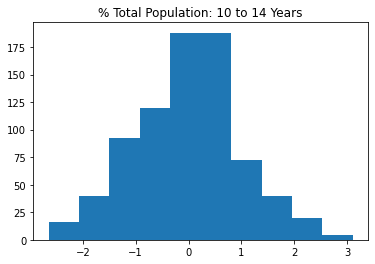

skewness: -0.30211987450172767


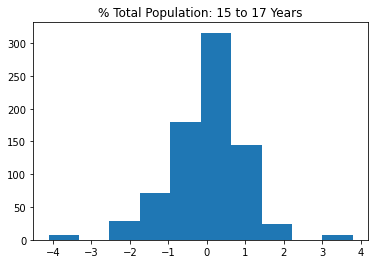

skewness: -0.05521094849258715


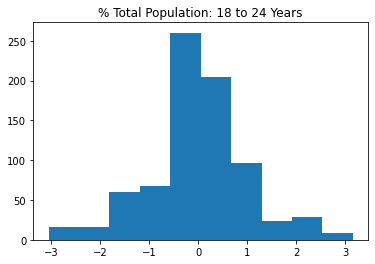

skewness: 0.02046963540140671


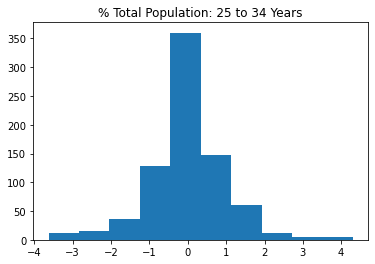

skewness: 0.0768951461753422


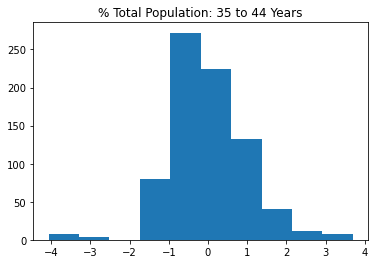

skewness: -0.018647708776119196


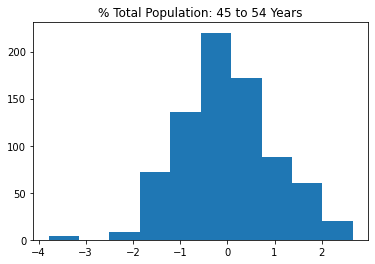

skewness: 0.023485747175819367


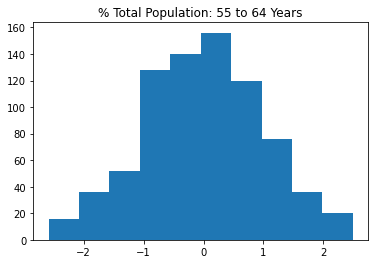

skewness: -0.09071875122987795


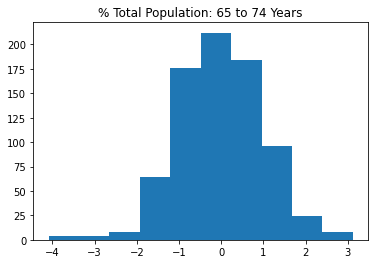

skewness: 0.15025618343883282


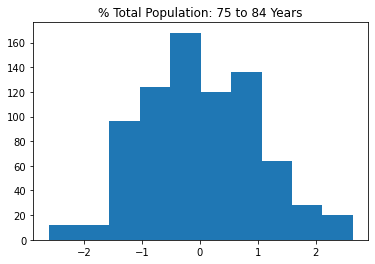

skewness: -0.1006866888642325


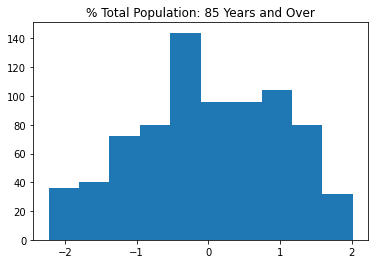

skewness: 0.002873277137215966


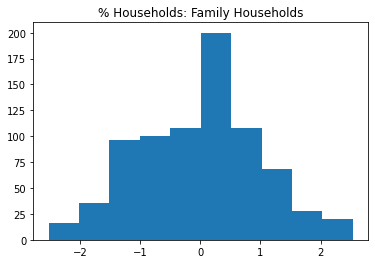

skewness: 0.04083128459026957


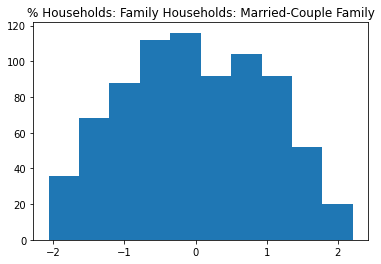

skewness: 0.024762679968671136


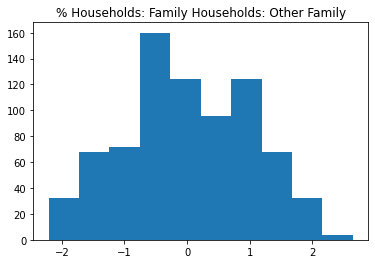

skewness: 0.04306304286783797


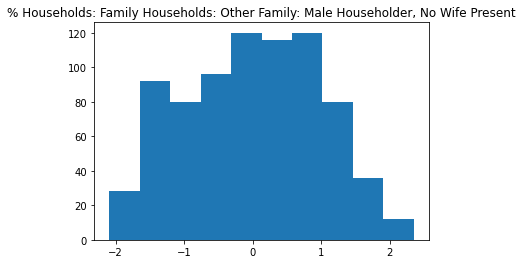

skewness: 0.10068669498310408


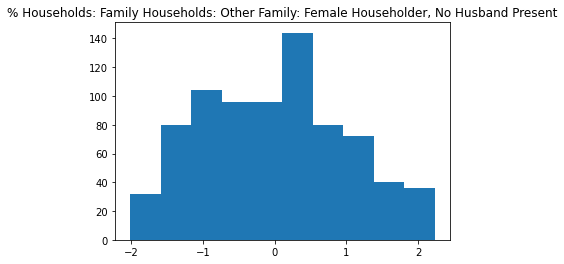

skewness: 0.14148190178781175


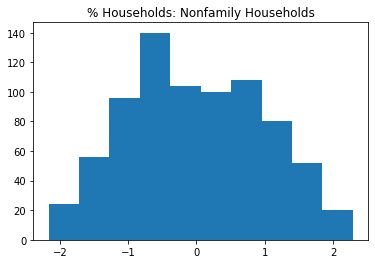

skewness: 0.07747140796368922


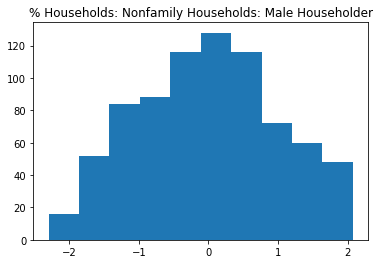

skewness: 0.06775618030216897


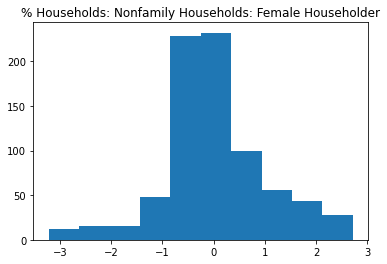

skewness: 0.7470851059715546


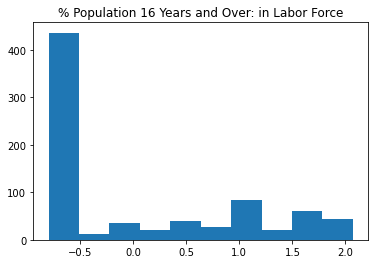

skewness: 0.06767609238709459


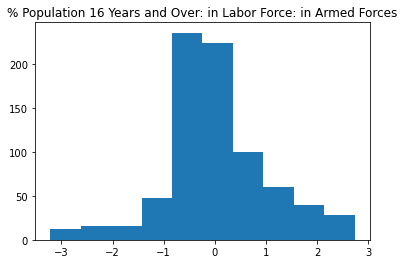

skewness: 0.06377368674531936


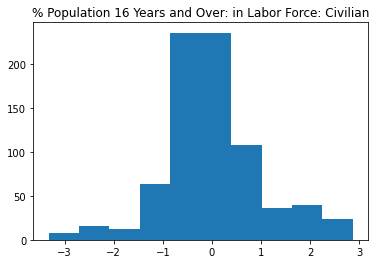

skewness: -0.0052054290068845755


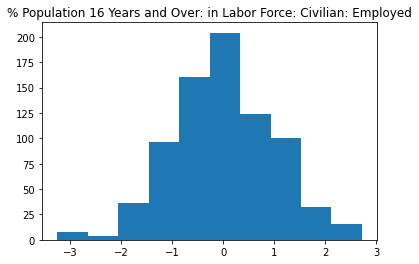

skewness: -0.06775611407105034


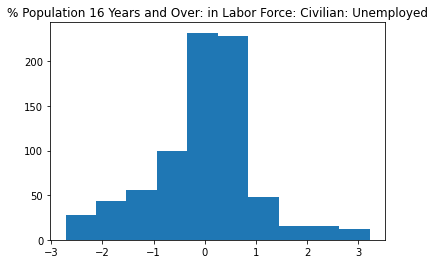

skewness: 0.7365112342425791


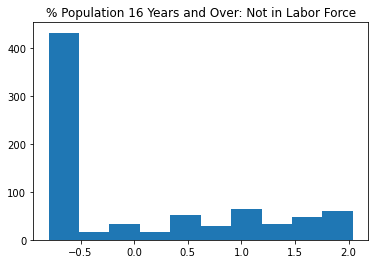

skewness: -0.736511253235446


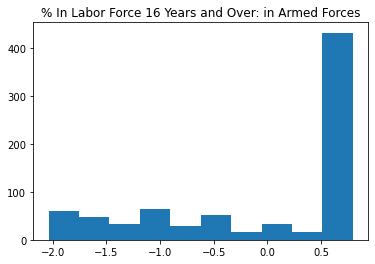

skewness: 0.12736249377331696


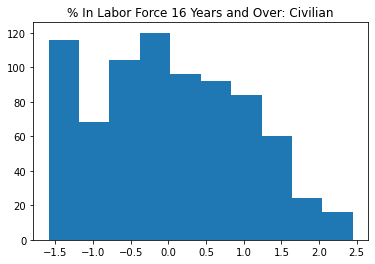

skewness: 0.026420291431020565


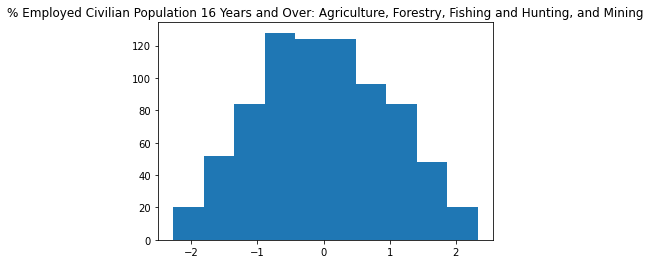

skewness: 0.07139897236547914


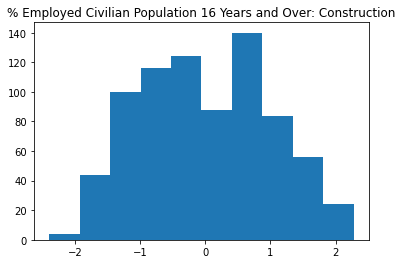

skewness: 0.08967671541758157


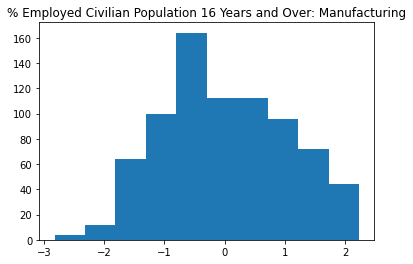

skewness: 0.017931348715966567


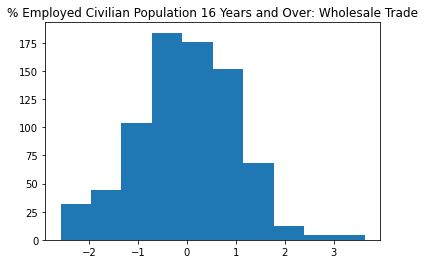

skewness: 0.026429045942165344


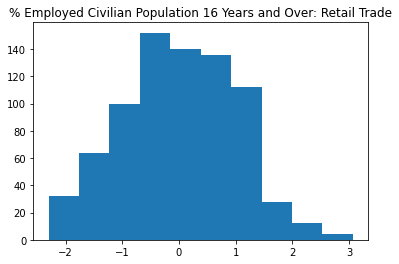

skewness: 0.3056833761263595


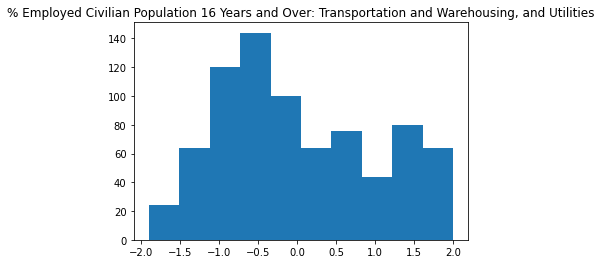

skewness: 0.07639351048523838


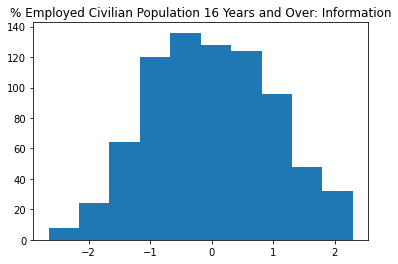

skewness: -0.06892751356842163


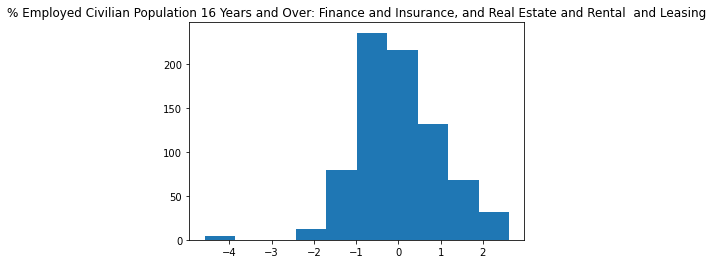

skewness: -0.013913407370118647


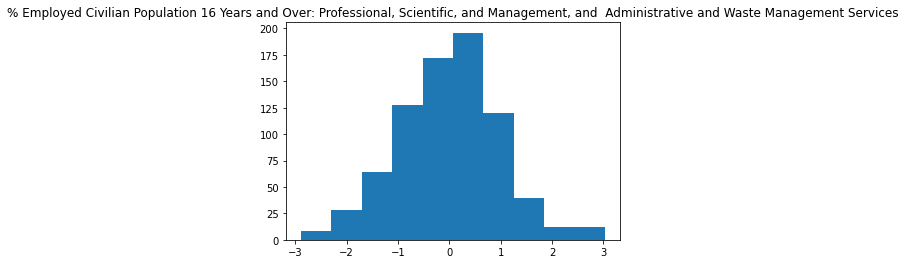

skewness: -0.10220115204092711


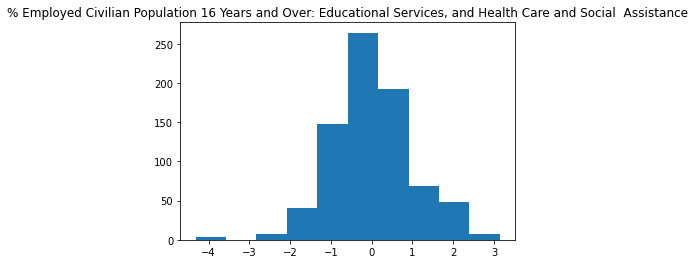

skewness: -0.022562834868312703


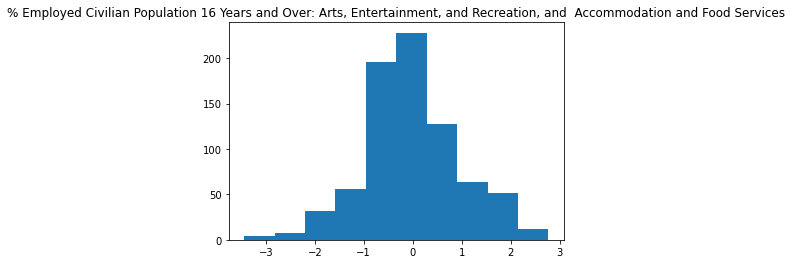

skewness: 0.058656229124440004


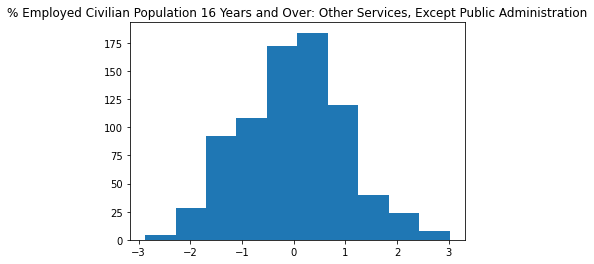

skewness: 0.005279681452842233


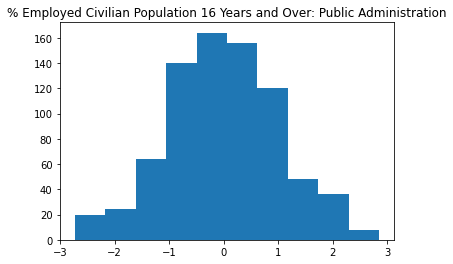

skewness: 0.005745102445576262


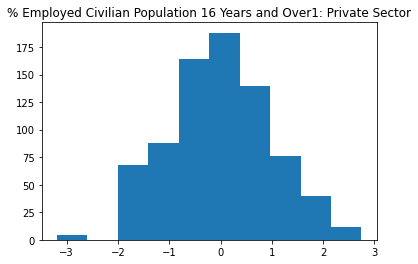

skewness: 0.017758889928703402


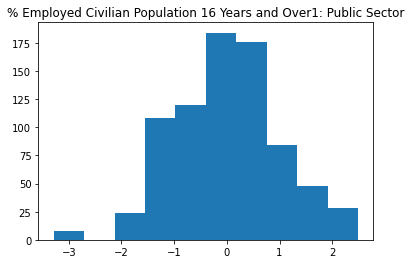

skewness: -0.12250544954849332


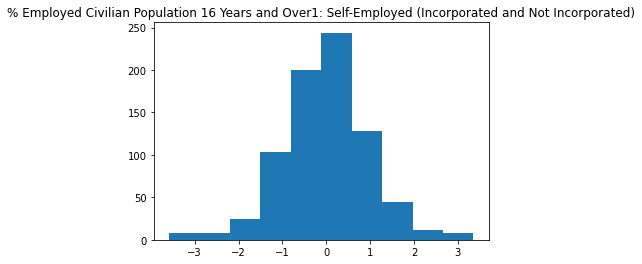

skewness: 0.336534828071675


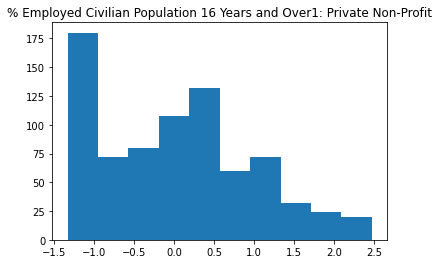

skewness: -0.04620636387463639


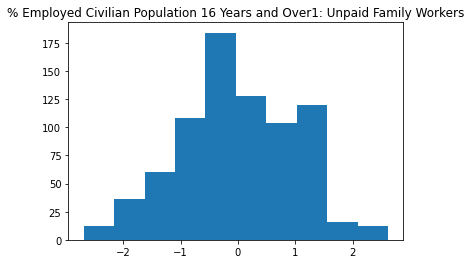

skewness: 0.04620624242758791


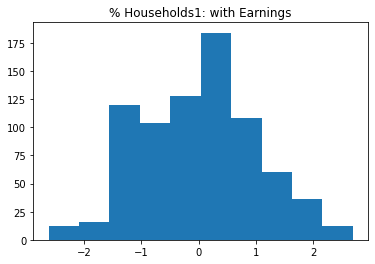

skewness: 0.05573406101214414


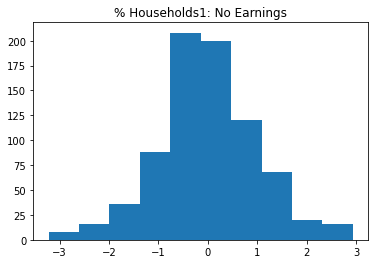

skewness: -0.05573408599250579


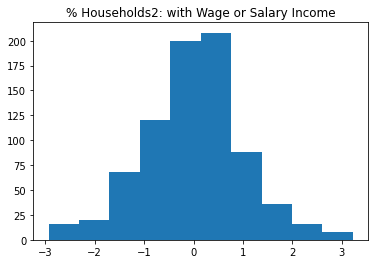

skewness: -0.004799172445005262


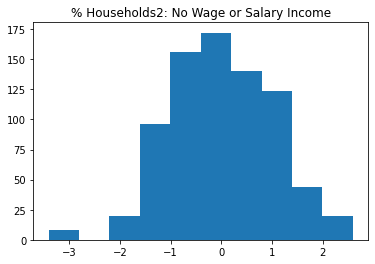

skewness: 0.0047991876872028735


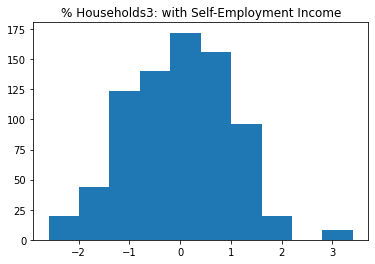

skewness: 0.19527606069262285


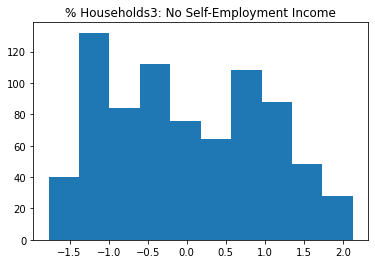

skewness: -0.1952760795293238


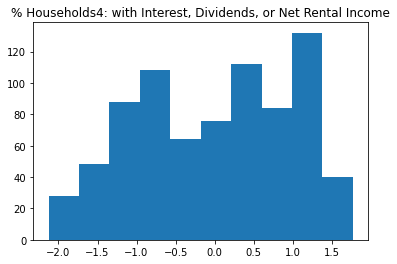

skewness: 0.005020376056947197


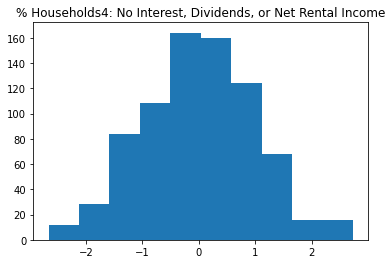

skewness: -0.005020389851757866


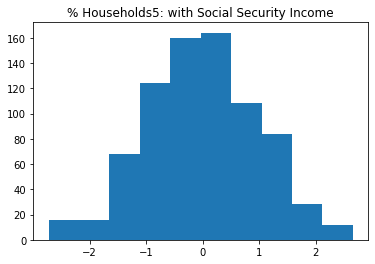

skewness: 0.0211487024641452


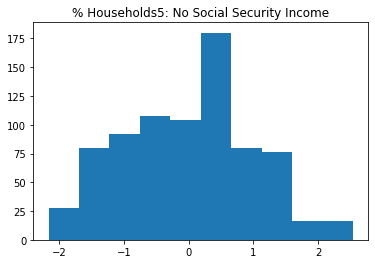

skewness: -0.021148722521451776


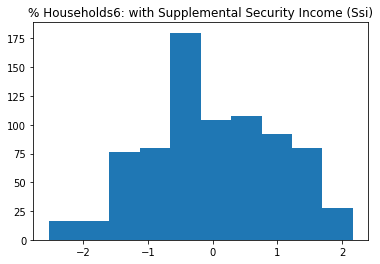

skewness: 0.1132086971614446


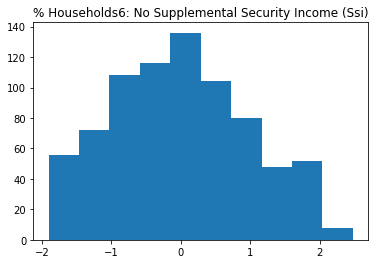

skewness: -0.11320864218307213


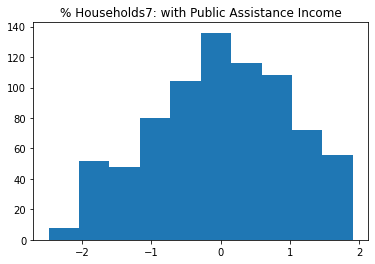

skewness: 0.011218896818347208


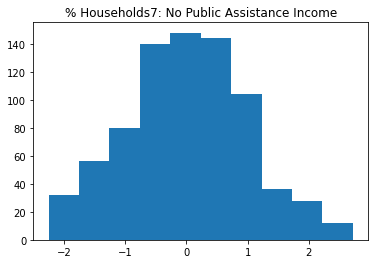

skewness: -0.011218854132577016


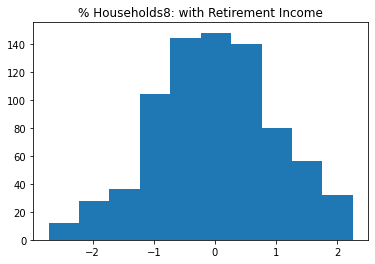

skewness: -0.003146060554536397


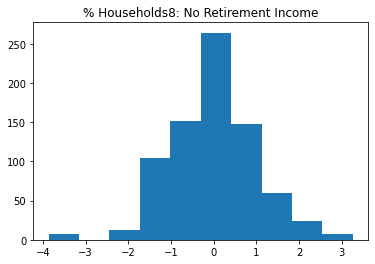

skewness: 0.0031460808129773862


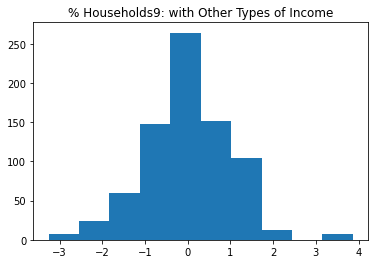

skewness: 0.17071695107860058


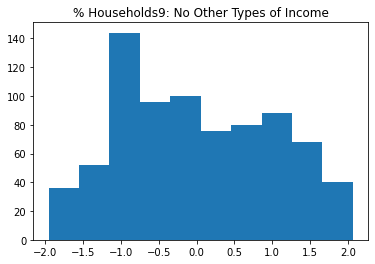

skewness: 0.1929799813043955


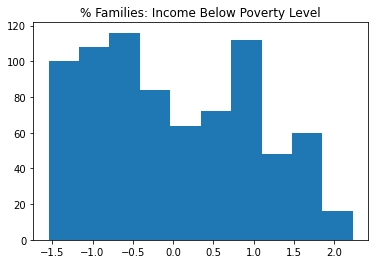

skewness: -0.045287589156859334


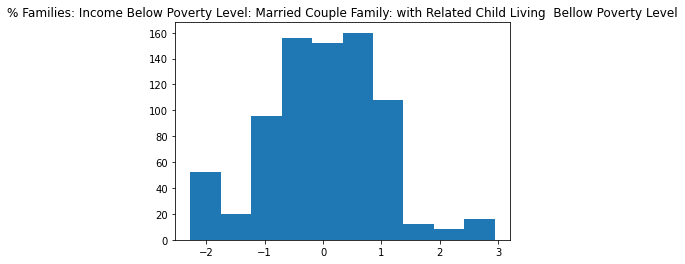

skewness: 0.20210760300143416


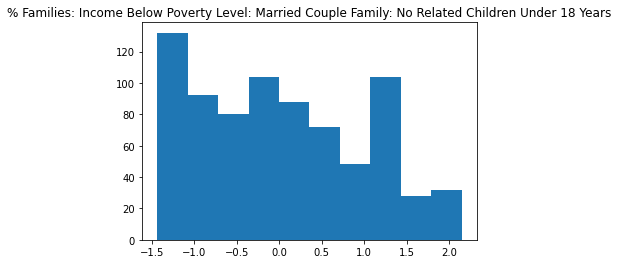

skewness: 0.29976683338769855


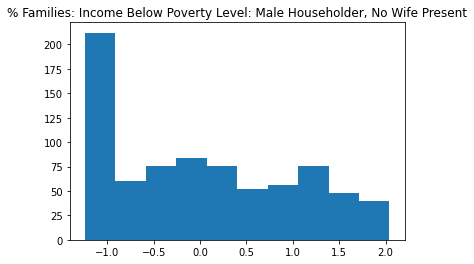

skewness: 0.20962194060494252


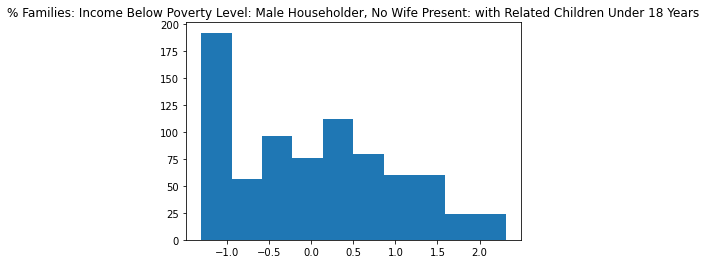

skewness: 0.21550361145108055


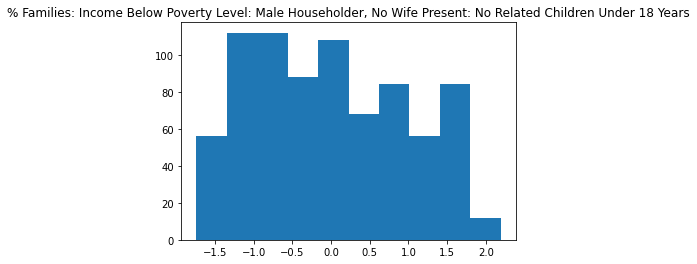

skewness: 0.2489677241040479


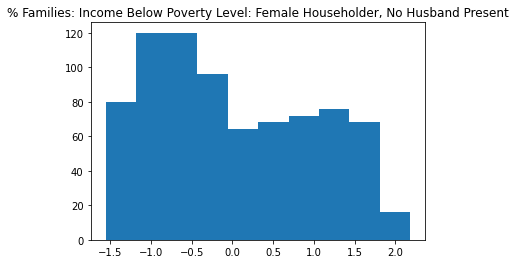

skewness: 0.11098700867982914


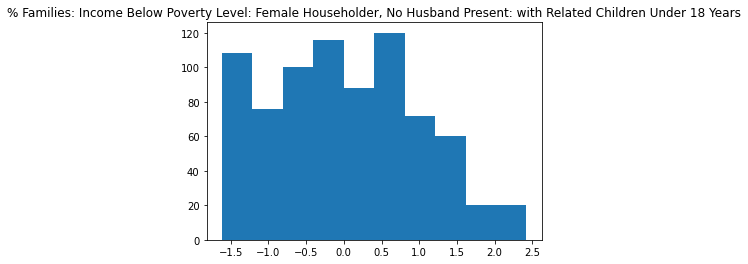

skewness: -0.1707169860269813


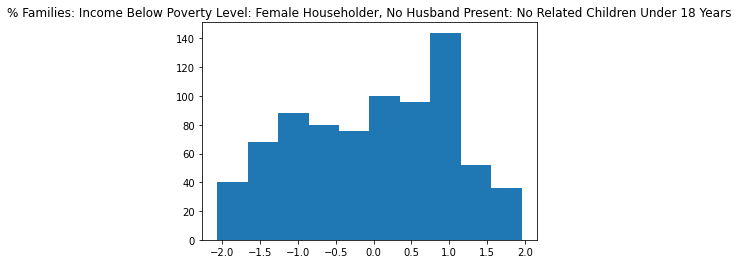

skewness: 0.11013431968694527


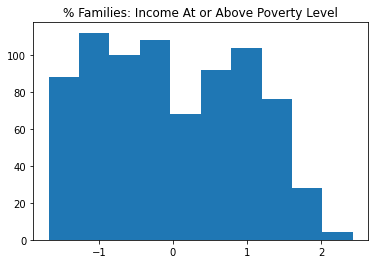

skewness: -0.11013428366479602


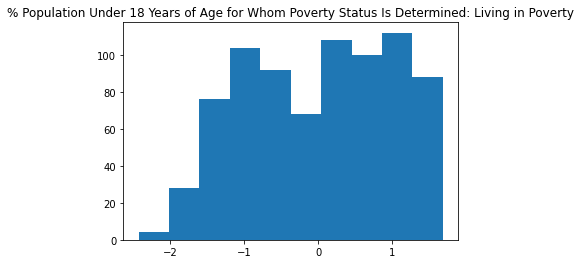

skewness: 0.11344820486267186


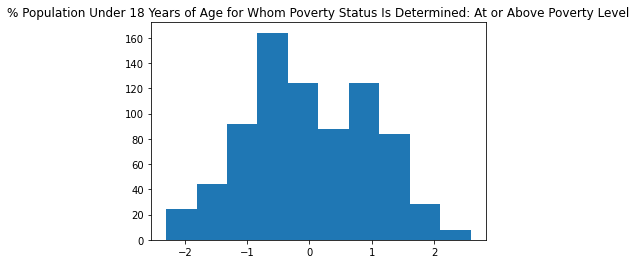

skewness: -0.11344824676161523


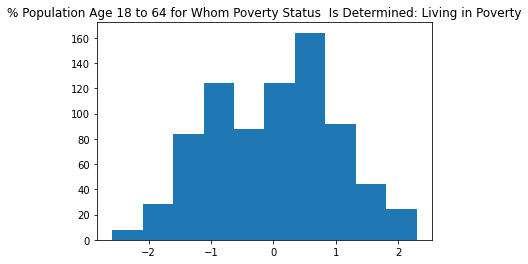

skewness: 0.06534807598736798


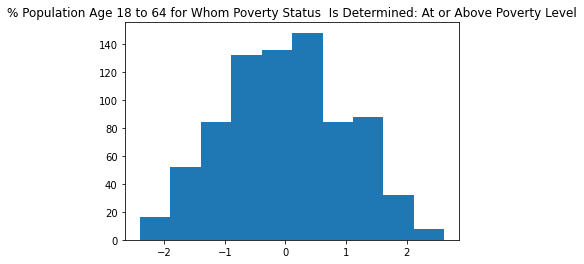

skewness: -0.06534803857268466


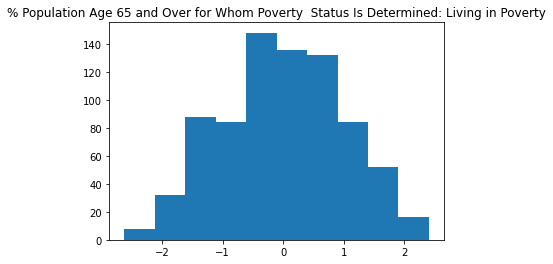

skewness: 0.09424183866999206


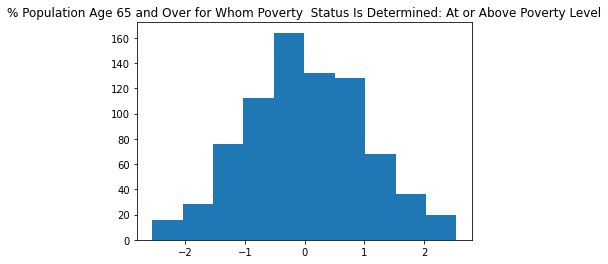

skewness: 0.1631559848319762


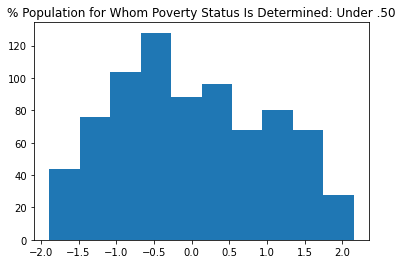

skewness: 0.10000017357174174


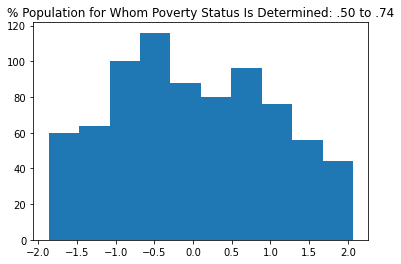

skewness: 0.04405099070411616


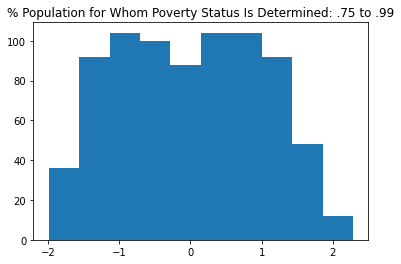

skewness: 0.010535070733433877


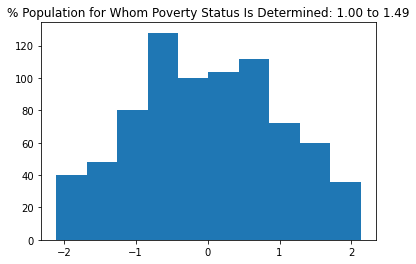

skewness: -0.05892015239167362


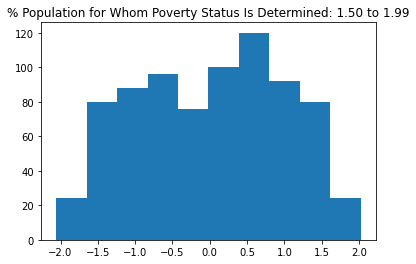

skewness: 0.12728451268575783


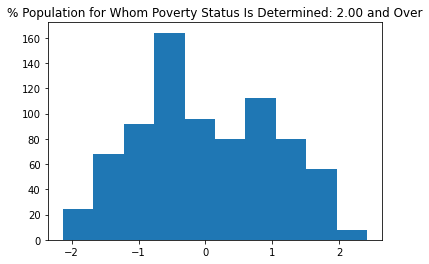

skewness: 0.024918266863838044


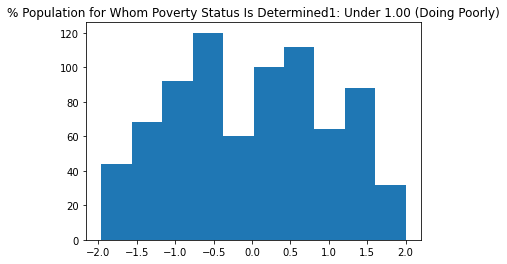

skewness: 0.058920175153568996


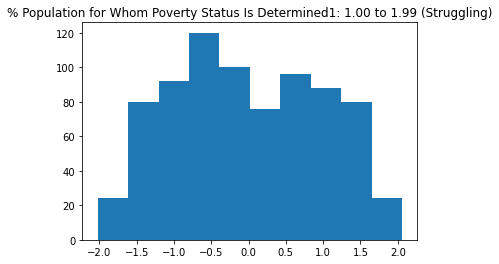

skewness: -0.05892015239167362


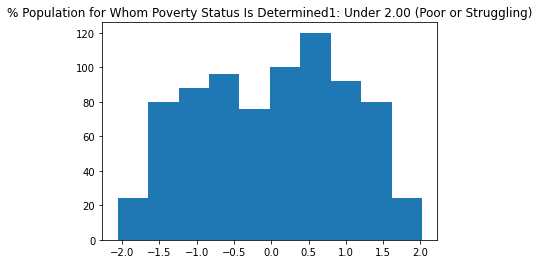

skewness: 0.1338994651757627


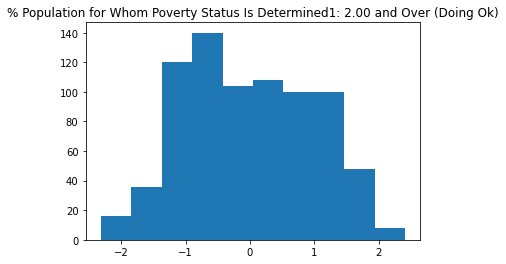

skewness: -0.1338994554660018


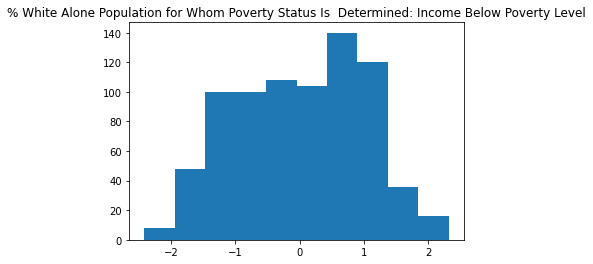

skewness: 0.07049363782242037


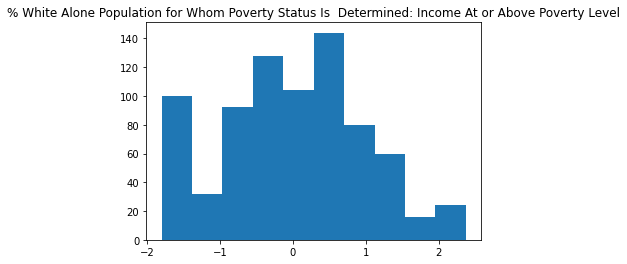

skewness: -0.07049361035655119


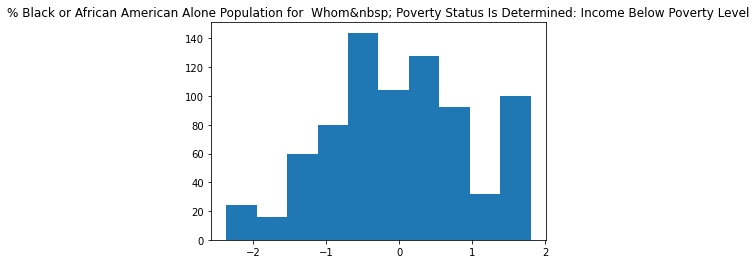

skewness: 0.3703099981647423


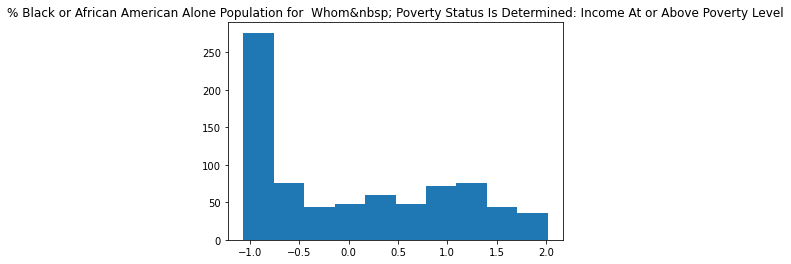

skewness: -0.37180733179300013


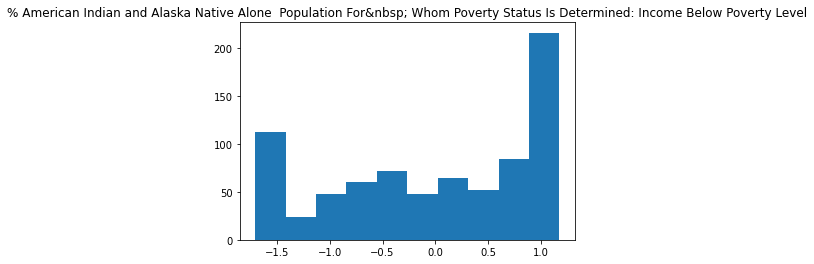

skewness: 0.11993562544415222


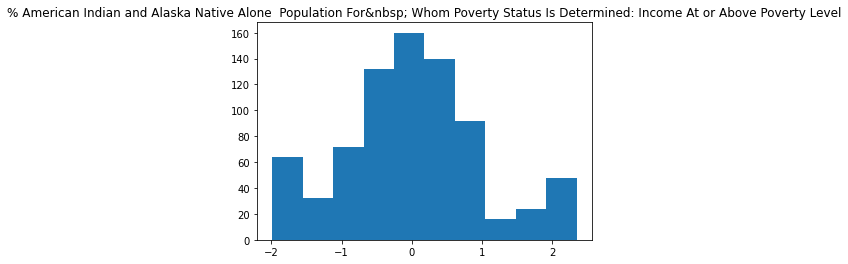

skewness: -0.18820859065829346


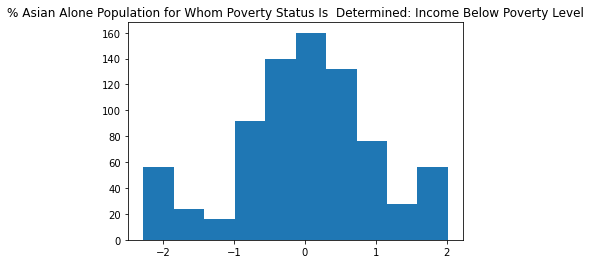

skewness: 1.170091815317092


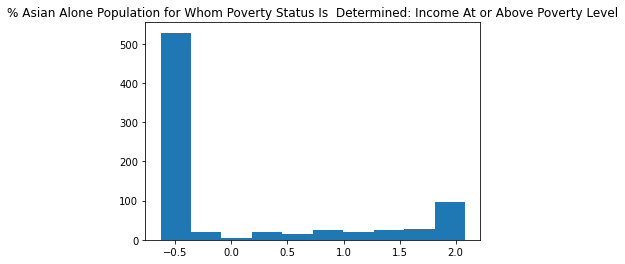

skewness: -0.586493511733741


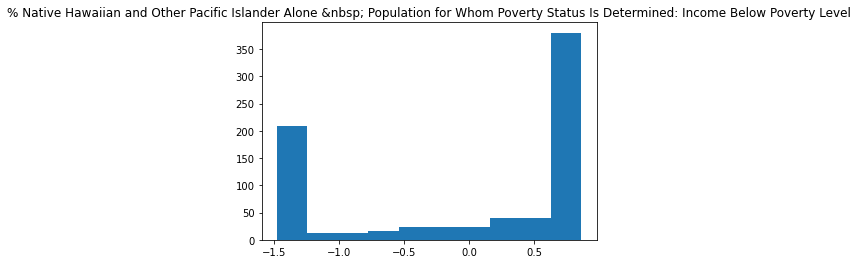

skewness: -0.011408883234603184


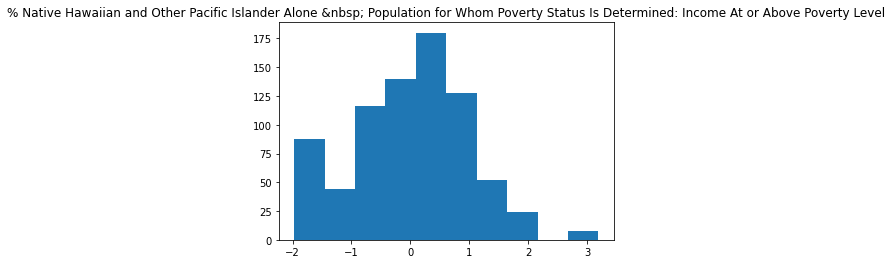

skewness: 0.02174630984442505


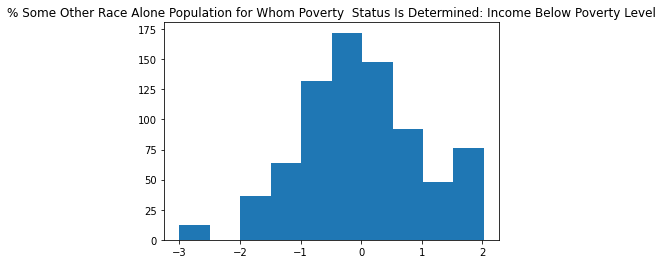

skewness: 0.11886033984832495


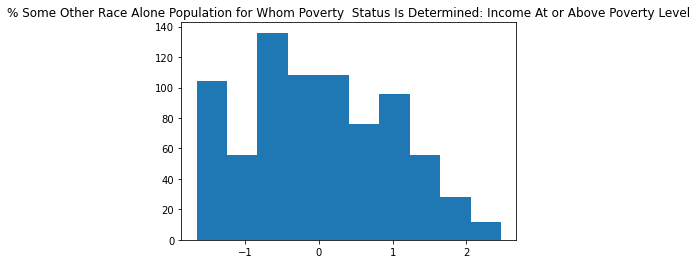

skewness: -0.12675306833487535


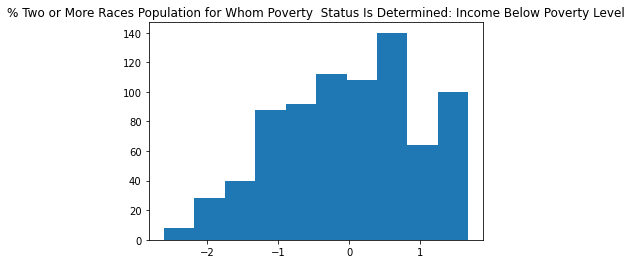

skewness: 0.01560435632539048


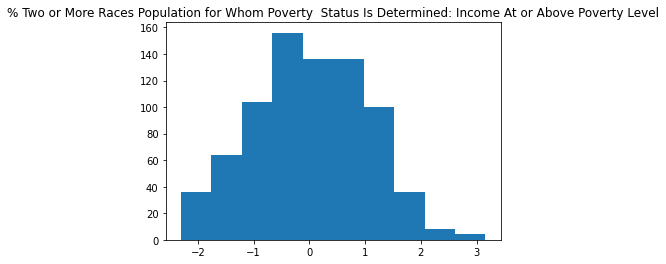

skewness: -0.01560436662776818


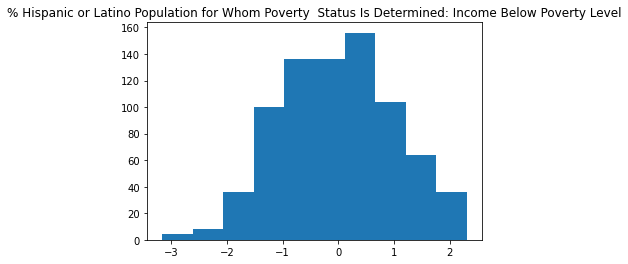

skewness: 0.1869338934754663


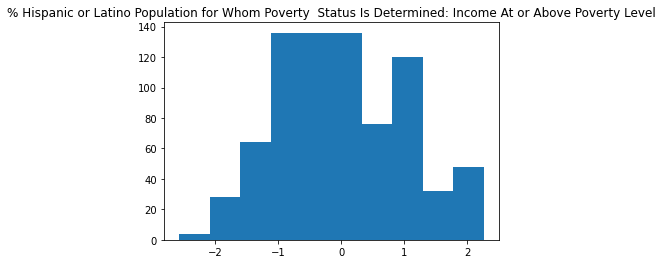

skewness: -0.18693395365660484


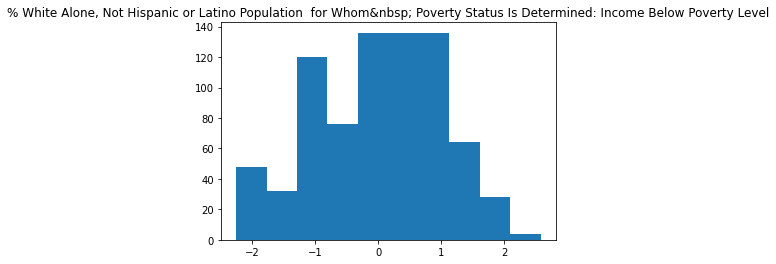

skewness: 0.010397000889074193


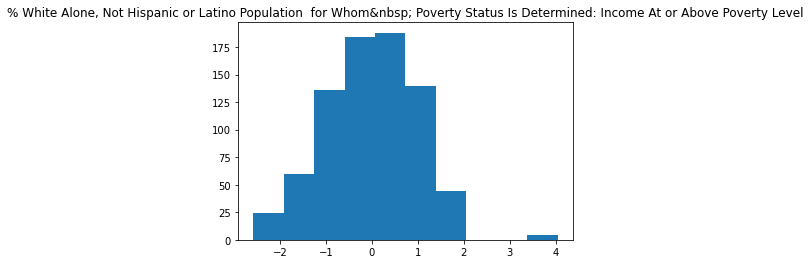

skewness: 0.1335082448912414


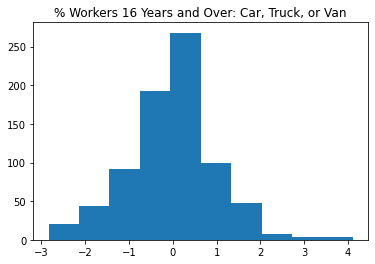

skewness: 0.0024499842911706042


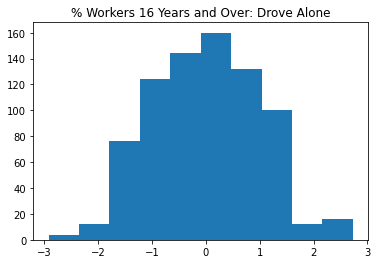

skewness: 0.27036444561961964


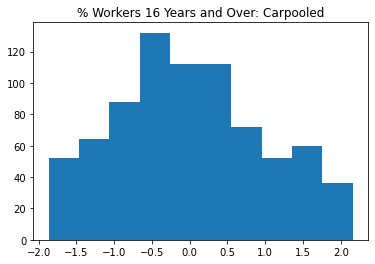

skewness: 0.23737759320053425


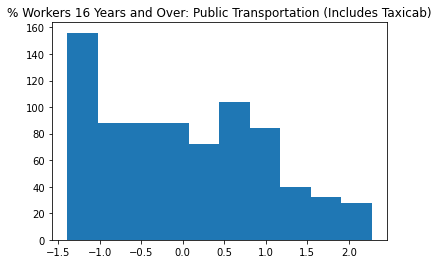

skewness: 0.3335972150736619


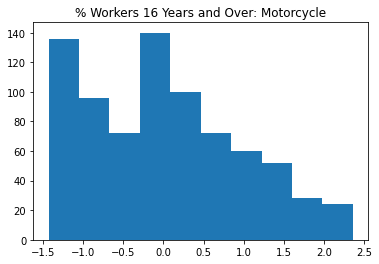

skewness: 0.46055782486073493


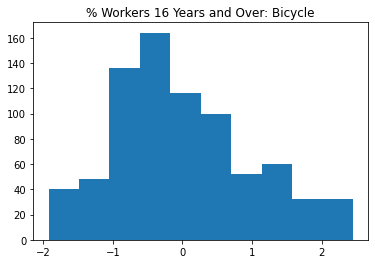

skewness: 0.10873849283003122


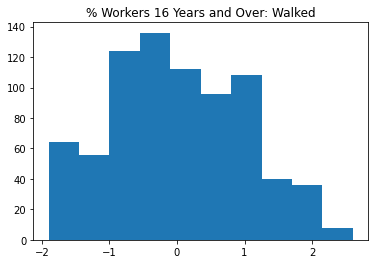

skewness: 0.15418809452037216


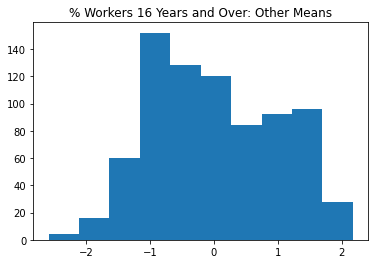

skewness: 0.014906131968731445


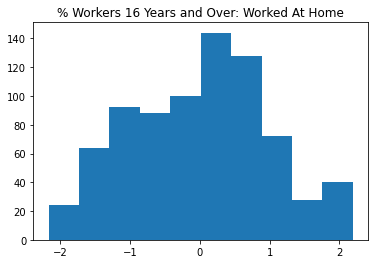

skewness: -0.004133783756216081


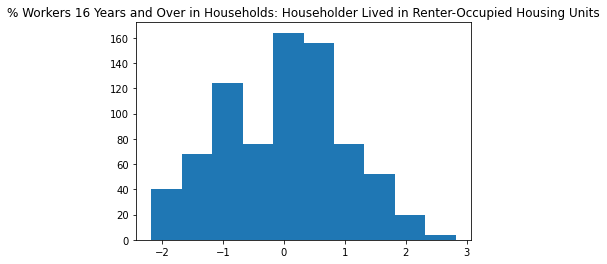

skewness: 0.04114428456144869


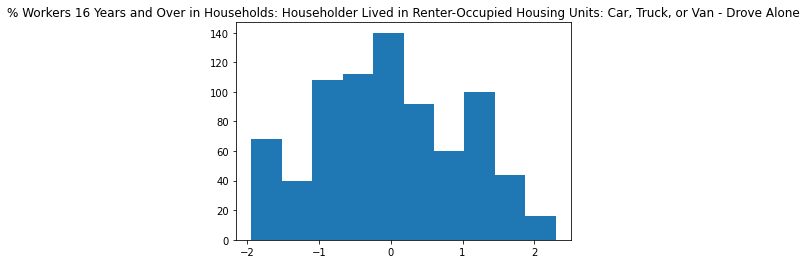

skewness: 0.4163495500006209


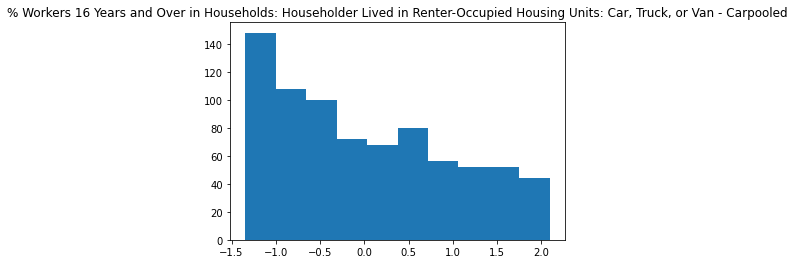

skewness: 0.5349485340775917


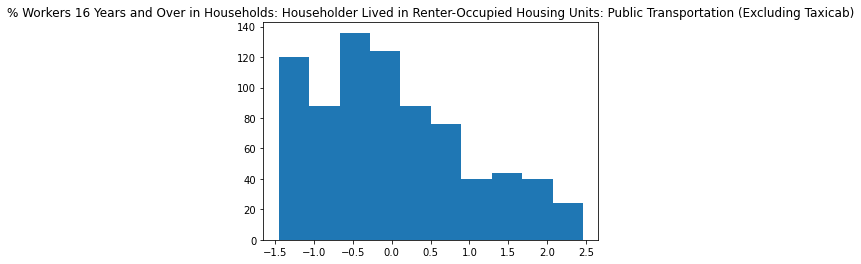

skewness: 0.1443406776114868


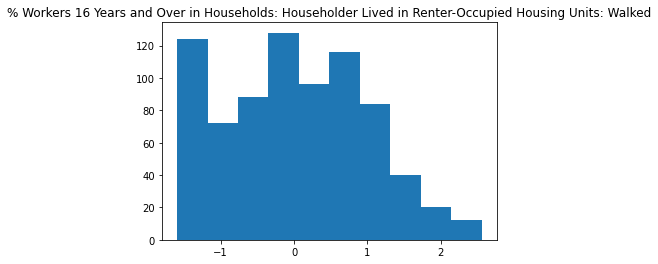

skewness: 0.18217588716194835


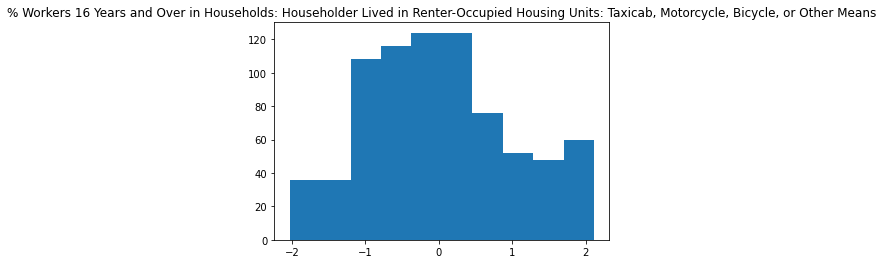

skewness: -0.15418813096389727


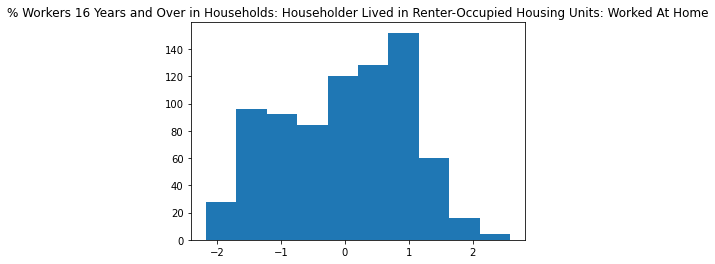

skewness: 0.009184738279341641


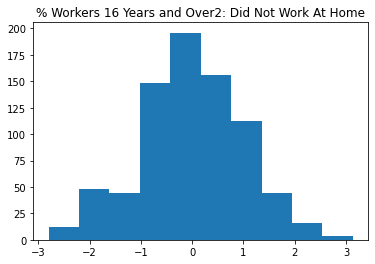

skewness: -0.014835674489368787


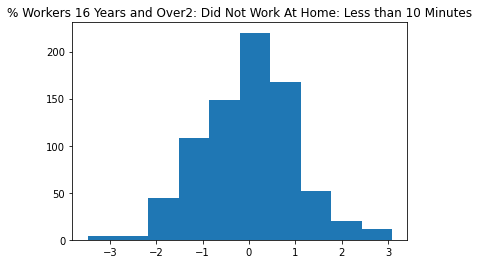

skewness: 0.0748400991723848


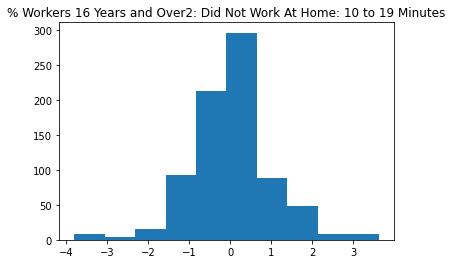

skewness: 0.0027356701916547506


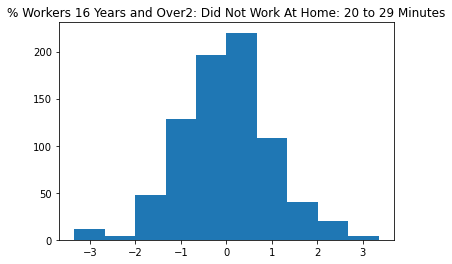

skewness: 0.030171068959102477


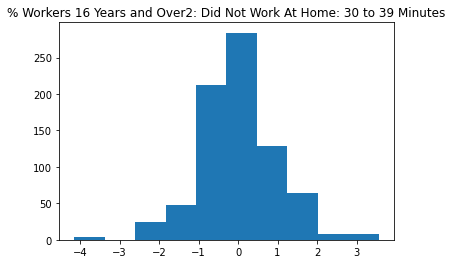

skewness: -0.06358785170833092


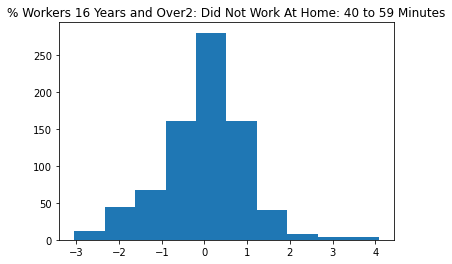

skewness: -0.07742278579199675


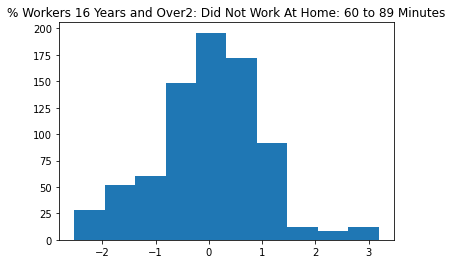

skewness: 0.15418809452037216


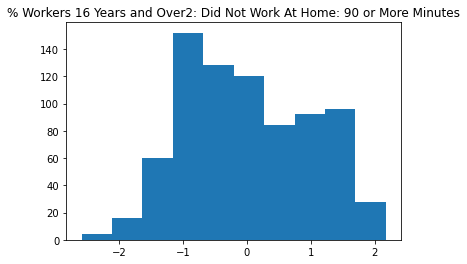

skewness: 0.062011996962361066


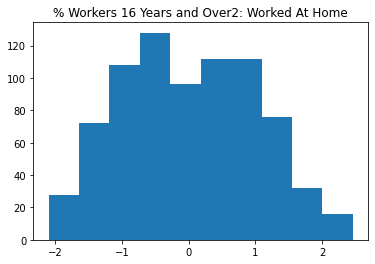

skewness: -0.06201197486721861


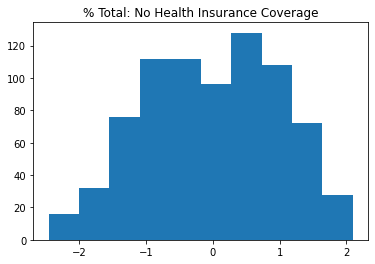

skewness: 0.01145699514105049


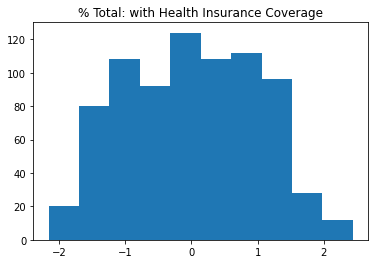

skewness: -0.04357198800754257


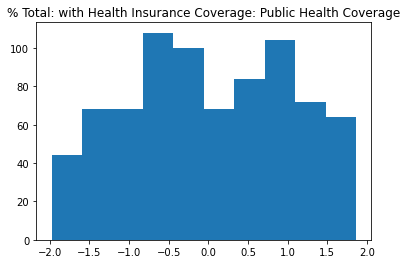

skewness: 0.002406260007986745


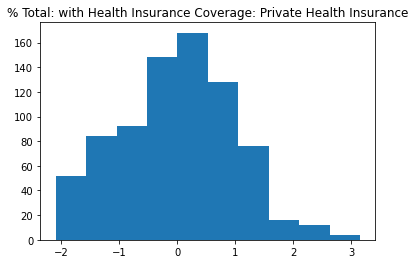

skewness: -0.002406210651450262


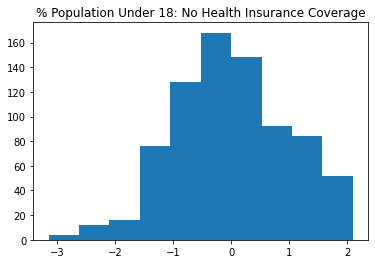

skewness: 0.012246748211541342


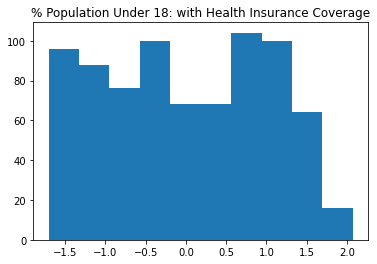

skewness: -0.02068152537226091


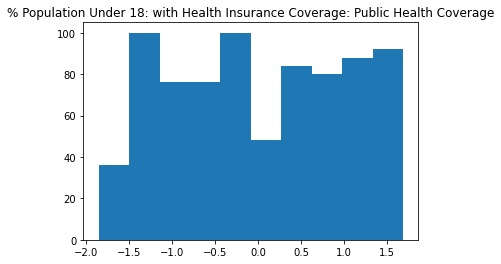

skewness: 0.02255308891953771


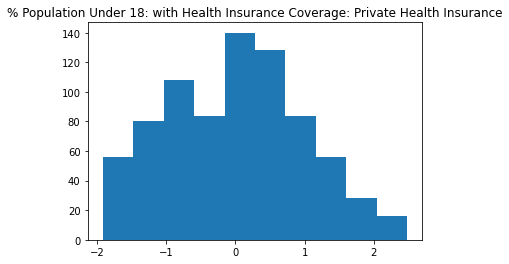

skewness: 0.04695122026974637


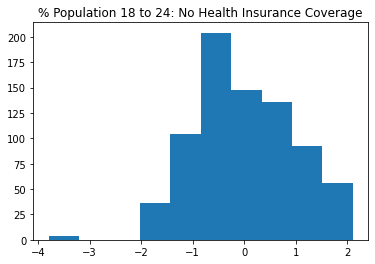

skewness: 0.040282018033433085


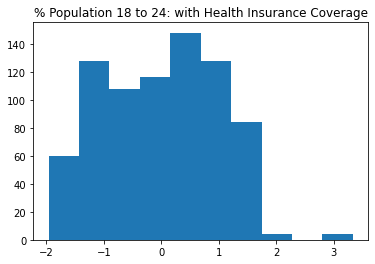

skewness: -0.03548182632146945


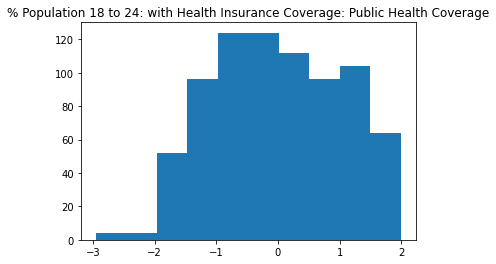

skewness: 0.015969922116615864


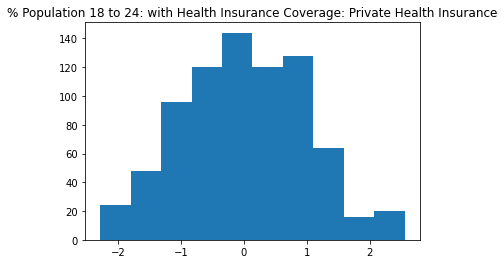

skewness: -0.015969870717299328


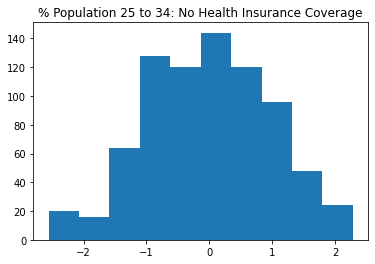

skewness: 0.010981065937405833


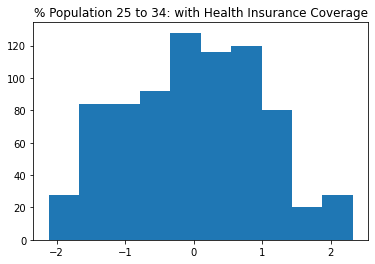

skewness: -0.006188075214177733


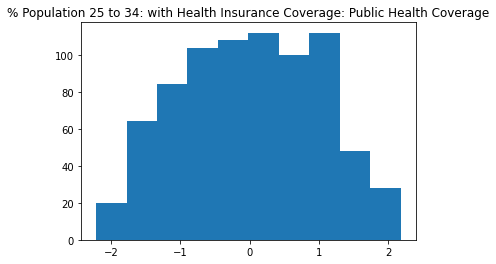

skewness: 0.10626010071231635


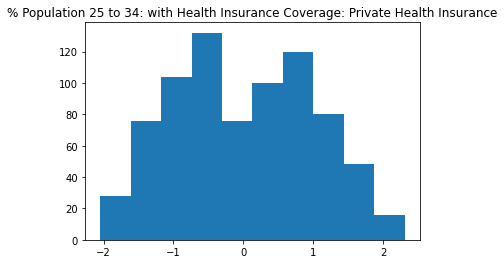

skewness: -0.10626009522598825


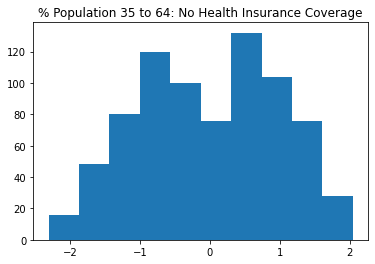

skewness: 0.021516436101486694


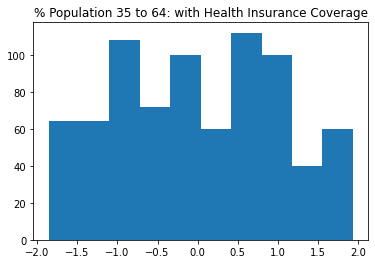

skewness: -0.051304602892793635


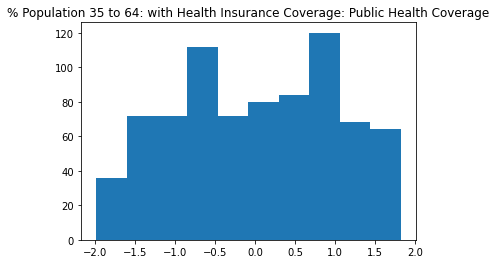

skewness: 0.20284970055304194


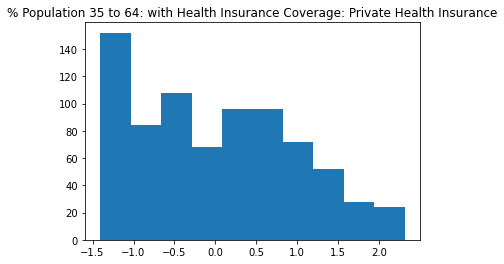

skewness: -0.20284972539727708


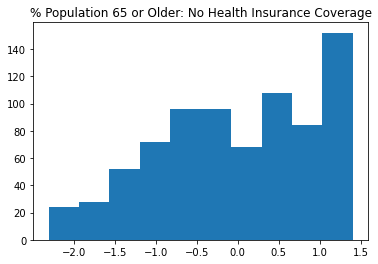

skewness: 0.04416539141589146


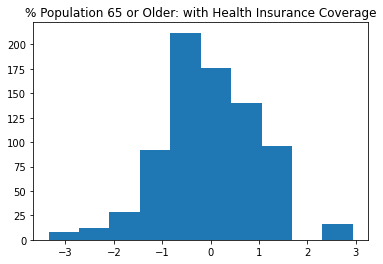

skewness: 0.008148672744253339


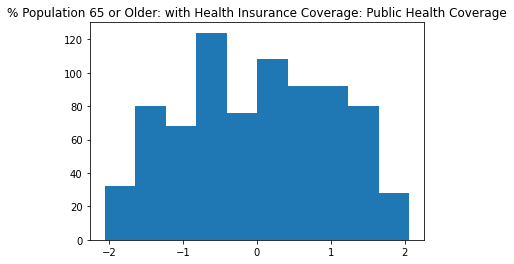

skewness: 0.03415145809135579


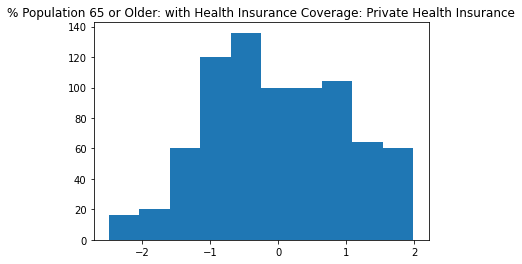

skewness: 0.06710463068591076


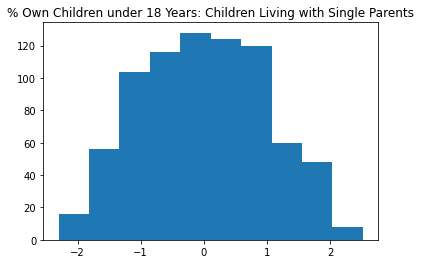

skewness: 0.0030612461622252997


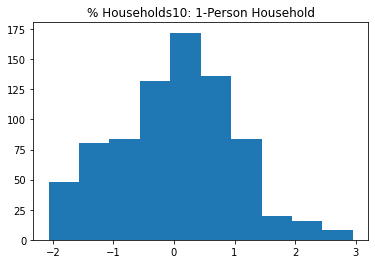

skewness: 0.038895629697151414


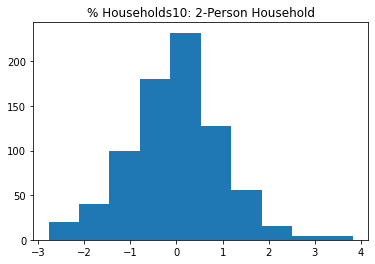

skewness: 0.04633113038385102


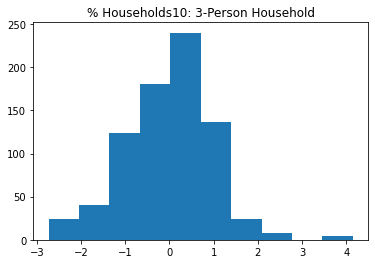

skewness: 0.031150714741876806


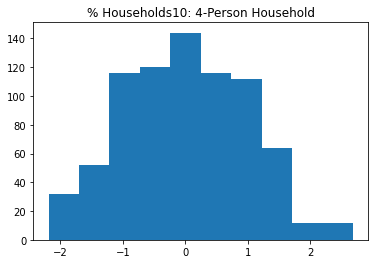

skewness: 0.14606316339980985


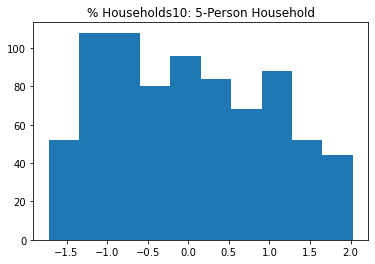

skewness: 0.2857931789768569


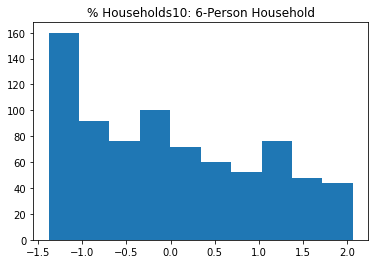

In [98]:
for i in range(wc4m_X_train_arr[0].shape[1]):
    s = skew(wc4m_X_train_arr[0][:,i])
    print("skewness: " + str(s))
    plt.hist(wc4m_X_train_arr[0][:,i])
    plt.title(feature_names[i-1])
    plt.show()
        


In [ ]:
for i in range(1, month_data_with_census.shape[1]-1):
    plt.hist(month_data_with_census[:,i])
    plt.title(feature_names[i-1])
    plt.show()